In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import pandas
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import itertools
import matplotlib.style as style
from mpl_toolkits.mplot3d import Axes3D
import os # accessing directory structure
import plotly
import plotly.express as px
# graphs to be inline
%matplotlib inline

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

"""from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()"""
from collections import Counter


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Importing the Data and merging the features in two seprate datasheets** 

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
#application_data: In this file we have the applicant’s data.
application_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/application_data.csv')
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_data=reduce_mem_usage(application_data)

Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [ ]:
#previous_application: In this file we have the applicant data which is already applied previously applied for the loan
previous_application = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/previous_application.csv')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
previous_application=reduce_mem_usage(previous_application)

Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


In [ ]:
# Database dimension
print("Database dimension - application_data     :",application_data.shape)
print("Database dimension - previous_application :",previous_application.shape)

#Database size
print("Database size - application_data         :",application_data.size)
print("Database size - previous_application     :",previous_application.size)

Database dimension - application_data     : (307511, 122)
Database dimension - previous_application : (1670214, 37)
Database size - application_data         : 37516342
Database size - previous_application     : 61797918


In [ ]:
# previous_application column types
application_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int32  
 1    TARGET                        int8   
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int8   
 7    AMT_INCOME_TOTAL              float32
 8    AMT_CREDIT                    float32
 9    AMT_ANNUITY                   float32
 10   AMT_GOODS_PRICE               float32
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float16
 17   DAYS_BIRTH                    int16  
 18   DA

In [ ]:
# previous_application column types
previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_DOWN_PAYMENT             774370 non-null   float32
 7   AMT_GOODS_PRICE              1284699 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 12  RATE_DOWN_PAYMENT            774370 non-nu

**Observation and Action:**

1) Here we have the two datasheet one is application_data and previous_application_data

2) Application_data contain the fresh Loan applicant data and previous_applicant_data contain the records of the applicant who are previously applied for a loan or rejected loan etc.

3) Post anlaysis we got to know that application_data has the total 122 features and previous_applicant_data has the 37 features

4) SK_ID_CURR is the common feature between both the dataset. So we can use it to merged both the dataset as per the need in future.

5) TARGET feature is act as a dependent variable. It helps to understand whether the applicant is defaulter or not

## **Data Analysis**

**In Data Analysis We will Analyze To Find out the below stuff:**

Missing Values

All The Numerical Variables

Distribution of the Numerical Variables()

Categorical Variables

Cardinality of Categorical Variables

Outliers

Relationship between independent and dependent feature(Target)

# **Feature analysis and cleaning**

In [ ]:
# Function_name : missingdata_percentage
# Usage : Returns % of missing values for all features in a DataFrame
# Arguments : dataframe
# Returns : a dataframe containing categories having missing values and % of missing values in those categories

def missingdata_percentage(df,per):
    missing = pd.DataFrame(columns=['category','percentage'])
    for col in df.columns:
        if df[col].isna().values.any():
            percentage = 100*df[col].isna().sum()/df.shape[0]
            if percentage>=per:
              missing = missing.append({'category' : col, 'percentage' : percentage}, ignore_index=True)
    missing.sort_values(by="percentage",ascending=True)
    return missing

In [ ]:
def value_wise_defaulter_percentage(df, col):
    new_df = pd.DataFrame(columns=['Value', 'Percentage of Defaulter'])
    
    for value in df[col].unique():
        default_cnt = df[(df[col] == value) & (df.TARGET == 1)].shape[0]
        total_cnt = df[df[col] == value].shape[0]
        new_df = new_df.append({'Value' : value , 'Percentage of Defaulter' : (default_cnt*100/total_cnt)}, ignore_index=True)
    return new_df.sort_values(by='Percentage of Defaulter', ascending=False)

In [ ]:
application_data_Miss = missingdata_percentage(application_data,40)# need to repalce the missing data value as -1
application_data_Miss

,category,percentage
0,OWN_CAR_AGE,65.990810
1,EXT_SOURCE_1,56.381073
2,APARTMENTS_AVG,50.749729
3,BASEMENTAREA_AVG,58.515956
4,YEARS_BEGINEXPLUATATION_AVG,48.781019
5,YEARS_BUILD_AVG,66.497784
6,COMMONAREA_AVG,69.872297
7,ELEVATORS_AVG,53.295980
8,ENTRANCES_AVG,50.348768
9,FLOORSMAX_AVG,49.760822


In [ ]:
print(len(application_data_Miss))

49


In [ ]:
# Inspecting the dataframe after before of unnecessary columns
application_data.shape

(307511, 122)

**Observation and action:**

We will drop this features as the Missing value percentage in the features are very high and above the 40%. So this features are not useful for the prediction.

In [ ]:
# create a list of columns that needs to be dropped including the columns with >40% null values
Unwanted_application = application_data_Miss["category"].tolist()
# as EXT_SOURCE_1 column is already included in nullcol_40_application 
print(len(Unwanted_application))
#Unwanted_application

49


In [ ]:
# Dropping the unnecessary columns from application_data
application_data.drop(labels=Unwanted_application,axis=1,inplace=True)

In [ ]:
122-49

73

In [ ]:
# Inspecting the dataframe after removal of unnecessary columns
application_data.shape

(307511, 73)

Now there are total 73 features post removing the features contains the missing values>40%.

## **Numerical Variables**

In [ ]:
# list of numerical variables
numerical_features = [feature for feature in application_data.columns if application_data[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
application_data[numerical_features].head()

Number of numerical variables:  61


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010033,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008018,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028656,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## **FLAG features**

In [ ]:
# list of variables that contain year information
FLAG_feature = [feature for feature in numerical_features if 'FLAG' in feature]
FLAG_feature

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [ ]:
print("Total Number of the FLAG Features: ",len(FLAG_feature))

Total Number of the FLAG Features:  26


### **Analysing the unique features for all FLAG_feature**

In [ ]:
for i in FLAG_feature:
  Number_f=application_data[i].unique()
  print("Number of unique value in {} features is: {} ".format(i,Number_f))

Number of unique value in FLAG_MOBIL features is: [1 0] 
Number of unique value in FLAG_EMP_PHONE features is: [1 0] 
Number of unique value in FLAG_WORK_PHONE features is: [0 1] 
Number of unique value in FLAG_CONT_MOBILE features is: [1 0] 
Number of unique value in FLAG_PHONE features is: [1 0] 
Number of unique value in FLAG_EMAIL features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_2 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_3 features is: [1 0] 
Number of unique value in FLAG_DOCUMENT_4 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_5 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_6 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_7 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_8 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_9 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_10 features is: [0 1] 
Number of unique value in FLAG_DOCUMENT_11 features is: [0 1] 
Number of unique valu

### **Analysing the value_counts for all FLAG_feature**

In [ ]:
for j,i in enumerate(FLAG_feature):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in FLAG_MOBIL features is:

 1    307510
0         1
Name: FLAG_MOBIL, dtype: int64 

 2) value_counts in FLAG_EMP_PHONE features is:

 1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64 

 3) value_counts in FLAG_WORK_PHONE features is:

 0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64 

 4) value_counts in FLAG_CONT_MOBILE features is:

 1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64 

 5) value_counts in FLAG_PHONE features is:

 0    221080
1     86431
Name: FLAG_PHONE, dtype: int64 

 6) value_counts in FLAG_EMAIL features is:

 0    290069
1     17442
Name: FLAG_EMAIL, dtype: int64 

 7) value_counts in FLAG_DOCUMENT_2 features is:

 0    307498
1        13
Name: FLAG_DOCUMENT_2, dtype: int64 

 8) value_counts in FLAG_DOCUMENT_3 features is:

 1    218340
0     89171
Name: FLAG_DOCUMENT_3, dtype: int64 

 9) value_counts in FLAG_DOCUMENT_4 features is:

 0    307486
1        25
Name: FLAG_DOCUMENT_4, dtype: int64 

 10) value_c

### **Visualizing the all FLAG_feature with heatmap**

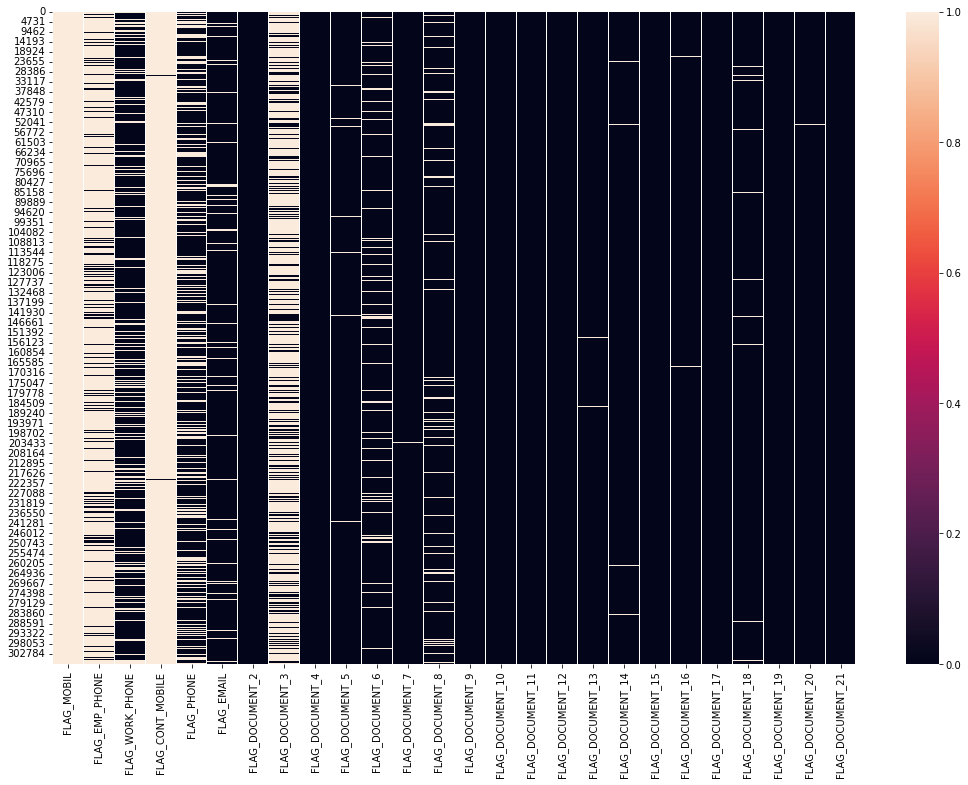

In [ ]:
plt.figure(figsize=(18,12))
sns.heatmap(application_data[FLAG_feature])
plt.show()

**Observation and action:**

Post Analysing all the FLAG feature we got to know that all the faetures are heavily imbalance and not useful differentiator for the TARGET prediction.So,we can drop this features.

In [ ]:
# Dropping the unnecessary columns from application_data
application_data.drop(labels=FLAG_feature,axis=1,inplace=True)

In [ ]:
# Inspecting the dataframe after removal of unnecessary columns
application_data.shape

(307511, 47)

In [ ]:
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


## **REGION Realted Features**

In [ ]:
# list of variables that contain REGION information
REGION_feature = [feature for feature in numerical_features if 'NOT_LIVE' in feature or 'NOT_WORK' in feature]
REGION_feature

['REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

In [ ]:
start_idx = application_data.columns.get_loc('REG_REGION_NOT_LIVE_REGION')
end_idx = application_data.columns.get_loc('LIVE_CITY_NOT_WORK_CITY')

social_circle_df = application_data.iloc[:, start_idx:end_idx+1]

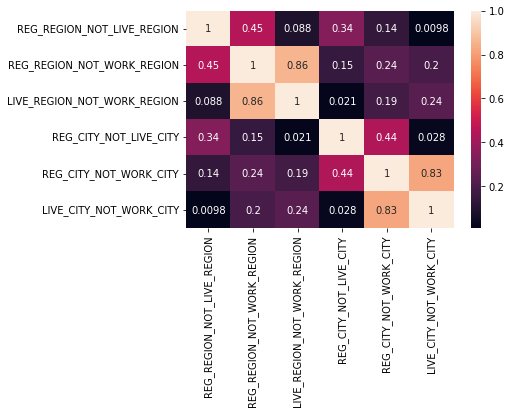

In [ ]:
sns.heatmap(social_circle_df.corr(), annot=True)

In [ ]:
for j,i in enumerate(REGION_feature):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in REG_REGION_NOT_LIVE_REGION features is:

 0    302854
1      4657
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64 

 2) value_counts in REG_REGION_NOT_WORK_REGION features is:

 0    291899
1     15612
Name: REG_REGION_NOT_WORK_REGION, dtype: int64 

 3) value_counts in LIVE_REGION_NOT_WORK_REGION features is:

 0    295008
1     12503
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64 

 4) value_counts in REG_CITY_NOT_LIVE_CITY features is:

 0    283472
1     24039
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64 

 5) value_counts in REG_CITY_NOT_WORK_CITY features is:

 0    236644
1     70867
Name: REG_CITY_NOT_WORK_CITY, dtype: int64 

 6) value_counts in LIVE_CITY_NOT_WORK_CITY features is:

 0    252296
1     55215
Name: LIVE_CITY_NOT_WORK_CITY, dtype: int64 


**Observation and action:**

1) REG_REGION_NOT_LIVE_REGION fature is highly imbalance so we will remove it.

2) REG_REGION_NOT_WORK_REGION and LIVE_REGION_NOT_WORK_REGION are highly correlated so possibly we can remove one of them.Mostly LIVE_REGION_NOT_WORK_REGION due to imbalance issue.

3) REG_CITY_NOT_WORK_CITY and LIVE_CITY_NOT_WORK_CITY are highly correlated so possibly we can remove one of them.

In [ ]:
Reg_City_feature=["REG_REGION_NOT_LIVE_REGION","LIVE_REGION_NOT_WORK_REGION","LIVE_CITY_NOT_WORK_CITY"]

In [ ]:
# Dropping the unnecessary columns from application_data
application_data.drop(labels=Reg_City_feature,axis=1,inplace=True)

In [ ]:
# Inspecting the dataframe after removal of unnecessary columns
application_data.shape

(307511, 44)

In [ ]:
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


## **SOCIAL_CIRCLE related features**

In [ ]:
# list of variables that contain year information
SOCIAL_CIRCLE_feature = [feature for feature in numerical_features if 'SOCIAL_CIRCLE' in feature]
SOCIAL_CIRCLE_feature

['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

In [ ]:
start_idx = application_data.columns.get_loc('OBS_30_CNT_SOCIAL_CIRCLE')
end_idx = application_data.columns.get_loc('DEF_60_CNT_SOCIAL_CIRCLE')

SOCIAL_CIRCLE_df = application_data.iloc[:, start_idx:end_idx+1]

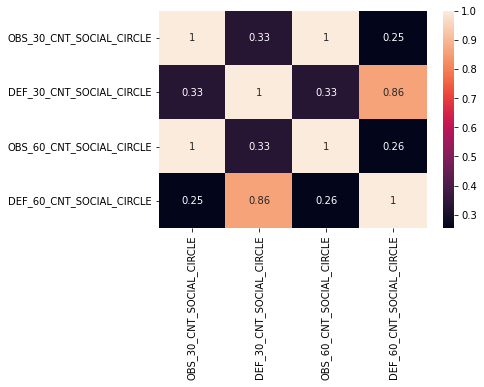

In [ ]:
sns.heatmap(SOCIAL_CIRCLE_df.corr(), annot=True)

In [ ]:
for j,i in enumerate(SOCIAL_CIRCLE_feature):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in OBS_30_CNT_SOCIAL_CIRCLE features is:

 0.0      163910
1.0       48783
2.0       29808
3.0       20322
4.0       14143
5.0        9553
6.0        6453
7.0        4390
8.0        2967
9.0        2003
10.0       1376
11.0        852
12.0        652
13.0        411
14.0        258
15.0        166
16.0        133
17.0         88
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
25.0         11
24.0         11
27.0          5
26.0          3
30.0          2
28.0          1
29.0          1
47.0          1
348.0         1
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: int64 

 2) value_counts in DEF_30_CNT_SOCIAL_CIRCLE features is:

 0.0     271324
1.0      28328
2.0       5323
3.0       1192
4.0        253
5.0         56
6.0         11
7.0          1
34.0         1
8.0          1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64 

 3) value_counts in OBS_60_CNT_SOCIAL_CIRCLE features is:

 0.0      164666
1.0       48870
2.0       29766

**Observation and action:**

1) OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE feature are highly correlated.So,this feature are same feature and we can skip any one feature .

2) DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE feature are highly correlated.So,this feature are same feature and we can skip any one feature

In [ ]:
SOCIAL_CIRCLE_feature=['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE']

In [ ]:
# Dropping the unnecessary columns from application_data
application_data.drop(labels=SOCIAL_CIRCLE_feature,axis=1,inplace=True)

In [ ]:
# Inspecting the dataframe after removal of unnecessary columns
application_data.shape

(307511, 42)

In [ ]:
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.139404,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.729492,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


## **DAYS Related Features**

In [ ]:
# list of variables that contain year information
DAYS_feature = [feature for feature in numerical_features if 'DAYS' in feature]
DAYS_feature

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

In [ ]:
# Converting DAYS_BIRTH to Age

application_data["Age"] = application_data.DAYS_BIRTH//(-365) 
application_data[["Age"]].head()

,Age
0,25
1,45
2,52
3,52
4,54


In [ ]:
# Converting DAYS_EMPLOYED to YEAR_EMPLOYED

application_data["YEAR_EMPLOYED"] = application_data.DAYS_EMPLOYED//(-365) 
application_data[["YEAR_EMPLOYED"]].describe()

,YEAR_EMPLOYED
count,307511.000000
mean,-175.301765
std,386.995277
min,-1001.000000
25%,0.000000
50%,3.000000
75%,7.000000
max,49.000000


In [ ]:
application_data[["YEAR_EMPLOYED"]].value_counts()

YEAR_EMPLOYED
-1001            55374
 1               31841
 2               29648
 0               27904
 3               25107
 4               21767
 5               16271
 6               15051
 7               13148
 8               11440
 9                8980
 10               7364
 11               5902
 12               5309
 14               4643
 13               4349
 15               2725
 16               2335
 17               2006
 18               1918
 19               1871
 20               1600
 21               1461
 22               1253
 23               1016
 24                914
 25                821
 27                656
 26                653
 28                611
 29                567
 30                457
 31                437
 34                364
 32                351
 33                331
 35                257
 36                196
 37                138
 39                125
 38                116
 40                 59
 41                 

In [ ]:
#Replacing the unrealstic category -1001 with 2nd most occuring category with 1
application_data["YEAR_EMPLOYED"].replace([-1001],[1],inplace=True)

In [ ]:
application_data[["YEAR_EMPLOYED"]].value_counts()

YEAR_EMPLOYED
1                87215
2                29648
0                27904
3                25107
4                21767
5                16271
6                15051
7                13148
8                11440
9                 8980
10                7364
11                5902
12                5309
14                4643
13                4349
15                2725
16                2335
17                2006
18                1918
19                1871
20                1600
21                1461
22                1253
23                1016
24                 914
25                 821
27                 656
26                 653
28                 611
29                 567
30                 457
31                 437
34                 364
32                 351
33                 331
35                 257
36                 196
37                 138
39                 125
38                 116
40                  59
41                  59
42                  

In [ ]:
# Converting DAYS_REGISTRATION to YEAR_REGISTRATION

application_data["YEAR_REGISTRATION"] = application_data.DAYS_REGISTRATION//(-365) 
application_data[["YEAR_REGISTRATION"]].describe()

,YEAR_REGISTRATION
count,307511.000000
mean,13.168449
std,9.645753
min,0.000000
25%,5.000000
50%,12.000000
75%,20.000000
max,67.000000


In [ ]:
# Converting DAYS_ID_PUBLISH to YEAR_ID_PUBLISH

application_data["YEAR_ID_PUBLISH"] = application_data.DAYS_ID_PUBLISH//(-365) 
application_data[["YEAR_ID_PUBLISH"]].describe()

,YEAR_ID_PUBLISH
count,307511.000000
mean,7.713474
std,4.134515
min,0.000000
25%,4.000000
50%,8.000000
75%,11.000000
max,19.000000


In [ ]:
# Converting DAYS_LAST_PHONE_CHANGE to YEAR_LAST_PHONE_CHANGE

application_data["YEAR_LAST_PHONE_CHANGE"] = application_data.DAYS_LAST_PHONE_CHANGE//(-365) 
application_data[["YEAR_LAST_PHONE_CHANGE"]].describe()

,YEAR_LAST_PHONE_CHANGE
count,307510.000000
mean,2.225141
std,2.193951
min,0.000000
25%,0.000000
50%,2.000000
75%,4.000000
max,11.000000


In [ ]:
# Dropping the column as new column will be used for analysis

application_data.drop(labels=DAYS_feature, inplace=True, axis=1)

In [ ]:
application_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,YEAR_EMPLOYED,YEAR_REGISTRATION,YEAR_ID_PUBLISH,YEAR_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,25,1,9.0,5,3.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,45,3,3.0,0,2.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,52,0,11.0,6,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,52,8,26.0,6,1.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,54,8,11.0,9,3.0


In [ ]:
application_data.shape

(307511, 42)

In [ ]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int32  
 1   TARGET                       307511 non-null  int8   
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int8   
 7   AMT_INCOME_TOTAL             307511 non-null  float32
 8   AMT_CREDIT                   307511 non-null  float32
 9   AMT_ANNUITY                  307499 non-null  float32
 10  AMT_GOODS_PRICE              307233 non-null  float32
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

# <font color='red'>**application_data**

# **Numerical Features**

In [ ]:
# list of numerical variables
All_numerical_features = [feature for feature in application_data.columns if application_data[feature].dtypes != 'O']

print('Number of numerical variables: ', len(All_numerical_features))

# visualise the numerical variables
application_data[All_numerical_features].head()

Number of numerical variables:  30


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,YEAR_EMPLOYED,YEAR_REGISTRATION,YEAR_ID_PUBLISH,YEAR_LAST_PHONE_CHANGE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,1.0,2,...,0.0,0.0,0.0,0.0,1.0,25,1,9.0,5,3.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,2.0,1,...,0.0,0.0,0.0,0.0,0.0,45,3,3.0,0,2.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010033,1.0,2,...,0.0,0.0,0.0,0.0,0.0,52,0,11.0,6,2.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008018,2.0,2,...,NaN,NaN,NaN,NaN,NaN,52,8,26.0,6,1.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028656,1.0,2,...,0.0,0.0,0.0,0.0,0.0,54,8,11.0,9,3.0


#**Discrete Features**

In [ ]:
## Numerical variables are usually of 2 type
## 1. Continous variable and Discrete Variables

discrete_feature=[feature for feature in All_numerical_features if len(application_data[feature].unique())<25 and feature not in ['SK_ID_CURR']]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 16


In [ ]:
discrete_feature

['TARGET',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'YEAR_ID_PUBLISH',
 'YEAR_LAST_PHONE_CHANGE']

In [ ]:
application_data[discrete_feature].head()

,TARGET,CNT_CHILDREN,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,YEAR_ID_PUBLISH,YEAR_LAST_PHONE_CHANGE
0,1,0,1.0,2,2,10,0,0,0,2.0,0.0,0.0,0.0,0.0,5,3.0
1,0,0,2.0,1,1,11,0,0,0,0.0,0.0,0.0,0.0,0.0,0,2.0
2,0,0,1.0,2,2,9,0,0,0,0.0,0.0,0.0,0.0,0.0,6,2.0
3,0,0,2.0,2,2,17,0,0,0,0.0,NaN,NaN,NaN,NaN,6,1.0
4,0,0,1.0,2,2,11,0,0,1,0.0,0.0,0.0,0.0,0.0,9,3.0


## **TARGET**

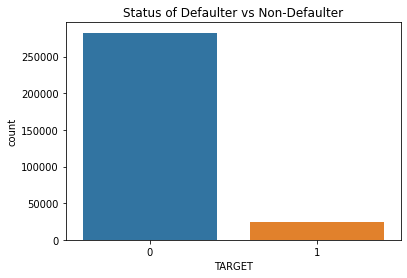

In [ ]:
plt.title("Status of Defaulter vs Non-Defaulter")
sns.countplot(application_data['TARGET'])
plt.show()

In [ ]:
non_default  = application_data[application_data["TARGET"] == 0]
default  = application_data[application_data["TARGET"] == 1]

print("No. of defaulters: ", default.shape[0])
print("No. of non-defaulters: ", non_default.shape[0])

No. of defaulters:  24825
No. of non-defaulters:  282686


In [ ]:
print("Percentage of defaulters: ", default.shape[0]*100/(default.shape[0]+non_default.shape[0]))

Percentage of defaulters:  8.072881945686495


**Observation and action:**

1) Defaulter percentage(8%) is very low as compare to the Non-defaulter(92%).So, the data is highly imbalance.

## **Family Related Info**

In [ ]:
application_data[['CNT_CHILDREN', 'CNT_FAM_MEMBERS']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CNT_CHILDREN     307511 non-null  int8   
 1   CNT_FAM_MEMBERS  307509 non-null  float16
dtypes: float16(1), int8(1)
memory usage: 901.0 KB


In [ ]:
application_data['CNT_FAM_MEMBERS'].value_counts()

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [ ]:
# There are 2 missing values in the CNT_FAM_MEMBERS so we will replace that with the most occuring category
application_data['CNT_FAM_MEMBERS']=application_data['CNT_FAM_MEMBERS'].fillna(application_data['CNT_FAM_MEMBERS'].mode()[0])

In [ ]:
application_data['CNT_FAM_MEMBERS'].value_counts()

2.0     158359
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [ ]:
# Since number of family member cannot have fraction, converting to Integer

application_data['CNT_FAM_MEMBERS'] = application_data['CNT_FAM_MEMBERS'].astype(int)
application_data[['CNT_FAM_MEMBERS']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   CNT_FAM_MEMBERS  307511 non-null  int64
dtypes: int64(1)
memory usage: 2.3 MB


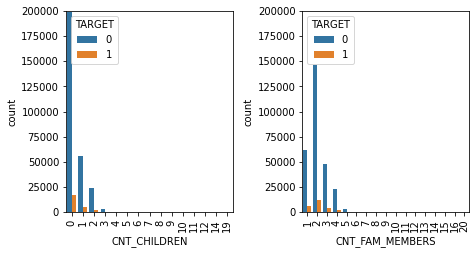

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(['CNT_CHILDREN','CNT_FAM_MEMBERS']):
    plt.subplot(3, 3, i+1, ylim=(0, 200000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
value_wise_defaulter_percentage(application_data, 'CNT_CHILDREN')

,Value,Percentage of Defaulter
9,9.0,100.000000
10,11.0,100.000000
7,6.0,28.571429
4,4.0,12.820513
3,3.0,9.631423
1,1.0,8.923575
2,2.0,8.721821
6,5.0,8.333333
0,0.0,7.711809
5,7.0,0.000000


In [ ]:
value_wise_defaulter_percentage(application_data, 'CNT_FAM_MEMBERS')

,Value,Percentage of Defaulter
16,11.0,100.000000
10,13.0,100.000000
9,10.0,33.333333
8,8.0,30.000000
5,6.0,13.480392
4,5.0,9.401955
2,3.0,8.760290
3,4.0,8.648824
0,1.0,8.364408
1,2.0,7.583402


In [ ]:
application_data['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

In [ ]:
application_data['CNT_FAM_MEMBERS'].value_counts()

2     158359
1      67847
3      52601
4      24697
5       3478
6        408
7         81
8         20
9          6
10         3
14         2
12         2
20         2
16         2
13         1
15         1
11         1
Name: CNT_FAM_MEMBERS, dtype: int64

**Observation and action:**

1) As the number of the family members and childrean are increases the percentage of the default is also increases

2) Most of the applicant has the family member as 2 and the no children.

3) For some of the cases where count children/family members is high, and the default rate is very high or very low. This cases cannot be taken as a conclusion as number of applicants having a large family is very low. 

## **REGION_RATING feature**

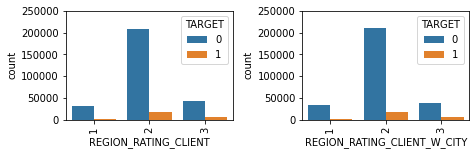

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']):
    plt.subplot(5, 3, i+1, ylim=(0, 250000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
application_data[['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   REGION_RATING_CLIENT         307511 non-null  int8 
 1   REGION_RATING_CLIENT_W_CITY  307511 non-null  int8 
dtypes: int8(2)
memory usage: 600.7 KB


In [ ]:
application_data['REGION_RATING_CLIENT'].value_counts()

2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64

In [ ]:
application_data['REGION_RATING_CLIENT_W_CITY'].value_counts()

2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

In [ ]:
value_wise_defaulter_percentage(application_data, 'REGION_RATING_CLIENT')

,Value,Percentage of Defaulter
2,3.0,11.102835
0,2.0,7.889102
1,1.0,4.820325


In [ ]:
value_wise_defaulter_percentage(application_data, 'REGION_RATING_CLIENT_W_CITY')

,Value,Percentage of Defaulter
2,3.0,11.402189
0,2.0,7.917763
1,1.0,4.840928


**Observation and action:**

1) Most of the applicant comes under the category 2 of REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY.

2) Default percentage is higher for category 3 for feature REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY.

## **HOUR_APPR_PROCESS_START**

In [ ]:
application_data['HOUR_APPR_PROCESS_START'].value_counts()

10    37722
11    37229
12    34233
13    30959
14    27682
9     27384
15    24839
16    20385
8     15127
17    14900
7      9131
18     9049
6      5842
19     3848
5      3638
4      2090
3      1230
20     1196
21      405
2       305
22      150
1        86
23       41
0        40
Name: HOUR_APPR_PROCESS_START, dtype: int64

In [ ]:
application_data[['HOUR_APPR_PROCESS_START']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   HOUR_APPR_PROCESS_START  307511 non-null  int8 
dtypes: int8(1)
memory usage: 300.4 KB


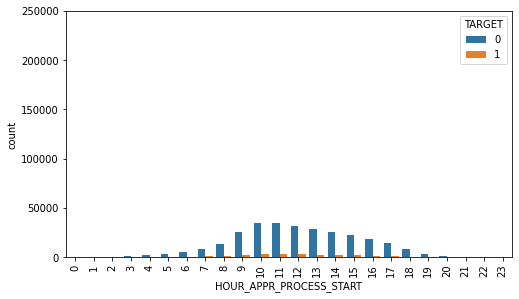

In [ ]:
fig=plt.subplots(figsize=(20, 20))

for i, j in enumerate(['HOUR_APPR_PROCESS_START']):
    plt.subplot(5, 3, i+1, ylim=(0, 250000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
value_wise_defaulter_percentage(application_data, 'HOUR_APPR_PROCESS_START')

,Value,Percentage of Defaulter
23,0.0,15.000000
22,23.0,12.195122
10,6.0,11.040739
17,5.0,10.582738
8,7.0,10.042712
19,22.0,10.000000
21,2.0,9.836066
6,8.0,9.076486
13,3.0,8.699187
16,4.0,8.277512


**Observation and action:**

1) Most of the applicant has application process start hour is 10:00.This feature does not shows any visible impact on TARGET variable

In [ ]:
# Dropping the column as new column will be used for analysis

application_data.drop(labels='HOUR_APPR_PROCESS_START', inplace=True, axis=1)

In [ ]:
application_data.shape

(307511, 41)

## **REG_REGION_NOT_WORK_REGION**

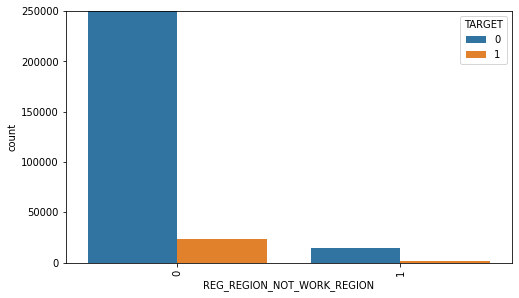

In [ ]:
fig=plt.subplots(figsize=(20, 20))

for i, j in enumerate(['REG_REGION_NOT_WORK_REGION']):
    plt.subplot(5, 3, i+1, ylim=(0, 250000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
application_data['REG_REGION_NOT_WORK_REGION'].value_counts()

0    291899
1     15612
Name: REG_REGION_NOT_WORK_REGION, dtype: int64

In [ ]:
application_data[['REG_REGION_NOT_WORK_REGION']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   REG_REGION_NOT_WORK_REGION  307511 non-null  int8 
dtypes: int8(1)
memory usage: 300.4 KB


In [ ]:
value_wise_defaulter_percentage(application_data, 'REG_REGION_NOT_WORK_REGION')

,Value,Percentage of Defaulter
1,1.0,8.890597
0,0.0,8.029147


**Observation and action:**

1) Most of the applicant comes under the category 0 of REG_REGION_NOT_WORK_REGION.

2) Default percentage is nearly similar for both of the category.

##**REG_CITY Feature**

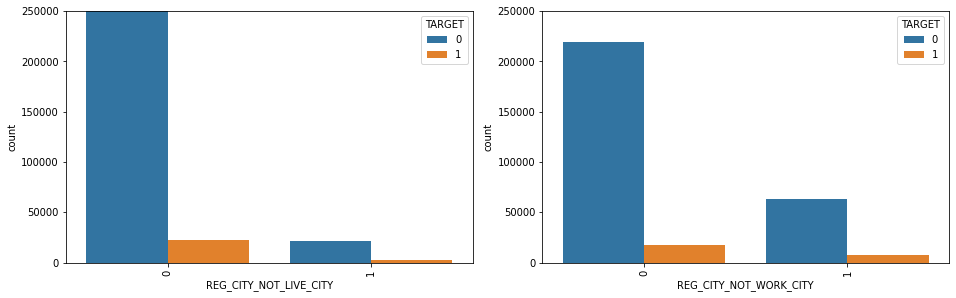

In [ ]:
fig=plt.subplots(figsize=(20, 20))

for i, j in enumerate(['REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY']):
    plt.subplot(5, 3, i+1, ylim=(0, 250000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
application_data[['REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   REG_CITY_NOT_LIVE_CITY  307511 non-null  int8 
 1   REG_CITY_NOT_WORK_CITY  307511 non-null  int8 
dtypes: int8(2)
memory usage: 600.7 KB


In [ ]:
application_data['REG_CITY_NOT_LIVE_CITY'].value_counts()

0    283472
1     24039
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64

In [ ]:
application_data['REG_CITY_NOT_WORK_CITY'].value_counts()

0    236644
1     70867
Name: REG_CITY_NOT_WORK_CITY, dtype: int64

In [ ]:
value_wise_defaulter_percentage(application_data, 'REG_CITY_NOT_LIVE_CITY')

,Value,Percentage of Defaulter
1,1.0,12.225966
0,0.0,7.720692


In [ ]:
value_wise_defaulter_percentage(application_data, 'REG_CITY_NOT_WORK_CITY')

,Value,Percentage of Defaulter
1,1.0,10.611427
0,0.0,7.312672


**Observation and action:**

1) Most of the applicant comes under the category 1 of REG_CITY_NOT_LIVE_CITY and REG_CITY_NOT_WORK_CITY.

2) Default percentage is high for category 1 for both the features.

## **CREDIT_BUREAU features**(Still very confusion in the feature)

In [ ]:
feature_CREDIT_BUREAU=[features for features in application_data.columns if 'CREDIT_BUREAU' in features]

In [ ]:
feature_CREDIT_BUREAU

['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
start_idx = application_data.columns.get_loc('AMT_REQ_CREDIT_BUREAU_HOUR')
end_idx = application_data.columns.get_loc('AMT_REQ_CREDIT_BUREAU_YEAR')

CREDIT_BUREAU_df = application_data.iloc[:, start_idx:end_idx+1]

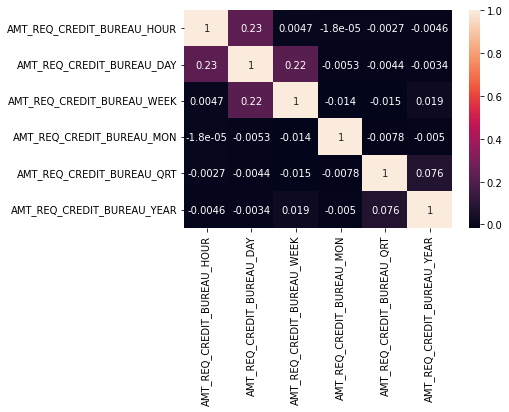

In [ ]:
sns.heatmap(CREDIT_BUREAU_df.corr(), annot=True)

Here we are getting the correlation of the feature as a negative so first we will replace the missing value then again try to findout it

In [ ]:
application_data_Miss = missingdata_percentage(application_data[feature_CREDIT_BUREAU],0)
application_data_Miss

,category,percentage
0,AMT_REQ_CREDIT_BUREAU_HOUR,13.501631
1,AMT_REQ_CREDIT_BUREAU_DAY,13.501631
2,AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
3,AMT_REQ_CREDIT_BUREAU_MON,13.501631
4,AMT_REQ_CREDIT_BUREAU_QRT,13.501631
5,AMT_REQ_CREDIT_BUREAU_YEAR,13.501631


In [ ]:
application_data[feature_CREDIT_BUREAU].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_REQ_CREDIT_BUREAU_HOUR  265992 non-null  float16
 1   AMT_REQ_CREDIT_BUREAU_DAY   265992 non-null  float16
 2   AMT_REQ_CREDIT_BUREAU_WEEK  265992 non-null  float16
 3   AMT_REQ_CREDIT_BUREAU_MON   265992 non-null  float16
 4   AMT_REQ_CREDIT_BUREAU_QRT   265992 non-null  float16
 5   AMT_REQ_CREDIT_BUREAU_YEAR  265992 non-null  float16
dtypes: float16(6)
memory usage: 3.5 MB


In [ ]:
application_data['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()

0.0     71801
1.0     63405
2.0     50192
3.0     33628
4.0     20714
5.0     12052
6.0      6967
7.0      3869
8.0      2127
9.0      1096
11.0       31
12.0       30
10.0       22
13.0       19
14.0       10
17.0        7
15.0        6
19.0        4
18.0        4
16.0        3
25.0        1
23.0        1
22.0        1
21.0        1
20.0        1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

In [ ]:
print(application_data.shape)
application_data[feature_CREDIT_BUREAU].isna().sum()

(307511, 41)


AMT_REQ_CREDIT_BUREAU_HOUR    41519
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
dtype: int64

In [ ]:
# Replacing the missing colums with the most frequent category
for i in feature_CREDIT_BUREAU:
  print(i)
  application_data[i] = application_data[i].fillna(application_data[i].mode()[0])

AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_YEAR


In [ ]:
application_data[feature_CREDIT_BUREAU].isna().sum()

AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
dtype: int64

In [ ]:
for j,i in enumerate(feature_CREDIT_BUREAU):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in AMT_REQ_CREDIT_BUREAU_HOUR features is:

 0.0    305885
1.0      1560
2.0        56
3.0         9
4.0         1
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: int64 

 2) value_counts in AMT_REQ_CREDIT_BUREAU_DAY features is:

 0.0    306022
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64 

 3) value_counts in AMT_REQ_CREDIT_BUREAU_WEEK features is:

 0.0    298975
1.0      8208
2.0       199
3.0        58
4.0        34
6.0        20
5.0        10
8.0         5
7.0         2
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: int64 

 4) value_counts in AMT_REQ_CREDIT_BUREAU_MON features is:

 0.0     263752
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
9.0        206
8.0        185
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6


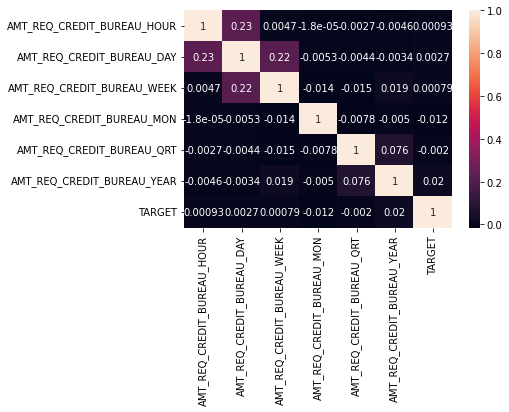

In [ ]:
CREDIT_BUREAU_df['TARGET'] = application_data["TARGET"]
sns.heatmap(CREDIT_BUREAU_df.corr(), annot=True)

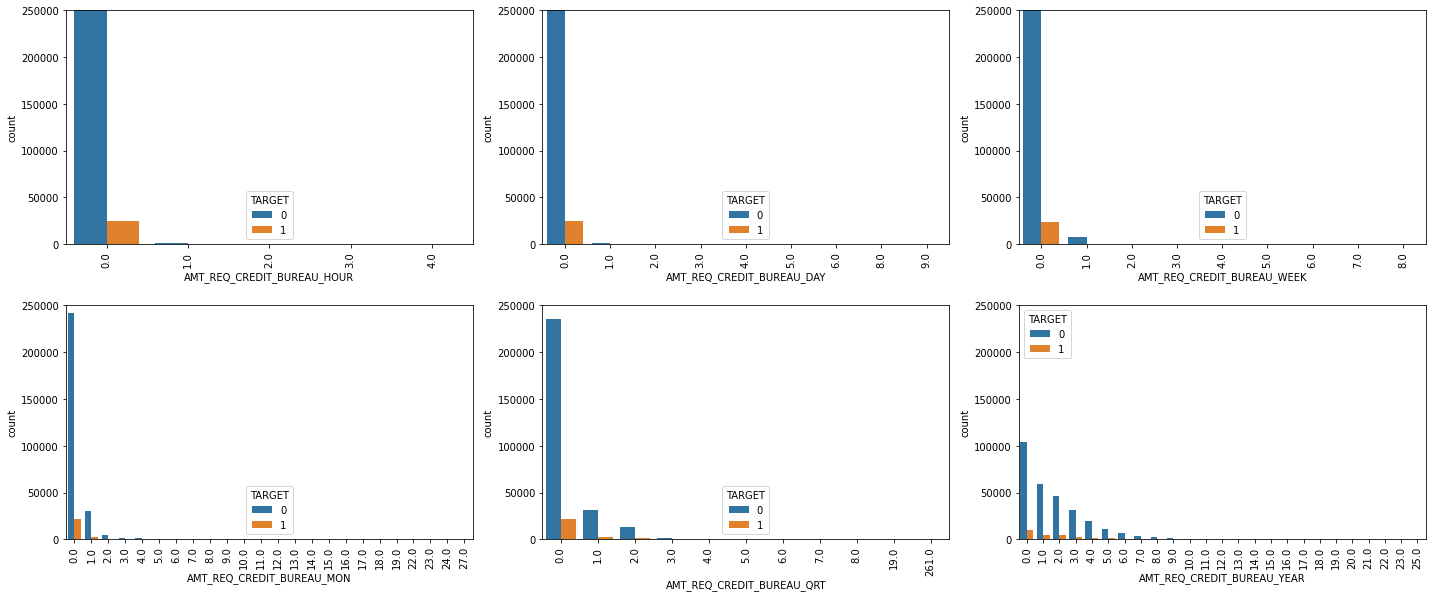

In [ ]:
fig=plt.subplots(figsize=(20, 20))

for i, j in enumerate(feature_CREDIT_BUREAU):
    plt.subplot(5, 3, i+1, ylim=(0, 250000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
for i in feature_CREDIT_BUREAU:
  print("For feature {}:".format(i))
  print(value_wise_defaulter_percentage(application_data, i))

For feature AMT_REQ_CREDIT_BUREAU_HOUR:
   Value  Percentage of Defaulter
2    2.0                10.714286
0    0.0                 8.072969
1    1.0                 8.012821
3    3.0                 0.000000
4    4.0                 0.000000
For feature AMT_REQ_CREDIT_BUREAU_DAY:
   Value  Percentage of Defaulter
4    4.0                11.538462
3    2.0                10.377358
1    1.0                 9.674923
0    0.0                 8.066087
2    3.0                 4.444444
5    5.0                 0.000000
6    6.0                 0.000000
7    9.0                 0.000000
8    8.0                 0.000000
For feature AMT_REQ_CREDIT_BUREAU_WEEK:
   Value  Percentage of Defaulter
4    4.0                11.764706
3    2.0                10.050251
5    5.0                10.000000
0    0.0                 8.079940
1    1.0                 7.772904
2    3.0                 6.896552
6    6.0                 5.000000
7    8.0                 0.000000
8    7.0                 0.0000

## **Rest of the features**

In [ ]:
Year_fea=[feature for feature in discrete_feature if 'YEAR' in feature]
Year_fea

['YEAR_ID_PUBLISH', 'YEAR_LAST_PHONE_CHANGE']

In [ ]:
application_data[Year_fea].head(20)

,YEAR_ID_PUBLISH,YEAR_LAST_PHONE_CHANGE
0,5,3.0
1,0,2.0
2,6,2.0
3,6,1.0
4,9,3.0
5,1,6.0
6,1,4.0
7,6,2.0
8,9,-0.0
9,10,4.0


In [ ]:
# Replacing the -0.0 in YEAR_LAST_PHONE_CHANGE with 0.0.
application_data.YEAR_LAST_PHONE_CHANGE.replace(-0.0, 0.0, inplace=True)

In [ ]:
application_data[Year_fea].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   YEAR_ID_PUBLISH         307511 non-null  int16  
 1   YEAR_LAST_PHONE_CHANGE  307510 non-null  float32
dtypes: float32(1), int16(1)
memory usage: 1.8 MB


In [ ]:
application_data[Year_fea].value_counts()

YEAR_ID_PUBLISH  YEAR_LAST_PHONE_CHANGE
11               0.0                       13057
12               0.0                       11349
11               1.0                        7088
10               0.0                        6306
11               4.0                        6161
                                           ...  
9                11.0                          1
17               6.0                           1
10               11.0                          1
17               8.0                           1
19               2.0                           1
Length: 210, dtype: int64

In [ ]:
application_data['YEAR_LAST_PHONE_CHANGE'] = application_data['YEAR_LAST_PHONE_CHANGE'].fillna(application_data['YEAR_LAST_PHONE_CHANGE'].mode()[0])

In [ ]:
application_data[Year_fea].isna().sum()

YEAR_ID_PUBLISH           0
YEAR_LAST_PHONE_CHANGE    0
dtype: int64

In [ ]:
application_data[Year_fea].describe()

,YEAR_ID_PUBLISH,YEAR_LAST_PHONE_CHANGE
count,307511.000000,307511.000000
mean,7.713474,2.225133
std,4.134515,2.193951
min,0.000000,0.000000
25%,4.000000,0.000000
50%,8.000000,2.000000
75%,11.000000,4.000000
max,19.000000,11.000000


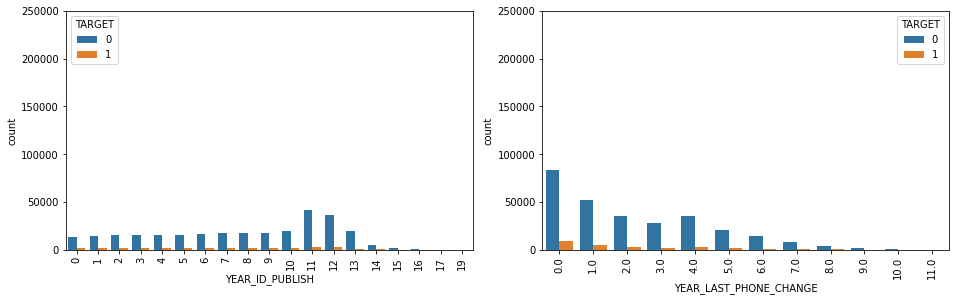

In [ ]:
fig=plt.subplots(figsize=(20, 20))

for i, j in enumerate(Year_fea):
    plt.subplot(5, 3, i+1, ylim=(0, 250000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
for i in Year_fea:
  print("For feature {}:".format(i))
  print(value_wise_defaulter_percentage(application_data, i))

For feature YEAR_ID_PUBLISH:
    Value  Percentage of Defaulter
1     0.0                10.417924
6     2.0                 9.961465
4     1.0                 9.931766
9     3.0                 9.558694
10    4.0                 9.544194
2     6.0                 8.962674
0     5.0                 8.853470
11    7.0                 8.795550
5    10.0                 8.146133
7     8.0                 8.083190
3     9.0                 7.653433
14   14.0                 7.064137
13   11.0                 6.935032
12   12.0                 6.187604
16   15.0                 5.826218
8    13.0                 5.704975
15   16.0                 5.064782
17   17.0                 2.631579
18   19.0                 0.000000
For feature YEAR_LAST_PHONE_CHANGE:
    Value  Percentage of Defaulter
5     0.0                 9.576862
2     1.0                 9.304141
1     2.0                 8.257993
0     3.0                 7.073407
11   11.0                 6.896552
4     4.0                

**Observation and action:**

1) Most of the applicant has YEAR_ID_PUBLISH and YEAR_LAST_PHONE_CHANGE as 11 and 0 respectively.

2) Default percentage for YEAR_ID_PUBLISH and YEAR_LAST_PHONE_CHANGE equal to  0 is highest one.

#**Continuous Variable**

In [ ]:
continuous_feature=[feature for feature in All_numerical_features if feature not in discrete_feature+['SK_ID_CURR']]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 13


In [ ]:
continuous_feature

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'Age',
 'YEAR_EMPLOYED',
 'YEAR_REGISTRATION']

In [ ]:
application_data[continuous_feature].head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,Age,YEAR_EMPLOYED,YEAR_REGISTRATION
0,202500.0,406597.5,24700.5,351000.0,0.018799,0.262939,0.139404,2.0,0.0,1.0,25,1,9.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003542,0.622070,NaN,1.0,0.0,0.0,45,3,3.0
2,67500.0,135000.0,6750.0,135000.0,0.010033,0.556152,0.729492,0.0,0.0,0.0,52,0,11.0
3,135000.0,312682.5,29686.5,297000.0,0.008018,0.650391,NaN,2.0,0.0,0.0,52,8,26.0
4,121500.0,513000.0,21865.5,513000.0,0.028656,0.322754,NaN,0.0,0.0,0.0,54,8,11.0


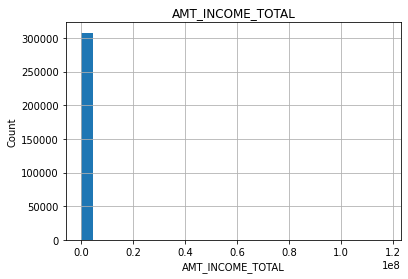

The Skewness of the continous features AMT_INCOME_TOTAL is: 391.5577697753906 


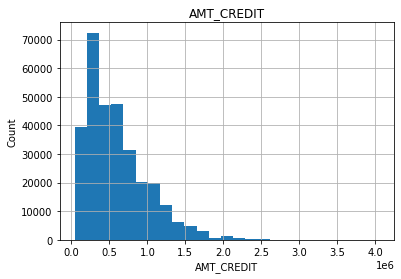

The Skewness of the continous features AMT_CREDIT is: 1.234772801399231 


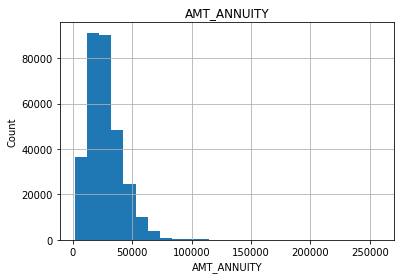

The Skewness of the continous features AMT_ANNUITY is: nan 


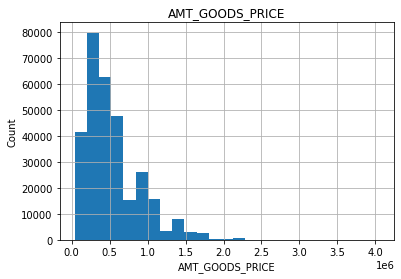

The Skewness of the continous features AMT_GOODS_PRICE is: nan 


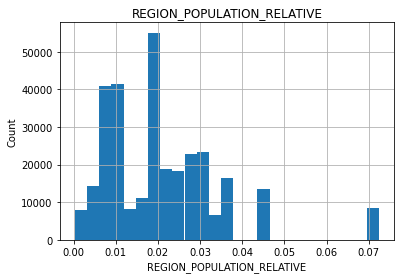

The Skewness of the continous features REGION_POPULATION_RELATIVE is: 1.5 


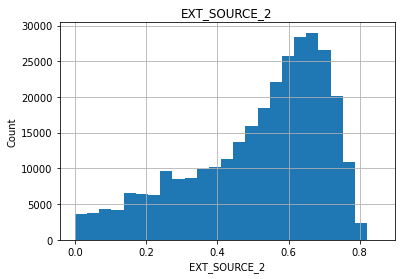

The Skewness of the continous features EXT_SOURCE_2 is: nan 


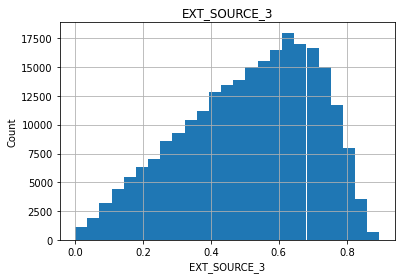

The Skewness of the continous features EXT_SOURCE_3 is: nan 


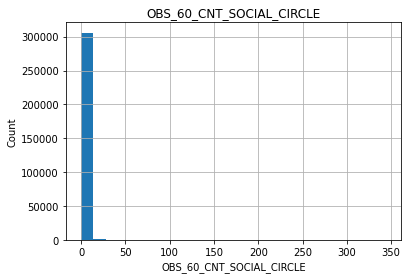

The Skewness of the continous features OBS_60_CNT_SOCIAL_CIRCLE is: nan 


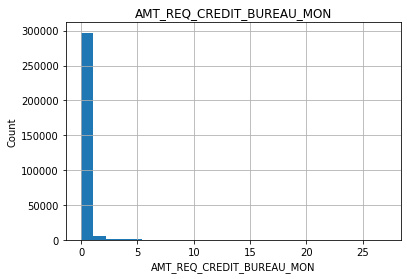

The Skewness of the continous features AMT_REQ_CREDIT_BUREAU_MON is: 8.3671875 


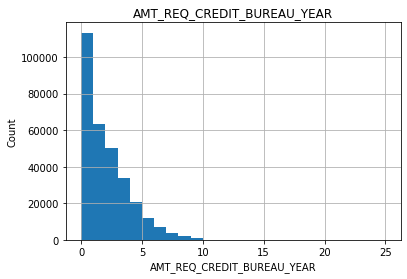

The Skewness of the continous features AMT_REQ_CREDIT_BUREAU_YEAR is: 1.3701171875 


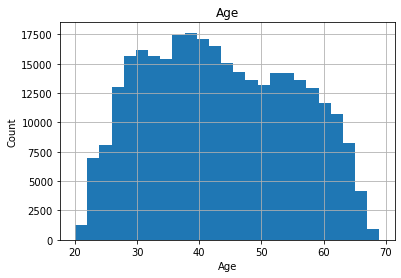

The Skewness of the continous features Age is: 0.1162264239279713 


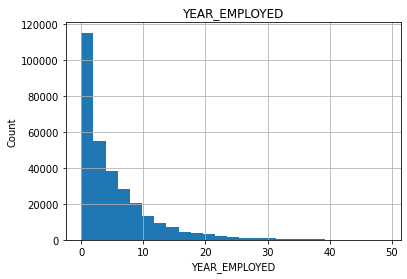

The Skewness of the continous features YEAR_EMPLOYED is: 2.201988643842374 


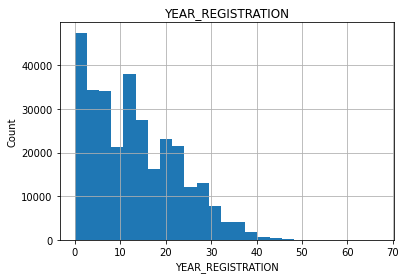

The Skewness of the continous features YEAR_REGISTRATION is: 0.5933796167373657 


In [ ]:
## Lets analyse the continuous values by creating histograms to understand the distribution
from scipy.stats import skew
for feature in continuous_feature:
    data=application_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()
    print("The Skewness of the continous features {} is: {} " .format(feature,skew(data[feature])))

## **Amount Realted Features**

In [ ]:
AMT_Cont_Fea=['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

In [ ]:
application_data[AMT_Cont_Fea].head(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
0,202500.0,406597.5,24700.5,351000.0
1,270000.0,1293502.5,35698.5,1129500.0
2,67500.0,135000.0,6750.0,135000.0
3,135000.0,312682.5,29686.5,297000.0
4,121500.0,513000.0,21865.5,513000.0
5,99000.0,490495.5,27517.5,454500.0
6,171000.0,1560726.0,41301.0,1395000.0
7,360000.0,1530000.0,42075.0,1530000.0
8,112500.0,1019610.0,33826.5,913500.0
9,135000.0,405000.0,20250.0,405000.0


In [ ]:
application_data[AMT_Cont_Fea].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AMT_INCOME_TOTAL  307511 non-null  float32
 1   AMT_CREDIT        307511 non-null  float32
 2   AMT_ANNUITY       307499 non-null  float32
 3   AMT_GOODS_PRICE   307233 non-null  float32
dtypes: float32(4)
memory usage: 4.7 MB


In [ ]:
application_data[AMT_Cont_Fea].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05
mean,1.687391e+05,5.988308e+05,27110.958984,5.379796e+05
std,2.371759e+05,4.024795e+05,14493.233398,3.695427e+05
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06


In [ ]:
#Missing value features percentage
AMT_Cont_Fea_Miss = missingdata_percentage(application_data[AMT_Cont_Fea],0)
AMT_Cont_Fea_Miss

,category,percentage
0,AMT_ANNUITY,0.003902
1,AMT_GOODS_PRICE,0.090403


In [ ]:
#No. of missing value
application_data[AMT_Cont_Fea].isna().sum()

AMT_INCOME_TOTAL      0
AMT_CREDIT            0
AMT_ANNUITY          12
AMT_GOODS_PRICE     278
dtype: int64

In [ ]:
application_data['AMT_ANNUITY'].fillna(application_data['AMT_ANNUITY'].median(),inplace = True)

In [ ]:
application_data['AMT_GOODS_PRICE'].fillna(application_data['AMT_GOODS_PRICE'].median(),inplace = True)

In [ ]:
#Post imputation the value of missing features
application_data[AMT_Cont_Fea].isna().sum()

AMT_INCOME_TOTAL    0
AMT_CREDIT          0
AMT_ANNUITY         0
AMT_GOODS_PRICE     0
dtype: int64

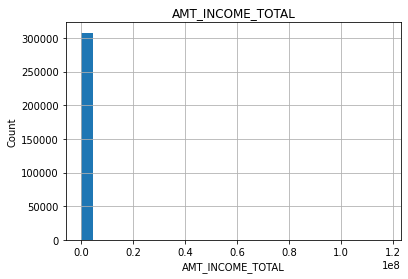

The Skewness of the continous features AMT_INCOME_TOTAL is: 391.5577697753906 


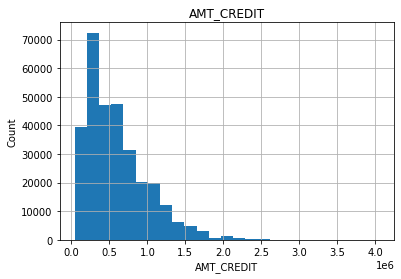

The Skewness of the continous features AMT_CREDIT is: 1.234772801399231 


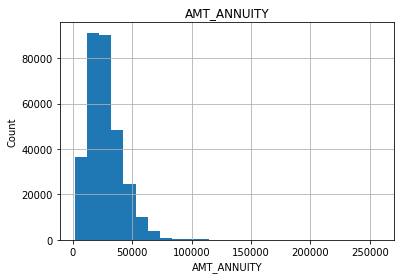

The Skewness of the continous features AMT_ANNUITY is: 1.5798168182373047 


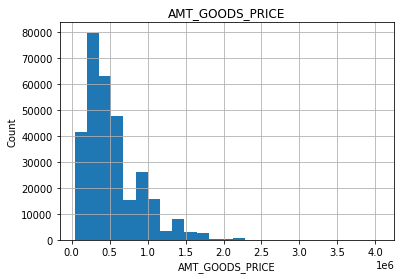

The Skewness of the continous features AMT_GOODS_PRICE is: 1.3501369953155518 


In [ ]:
from scipy.stats import skew
for feature in AMT_Cont_Fea:
    data=application_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()
    print("The Skewness of the continous features {} is: {} " .format(feature,skew(data[feature])))

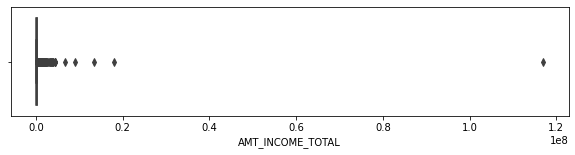

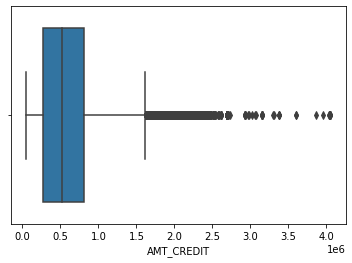

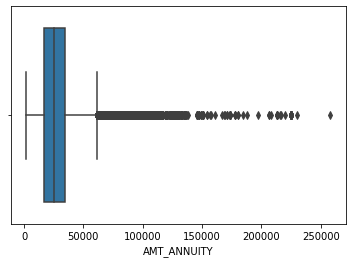

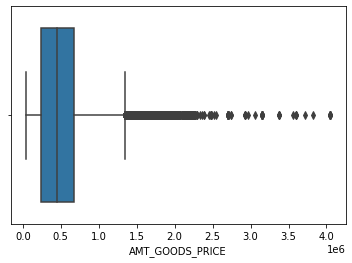

In [ ]:
"""plt.figure(figsize=(10,2))
sns.boxplot(application_data[AMT_Cont_Fea])
plt.show()"""
fig=plt.subplots(figsize=(10, 2))

for i, j in enumerate(AMT_Cont_Fea):
    sns.boxplot(application_data[j])
    plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile

for i in AMT_Cont_Fea:
  application_data = application_data[application_data[i] < np.nanpercentile(application_data[i], 99)]

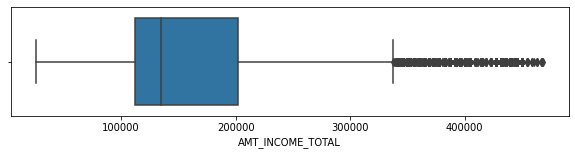

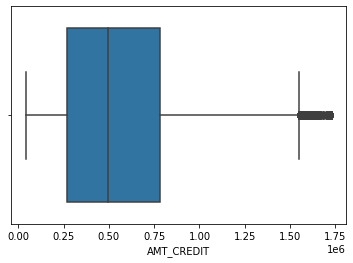

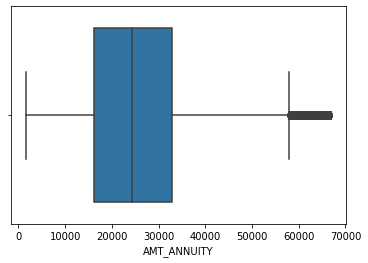

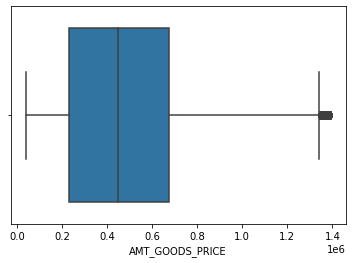

In [ ]:
# Post Outlier remove the boxplot.

fig=plt.subplots(figsize=(10, 2))

for i, j in enumerate(AMT_Cont_Fea):
    sns.boxplot(application_data[j])
    plt.show()

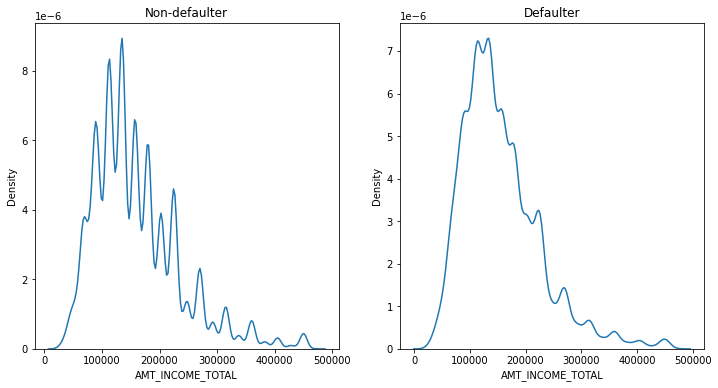

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['AMT_INCOME_TOTAL'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['AMT_INCOME_TOTAL'], ax=ax2)

plt.show()

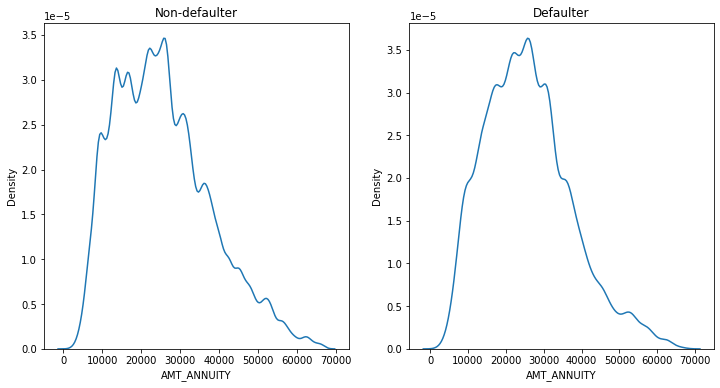

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['AMT_ANNUITY'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['AMT_ANNUITY'], ax=ax2)

plt.show()

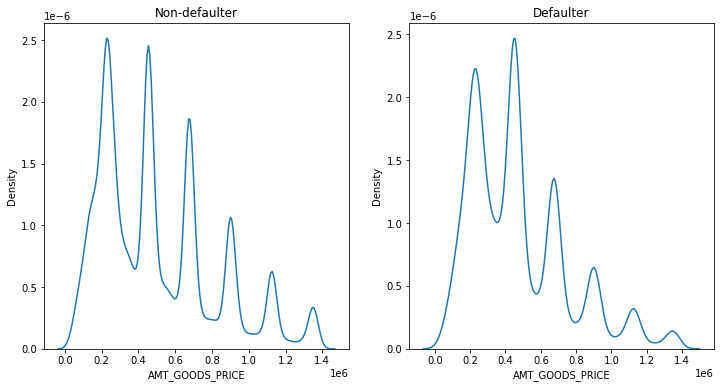

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['AMT_GOODS_PRICE'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['AMT_GOODS_PRICE'], ax=ax2)

plt.show()

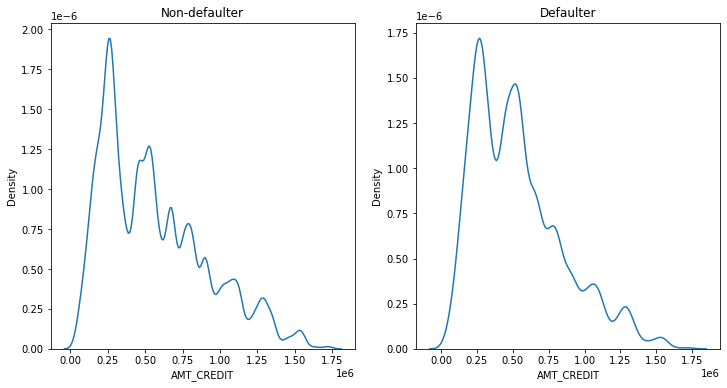

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['AMT_CREDIT'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['AMT_CREDIT'], ax=ax2)

plt.show()

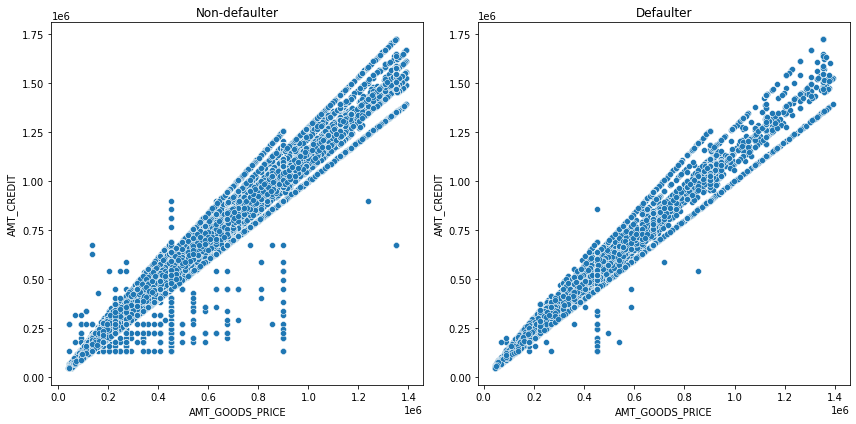

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.scatterplot(application_data[application_data["TARGET"] == 0]['AMT_GOODS_PRICE'], application_data[application_data["TARGET"] == 0]['AMT_CREDIT'], ax=ax1)
sns.scatterplot(application_data[application_data["TARGET"] == 1]['AMT_GOODS_PRICE'], application_data[application_data["TARGET"] == 1]['AMT_CREDIT'], ax=ax2)

plt.tight_layout()
plt.show()

**Observation and action:**

1) In 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY' and 'AMT_GOODS_PRICE' to avoide the impact of outlier we have considered the value only upto the 99 percentile.

2) 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY' and 'AMT_GOODS_PRICE' is following the same distribution for both Defaulter and Non-defaulter.

3) AMT_CREDIT and AMT_GOODS_PRICE has the linear relationship for both in Defaulter and Non-defaulter case. Also, plot shows the number of Defaulter is less at the lower range.

## **REGION_POPULATION_RELATIVE**

In [ ]:
application_data['REGION_POPULATION_RELATIVE'].head()

0    0.018799
1    0.003542
2    0.010033
3    0.008018
4    0.028656
Name: REGION_POPULATION_RELATIVE, dtype: float16

In [ ]:
application_data['REGION_POPULATION_RELATIVE'].describe()

count    294481.000000
mean          0.020569
std           0.013428
min           0.000290
25%           0.010010
50%           0.018845
75%           0.028656
max           0.072510
Name: REGION_POPULATION_RELATIVE, dtype: float64

In [ ]:
application_data['REGION_POPULATION_RELATIVE'].fillna(application_data['REGION_POPULATION_RELATIVE'].median(),inplace = True)

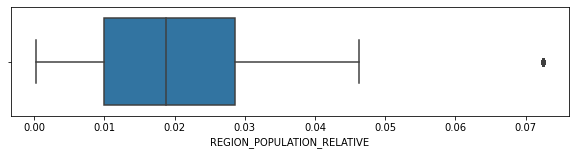

In [ ]:
# Post Outlier remove the boxplot.

fig=plt.subplots(figsize=(10, 2))
sns.boxplot(application_data['REGION_POPULATION_RELATIVE'])
plt.show()

In [ ]:
application_data = application_data[application_data['REGION_POPULATION_RELATIVE'] < np.nanpercentile(application_data['REGION_POPULATION_RELATIVE'], 99)]

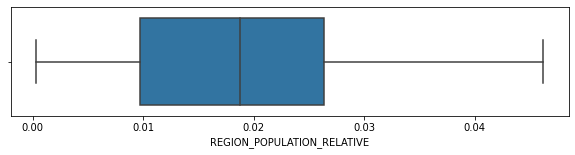

In [ ]:
fig=plt.subplots(figsize=(10, 2))
sns.boxplot(application_data['REGION_POPULATION_RELATIVE'])
plt.show()

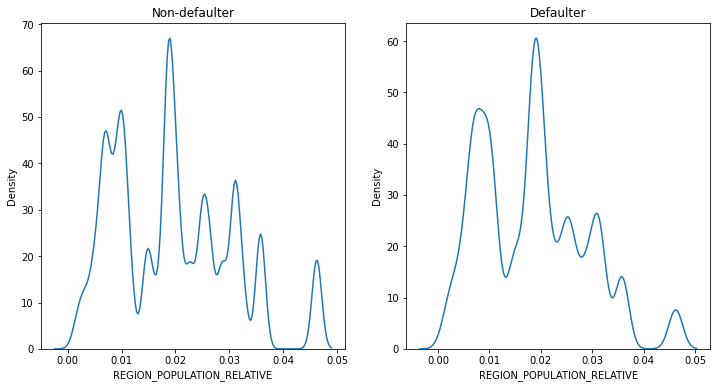

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['REGION_POPULATION_RELATIVE'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['REGION_POPULATION_RELATIVE'], ax=ax2)

plt.show()

**Observation and action:**

1) In REGION_POPULATION_RELATIVE to avoide the impact of outlier we have considered the value only upto the 99 percentile.

2) REGION_POPULATION_RELATIVE is following the same distribution for both Defaulter and Non-defaulter.

## **Ext_Source Features**

In [ ]:
EXT_SOURCE_Fea=[ 'EXT_SOURCE_2','EXT_SOURCE_3']

In [ ]:
application_data[EXT_SOURCE_Fea].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287467 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   EXT_SOURCE_2  286839 non-null  float16
 1   EXT_SOURCE_3  230554 non-null  float16
dtypes: float16(2)
memory usage: 3.3 MB


In [ ]:
application_data[EXT_SOURCE_Fea].describe()

,EXT_SOURCE_2,EXT_SOURCE_3
count,2.868390e+05,230554.000000
mean,NaN,NaN
std,0.000000e+00,0.000000
min,5.960464e-08,0.000527
25%,3.820801e-01,0.368896
50%,5.585938e-01,0.535156
75%,6.572266e-01,0.667480
max,8.549805e-01,0.895996


In [ ]:
application_data[EXT_SOURCE_Fea].isna().sum()

EXT_SOURCE_2      628
EXT_SOURCE_3    56913
dtype: int64

In [ ]:
application_data['EXT_SOURCE_2'].fillna(application_data['EXT_SOURCE_2'].median(),inplace = True)

In [ ]:
application_data['EXT_SOURCE_3'].fillna(application_data['EXT_SOURCE_3'].median(),inplace = True)

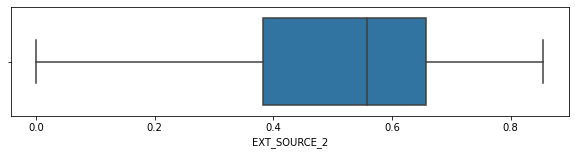

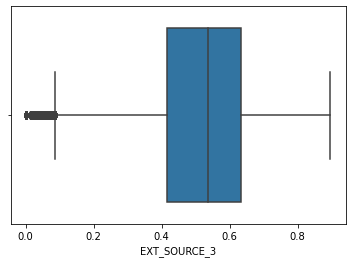

In [ ]:
fig=plt.subplots(figsize=(10, 2))
for i in EXT_SOURCE_Fea:
  sns.boxplot(application_data[i])
  plt.show()

In [ ]:
application_data = application_data[application_data['EXT_SOURCE_3'] < np.nanpercentile(application_data['EXT_SOURCE_3'], 99)]

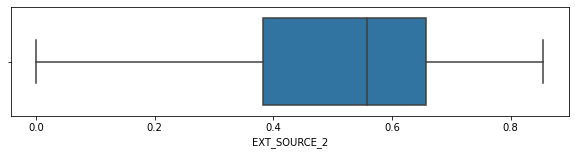

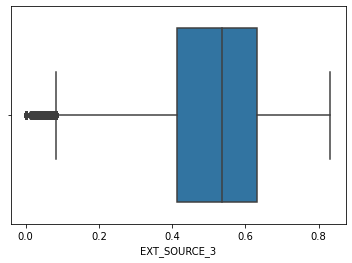

In [ ]:
fig=plt.subplots(figsize=(10, 2))
for i in EXT_SOURCE_Fea:
  sns.boxplot(application_data[i])
  plt.show()

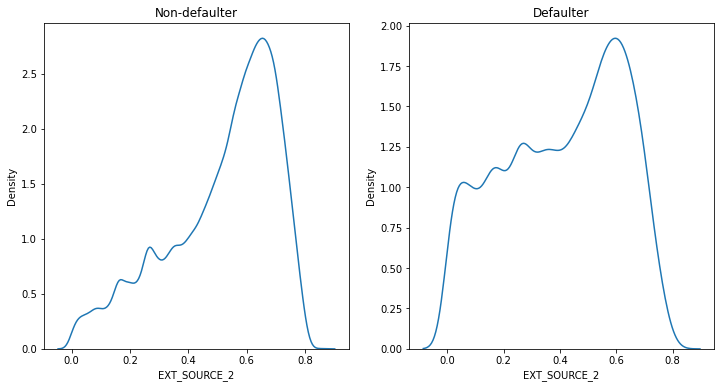

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['EXT_SOURCE_2'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['EXT_SOURCE_2'], ax=ax2)

plt.show()

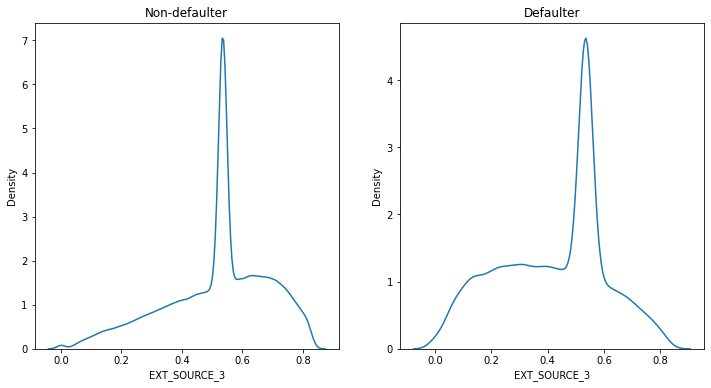

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['EXT_SOURCE_3'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['EXT_SOURCE_3'], ax=ax2)

plt.show()

**Observation and action:**

1) In EXT_SOURCE_3 and EXT_SOURCE_2 to avoide the impact of outlier we have considered the value only upto the 99 percentile.

2) EXT_SOURCE_3 and EXT_SOURCE_2 is following the different distribution for both Defaulter and Non-defaulter.

## **OBS_60_CNT_SOCIAL_CIRCLE**


In [ ]:
application_data['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      150426
1.0       45632
2.0       27923
3.0       18998
4.0       13187
5.0        8962
6.0        5957
7.0        4087
8.0        2715
9.0        1838
10.0       1265
11.0        799
12.0        590
13.0        384
14.0        225
15.0        155
16.0        128
17.0         65
18.0         48
19.0         42
20.0         29
21.0         25
22.0         18
24.0         12
23.0         11
25.0         10
27.0          5
29.0          2
28.0          1
47.0          1
344.0         1
30.0          1
26.0          1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

In [ ]:
application_data['OBS_60_CNT_SOCIAL_CIRCLE'].describe()

count    283543.0
mean          NaN
std           NaN
min           0.0
25%           0.0
50%           0.0
75%           2.0
max         344.0
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

In [ ]:
application_data.shape

(284383, 41)

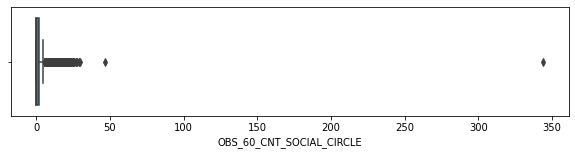

In [ ]:
fig=plt.subplots(figsize=(10, 2))
sns.boxplot(application_data['OBS_60_CNT_SOCIAL_CIRCLE'])
plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile
application_data = application_data[application_data['OBS_60_CNT_SOCIAL_CIRCLE'] < np.nanpercentile(application_data['OBS_60_CNT_SOCIAL_CIRCLE'], 99)]

In [ ]:
#Repalcing the nan values with most freaquent category
application_data['OBS_60_CNT_SOCIAL_CIRCLE'] = application_data['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(application_data['OBS_60_CNT_SOCIAL_CIRCLE'].mode()[0])

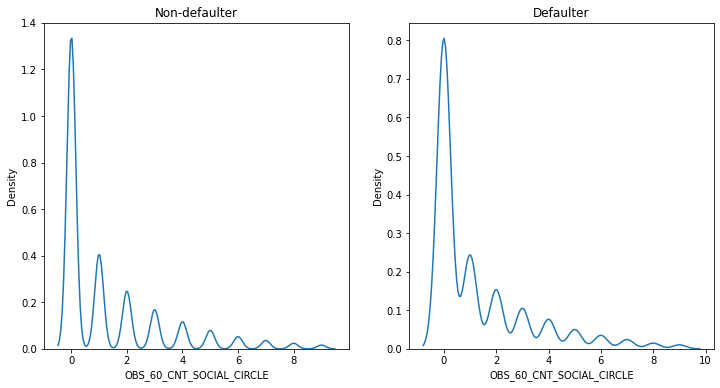

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax2)

plt.show()

**Observation and action:**

1) In OBS_60_CNT_SOCIAL_CIRCLE to avoide the impact of outlier we have considered the value only upto the 99 percentile.

2) OBS_60_CNT_SOCIAL_CIRCLE is following the same distribution for both Defaulter and Non-defaulter.

3) Post removal of the some outlier the feature act as a decreate numerical feature so mode is prefer for imputation than the median 

## **AMT Realted Feature**

In [ ]:
Amt_feature=[ 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
application_data[Amt_feature].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279725 entries, 0 to 307510
Data columns (total 2 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_REQ_CREDIT_BUREAU_MON   279725 non-null  float16
 1   AMT_REQ_CREDIT_BUREAU_YEAR  279725 non-null  float16
dtypes: float16(2)
memory usage: 3.2 MB


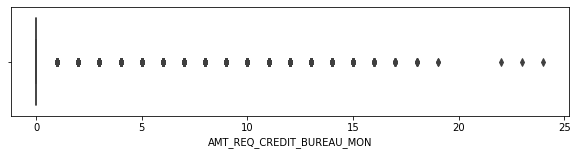

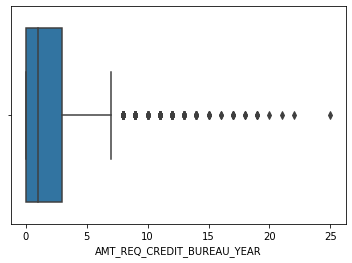

In [ ]:
fig=plt.subplots(figsize=(10, 2))
for i in Amt_feature:
  sns.boxplot(application_data[i])
  plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile
for i in Amt_feature:
  application_data = application_data[application_data[i] < np.nanpercentile(application_data[i], 99)]

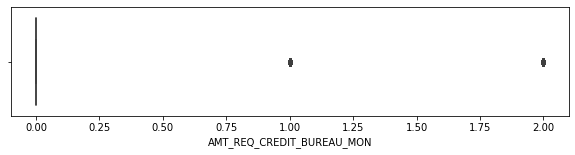

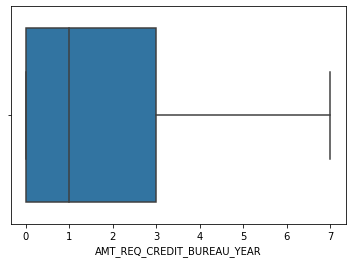

In [ ]:
fig=plt.subplots(figsize=(10, 2))
for i in Amt_feature:
  sns.boxplot(application_data[i])
  plt.show()

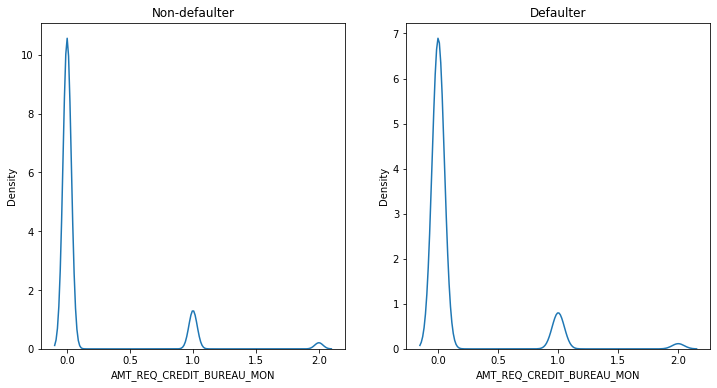

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax2)

plt.show()

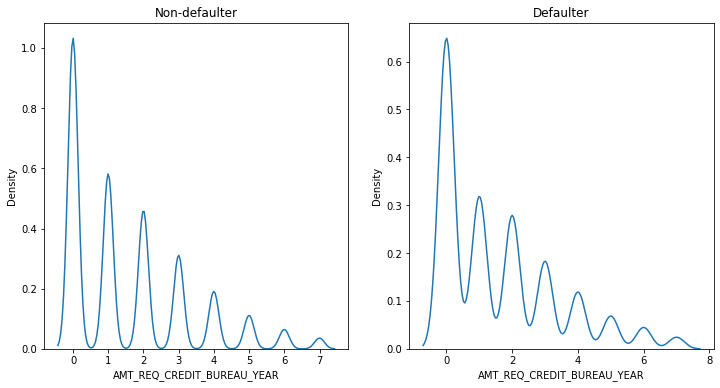

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(application_data[application_data["TARGET"] == 0]['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax1)
sns.kdeplot(application_data[application_data["TARGET"] == 1]['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax2)

plt.show()

**Observation and action:**

1) In 'AMT_REQ_CREDIT_BUREAU_MON' and 'AMT_REQ_CREDIT_BUREAU_YEAR' to avoid the impact of outlier we have considered the value only upto the 99 percentile.

2) 'AMT_REQ_CREDIT_BUREAU_MON' and 'AMT_REQ_CREDIT_BUREAU_YEAR' is following the same distribution for both Defaulter and Non-defaulter.

## **Year Related Feature**

In [ ]:
Yr_feature=['Age','YEAR_EMPLOYED','YEAR_REGISTRATION']

In [ ]:
application_data[Yr_feature].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272279 entries, 0 to 307510
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                272279 non-null  int16  
 1   YEAR_EMPLOYED      272279 non-null  int64  
 2   YEAR_REGISTRATION  272279 non-null  float32
dtypes: float32(1), int16(1), int64(1)
memory usage: 5.7 MB


In [ ]:
application_data['YEAR_EMPLOYED'].value_counts()# need to replace the outlier value -1001 with other category

1     77980
2     26622
0     25055
3     22426
4     19338
5     14274
6     13254
7     11530
8     10011
9      7779
10     6378
11     5058
12     4588
14     3981
13     3730
15     2348
16     2001
17     1712
18     1637
19     1630
20     1386
21     1272
22     1085
23      893
24      806
25      733
27      585
26      572
28      533
29      502
30      399
31      381
34      307
32      297
33      293
35      219
36      166
37      117
39      109
38       95
40       49
41       49
42       37
44       27
43       15
45       12
48        3
46        3
47        1
49        1
Name: YEAR_EMPLOYED, dtype: int64

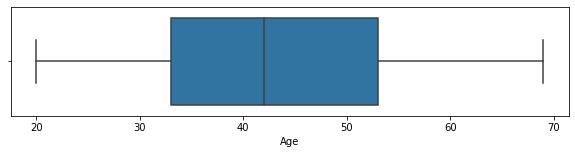

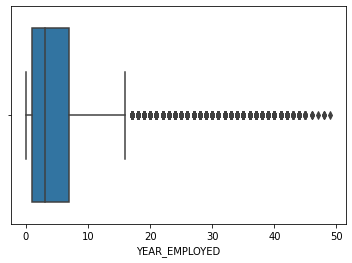

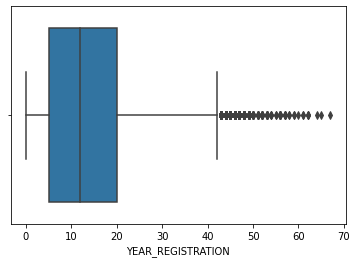

In [ ]:
fig=plt.subplots(figsize=(10, 2))
for i in Yr_feature:
  sns.boxplot(application_data[i])
  plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile

application_data = application_data[application_data[i] < np.nanpercentile(application_data[i], 99)]

#**Categorical Feature**

In [ ]:
# list of numerical variables
Categorical_features = [feature for feature in application_data.columns if application_data[feature].dtypes == 'O']

print('Number of numerical variables: ', len(Categorical_features))

# visualise the numerical variables
application_data[Categorical_features].head()

Number of numerical variables:  12


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [ ]:
Categorical_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [ ]:
application_data.shape

(268804, 41)

In [ ]:
for feature in Categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(application_data[feature].unique())))

The feature is NAME_CONTRACT_TYPE and number of categories are 2
The feature is CODE_GENDER and number of categories are 3
The feature is FLAG_OWN_CAR and number of categories are 2
The feature is FLAG_OWN_REALTY and number of categories are 2
The feature is NAME_TYPE_SUITE and number of categories are 8
The feature is NAME_INCOME_TYPE and number of categories are 8
The feature is NAME_EDUCATION_TYPE and number of categories are 5
The feature is NAME_FAMILY_STATUS and number of categories are 6
The feature is NAME_HOUSING_TYPE and number of categories are 6
The feature is OCCUPATION_TYPE and number of categories are 19
The feature is WEEKDAY_APPR_PROCESS_START and number of categories are 7
The feature is ORGANIZATION_TYPE and number of categories are 58


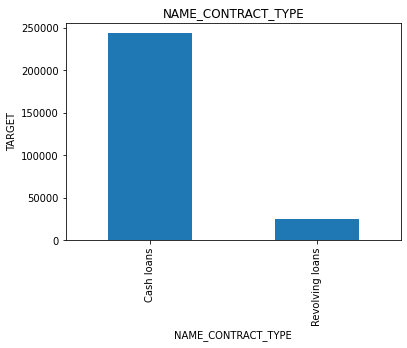

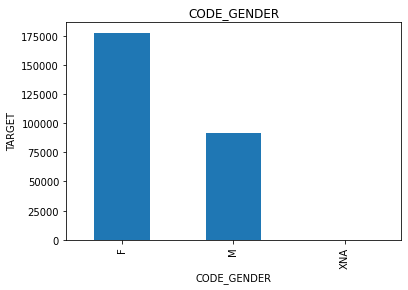

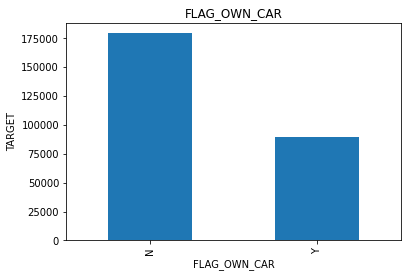

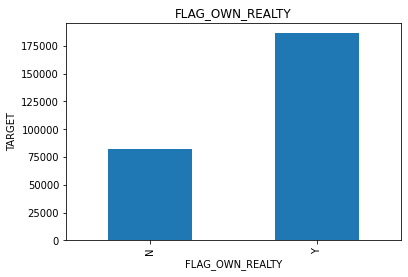

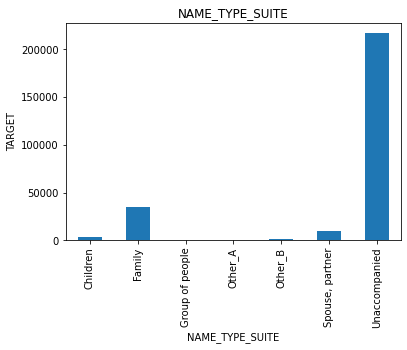

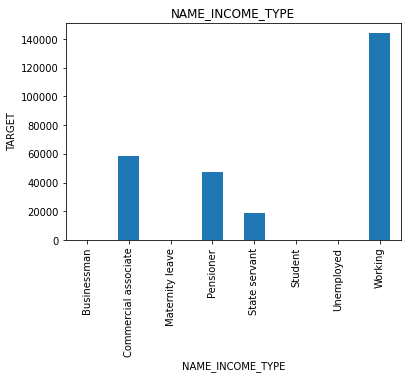

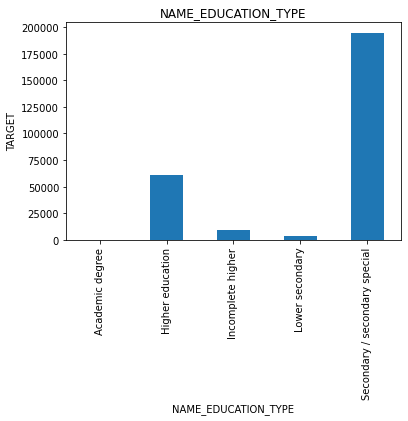

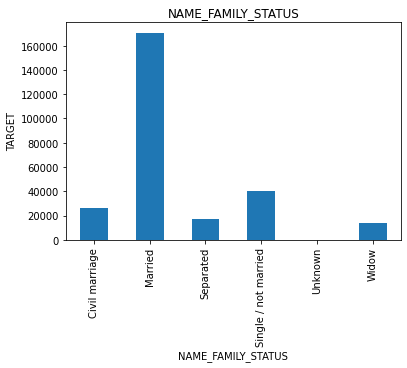

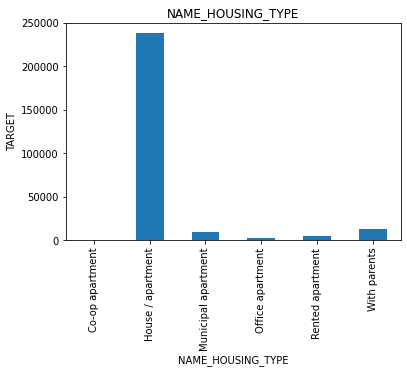

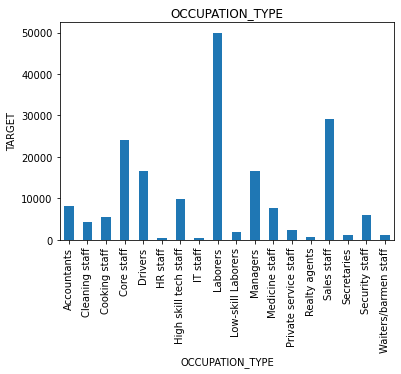

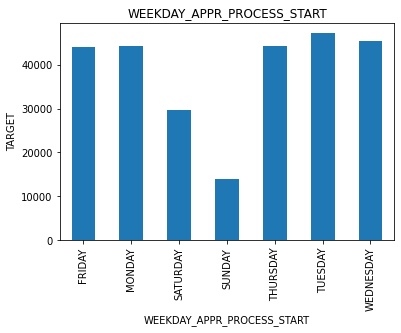

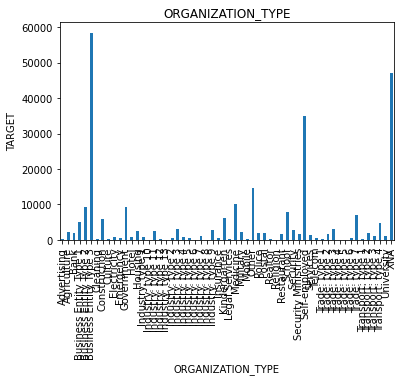

In [ ]:
for feature in Categorical_features:
    data=application_data.copy()
    data.groupby(feature)['TARGET'].count().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('TARGET')
    plt.title(feature)
    plt.show()

## **NAME_TYPE_SUITE**
## **NAME_CONTRACT_TYPE**
## **WEEKDAY_APPR_PROCESS_START**

In [ ]:
Feat_cat=['NAME_TYPE_SUITE', 'NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START']

In [ ]:
for j,i in enumerate(Feat_cat):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in NAME_TYPE_SUITE features is:

 Unaccompanied      216948
Family              35291
Spouse, partner      9991
Children             2919
Other_B              1563
Other_A               758
Group of people       234
Name: NAME_TYPE_SUITE, dtype: int64 

 2) value_counts in NAME_CONTRACT_TYPE features is:

 Cash loans         243587
Revolving loans     25217
Name: NAME_CONTRACT_TYPE, dtype: int64 

 3) value_counts in WEEKDAY_APPR_PROCESS_START features is:

 TUESDAY      47165
WEDNESDAY    45350
THURSDAY     44279
MONDAY       44264
FRIDAY       44029
SATURDAY     29692
SUNDAY       14025
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64 


In [ ]:
application_data[Feat_cat].isna().sum()

NAME_TYPE_SUITE               1100
NAME_CONTRACT_TYPE               0
WEEKDAY_APPR_PROCESS_START       0
dtype: int64

In [ ]:
# Replacing the missing colums with the most frequent category

application_data['NAME_TYPE_SUITE'] = application_data['NAME_TYPE_SUITE'].fillna(application_data['NAME_TYPE_SUITE'].mode()[0])

In [ ]:
for i in Feat_cat:
  print(value_wise_defaulter_percentage(application_data, i))

             Value  Percentage of Defaulter
5          Other_B                10.556622
6  Group of people                 9.401709
4          Other_A                 9.366755
0    Unaccompanied                 8.576093
2  Spouse, partner                 8.267441
1           Family                 7.803689
3         Children                 7.673861
             Value  Percentage of Defaulter
0       Cash loans                 8.738151
1  Revolving loans                 5.857160
       Value  Percentage of Defaulter
5    TUESDAY                 8.673805
0  WEDNESDAY                 8.610805
4     FRIDAY                 8.603420
2   THURSDAY                 8.432891
6     SUNDAY                 8.335116
3   SATURDAY                 8.268220
1     MONDAY                 8.178204


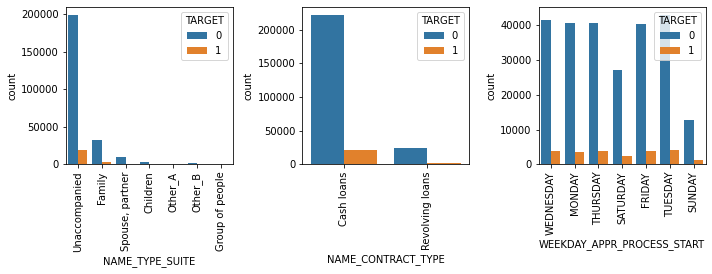

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(Feat_cat):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observation and action:**

1) Most of the applicant who are applied for loan are Unaccompanied.But Number of defaulter is also high for this category.

2) Cash Loans percentage is higher as compare to the Revolving loan.But Number of defaulter is also high for this category.

3) Most of the applicants prefer weekdays for applications as comapre to the weekends(SATURDAY and SUNDAY).

## **FLAG_OWN_CAR**
## **FLAG_OWN_REALTY**


In [ ]:
Feat_cat_FLAG=['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [ ]:
for j,i in enumerate(Feat_cat_FLAG):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in FLAG_OWN_CAR features is:

 N    179385
Y     89419
Name: FLAG_OWN_CAR, dtype: int64 

 2) value_counts in FLAG_OWN_REALTY features is:

 Y    186352
N     82452
Name: FLAG_OWN_REALTY, dtype: int64 


In [ ]:
application_data[Feat_cat_FLAG].isna().sum()

FLAG_OWN_CAR       0
FLAG_OWN_REALTY    0
dtype: int64

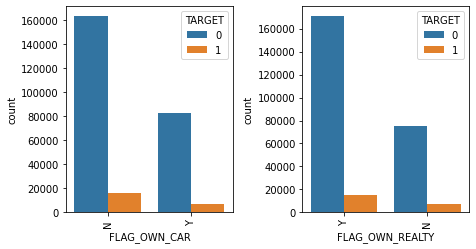

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(Feat_cat_FLAG):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
value_wise_defaulter_percentage(application_data, 'FLAG_OWN_CAR')

,Value,Percentage of Defaulter
0,N,8.860830
1,Y,7.679576


In [ ]:
value_wise_defaulter_percentage(application_data, 'FLAG_OWN_REALTY')

,Value,Percentage of Defaulter
1,N,8.762674
0,Y,8.337447


**Observation and action:**

1) Most of the applicants own realty

2) Most of the applicants do not own cars

3) People not owning reality and car and have a slightly higher default rate than the people who own reality and car

## **NAME_INCOME_TYPE**
## **NAME_EDUCATION_TYPE**
## **NAME_FAMILY_STATUS**
## **NAME_HOUSING_TYPE**


In [ ]:
Feat_cat_Name=[
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']
Feat_cat_Name

['NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [ ]:
for j,i in enumerate(Feat_cat_Name):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in NAME_INCOME_TYPE features is:

 Working                 144163
Commercial associate     58763
Pensioner                47181
State servant            18659
Unemployed                  16
Student                     16
Businessman                  3
Maternity leave              3
Name: NAME_INCOME_TYPE, dtype: int64 

 2) value_counts in NAME_EDUCATION_TYPE features is:

 Secondary / secondary special    195015
Higher education                  61286
Incomplete higher                  8907
Lower secondary                    3470
Academic degree                     126
Name: NAME_EDUCATION_TYPE, dtype: int64 

 3) value_counts in NAME_FAMILY_STATUS features is:

 Married                 170748
Single / not married     40271
Civil marriage           26589
Separated                17322
Widow                    13872
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64 

 4) value_counts in NAME_HOUSING_TYPE features is:

 House / apartment      238135

In [ ]:
application_data[Feat_cat_Name].isna().sum()

NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
dtype: int64

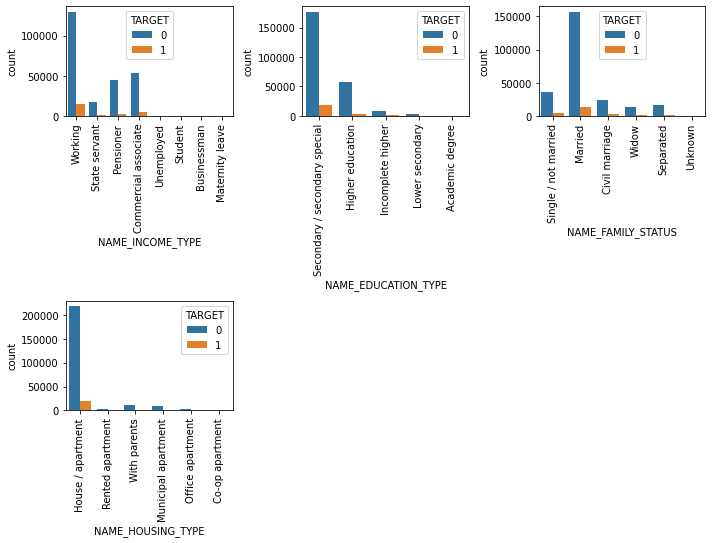

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(Feat_cat_Name):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
for i in Feat_cat_Name:
  print(value_wise_defaulter_percentage(application_data, i))

                  Value  Percentage of Defaulter
4            Unemployed                50.000000
7       Maternity leave                33.333333
0               Working                 9.891581
3  Commercial associate                 8.035669
1         State servant                 6.039981
2             Pensioner                 5.603951
5               Student                 0.000000
6           Businessman                 0.000000
                           Value  Percentage of Defaulter
3                Lower secondary                11.440922
0  Secondary / secondary special                 9.267492
2              Incomplete higher                 8.790839
1               Higher education                 5.720719
4                Academic degree                 2.380952
                  Value  Percentage of Defaulter
2        Civil marriage                10.252360
0  Single / not married                10.213305
4             Separated                 8.601778
1              

**Observation and action:**

1) Most of the applicants are working. But the defaulter percentage of the applicant of category Maternity leave and Unemployed is very high.

2) Most of the applicants has the education criteria is Secondary / secondary special.  But the defaulter percentage of the applicant of education criteria Lower secondary,Secondary / secondary special and Incomplete higher is large.

3) Most of the applicants are married.But the defaulter percentage of the applicant of category Civil marriage and Single / not married is large.

4) Most of the applicants has the House / apartment. But the defaulter percentage of the applicant of category Rented apartment and leaving With parents is large.

## **CODE_GENDER**
## **OCCUPATION_TYPE**
## **ORGANIZATION_TYPE**

In [ ]:
Feat_cat_oth=[
 'CODE_GENDER',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE']
Feat_cat_oth

['CODE_GENDER', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

In [ ]:
for j,i in enumerate(Feat_cat_oth):
  Number_f=application_data[i].value_counts()
  print("\n {}) value_counts in {} features is:\n\n {} ".format(j+1,i,Number_f))


 1) value_counts in CODE_GENDER features is:

 F      177705
M       91097
XNA         2
Name: CODE_GENDER, dtype: int64 

 2) value_counts in OCCUPATION_TYPE features is:

 Laborers                 49984
Sales staff              29215
Core staff               24039
Managers                 16709
Drivers                  16561
High skill tech staff     9808
Accountants               8164
Medicine staff            7730
Security staff            6069
Cooking staff             5485
Cleaning staff            4178
Private service staff     2302
Low-skill Laborers        1955
Waiters/barmen staff      1259
Secretaries               1139
Realty agents              661
HR staff                   467
IT staff                   417
Name: OCCUPATION_TYPE, dtype: int64 

 3) value_counts in ORGANIZATION_TYPE features is:

 Business Entity Type 3    58431
XNA                       47189
Self-employed             34987
Other                     14629
Medicine                   9993
Business Entity 

In [ ]:
application_data[Feat_cat_oth].isna().sum()

CODE_GENDER              0
OCCUPATION_TYPE      82662
ORGANIZATION_TYPE        0
dtype: int64

In [ ]:
# Imputing missing value for OCCUPATION TYPE as "Unknown"

application_data['OCCUPATION_TYPE'].fillna("Unknown", inplace=True)

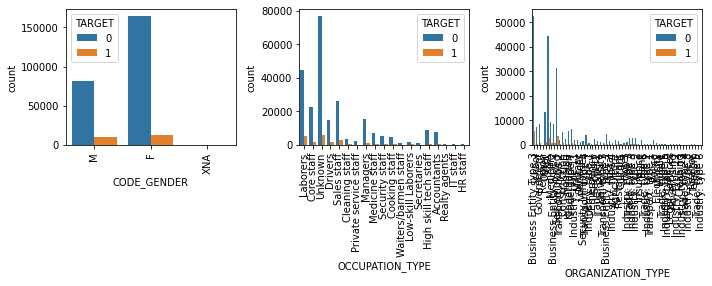

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(Feat_cat_oth):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(application_data[j], hue=application_data["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
for i in Feat_cat_oth:
  print("\n" + i +" :\n")
  print(value_wise_defaulter_percentage(application_data, i))


CODE_GENDER :

  Value  Percentage of Defaulter
0     M                10.720441
1     F                 7.313244
2   XNA                 0.000000

OCCUPATION_TYPE :

                    Value  Percentage of Defaulter
12     Low-skill Laborers                17.084399
3                 Drivers                11.828996
11   Waiters/barmen staff                11.358221
9          Security staff                11.039710
0                Laborers                10.935499
10          Cooking staff                10.683683
5          Cleaning staff                 9.909047
4             Sales staff                 9.881910
16          Realty agents                 8.472012
17               IT staff                 7.434053
13            Secretaries                 7.199298
6   Private service staff                 6.950478
2                 Unknown                 6.861678
8          Medicine staff                 6.856404
1              Core staff                 6.618412
7               

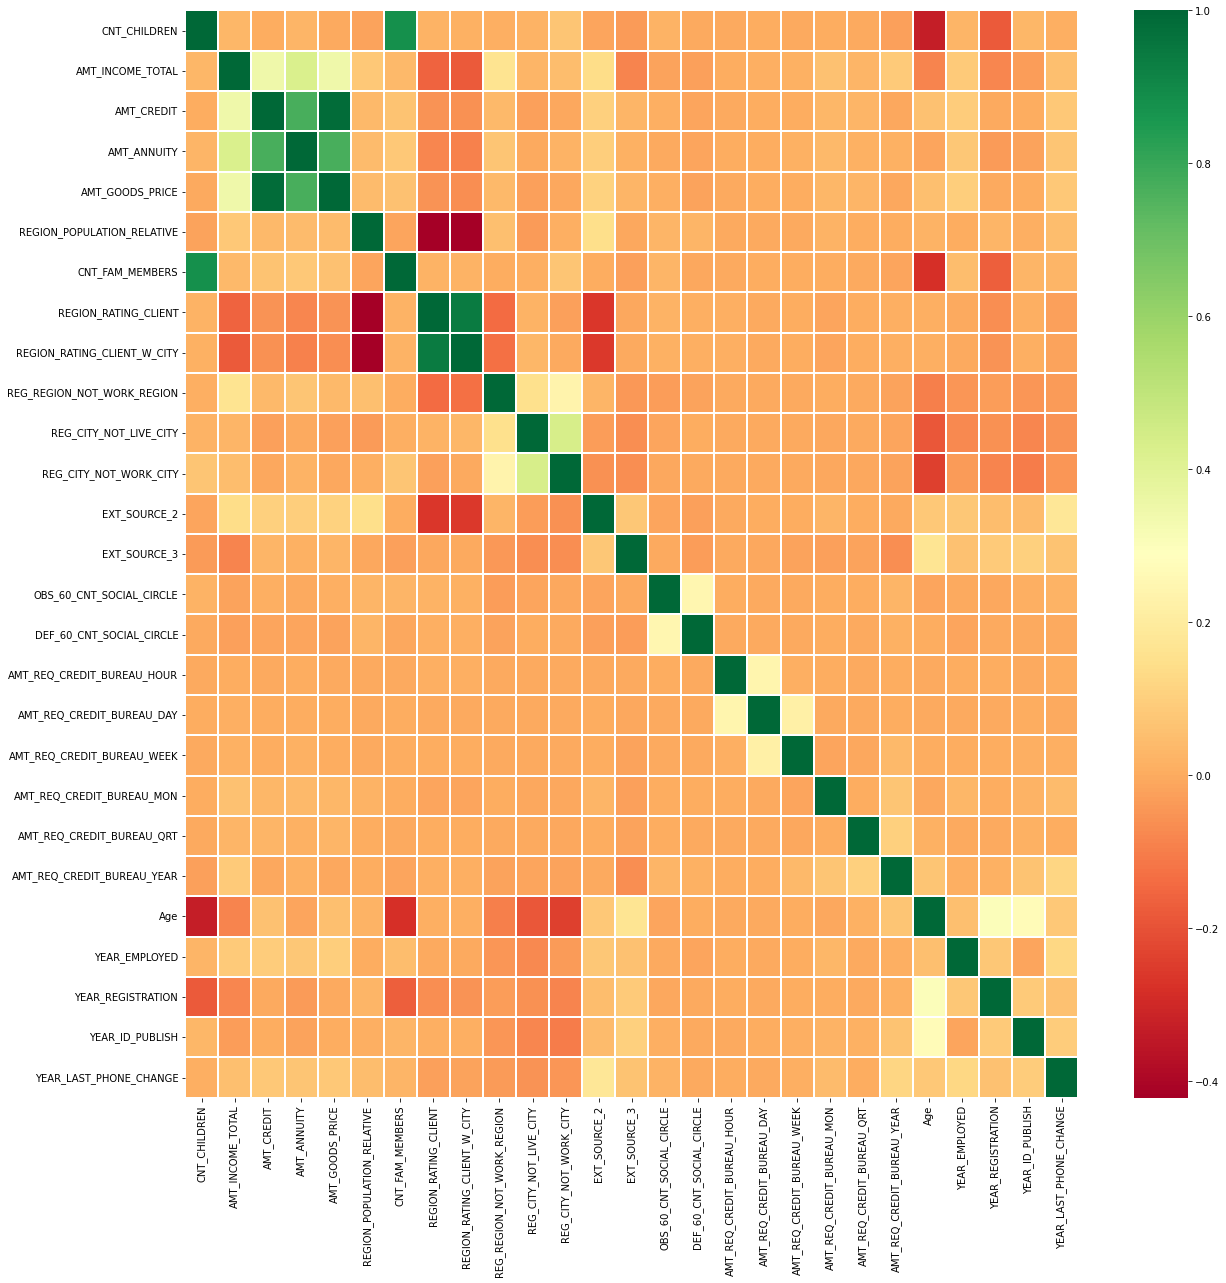

In [ ]:
col_correlation=[feature for feature in application_data.columns if feature not in ['SK_ID_CURR','TARGET'] ]
Repayer_df = application_data.loc[application_data['TARGET']==0, col_correlation] # Repayers
Defaulter_df = application_data.loc[application_data['TARGET']==1, col_correlation] # Defaulters
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(Repayer_df.corr(), cmap="RdYlGn",annot=False,linewidth =1)


In [ ]:
# Getting the top 10 correlation for the Repayers data

corr_repayer = Repayer_df.corr()
corr_repayer = corr_repayer.where(np.triu(np.ones(corr_repayer.shape),k=1).astype(np.bool))
corr_df_repayer = corr_repayer.unstack().reset_index()
corr_df_repayer.columns =['VAR1','VAR2','Correlation']
corr_df_repayer.dropna(subset = ["Correlation"], inplace = True)
corr_df_repayer["Correlation"]=corr_df_repayer["Correlation"].abs() 
corr_df_repayer.sort_values(by='Correlation', ascending=False, inplace=True) 
print(corr_df_repayer.head(10))

                            VAR1                        VAR2  Correlation
110              AMT_GOODS_PRICE                  AMT_CREDIT     0.983656
223  REGION_RATING_CLIENT_W_CITY        REGION_RATING_CLIENT     0.943369
162              CNT_FAM_MEMBERS                CNT_CHILDREN     0.880030
111              AMT_GOODS_PRICE                 AMT_ANNUITY     0.767979
83                   AMT_ANNUITY                  AMT_CREDIT     0.767918
307       REG_CITY_NOT_WORK_CITY      REG_CITY_NOT_LIVE_CITY     0.437309
82                   AMT_ANNUITY            AMT_INCOME_TOTAL     0.427960
221  REGION_RATING_CLIENT_W_CITY  REGION_POPULATION_RELATIVE     0.421383
194         REGION_RATING_CLIENT  REGION_POPULATION_RELATIVE     0.421370
109              AMT_GOODS_PRICE            AMT_INCOME_TOTAL     0.349794


In [ ]:
# Getting the top 10 correlation for the Defaulter data

corr_repayer = Defaulter_df.corr()#Finding the correlation of each features w.r.t each other
corr_repayer = corr_repayer.where(np.triu(np.ones(corr_repayer.shape),k=1).astype(np.bool))#keeping the only unique value as there are repetating value which we will replace with Nan
corr_df_repayer = corr_repayer.unstack().reset_index()# staking the corr coefficient value of features and indexing it accordingly
corr_df_repayer.columns =['VAR1','VAR2','Correlation']
corr_df_repayer.dropna(subset = ["Correlation"], inplace = True)# dropping the value which has the corr coefficient as Nan
corr_df_repayer["Correlation"]=corr_df_repayer["Correlation"].abs() 
corr_df_repayer.sort_values(by='Correlation', ascending=False, inplace=True) 
print(corr_df_repayer.head(10))

                            VAR1                        VAR2  Correlation
110              AMT_GOODS_PRICE                  AMT_CREDIT     0.979580
223  REGION_RATING_CLIENT_W_CITY        REGION_RATING_CLIENT     0.954677
162              CNT_FAM_MEMBERS                CNT_CHILDREN     0.886370
83                   AMT_ANNUITY                  AMT_CREDIT     0.743967
111              AMT_GOODS_PRICE                 AMT_ANNUITY     0.741950
307       REG_CITY_NOT_WORK_CITY      REG_CITY_NOT_LIVE_CITY     0.470779
82                   AMT_ANNUITY            AMT_INCOME_TOTAL     0.399452
221  REGION_RATING_CLIENT_W_CITY  REGION_POPULATION_RELATIVE     0.368879
194         REGION_RATING_CLIENT  REGION_POPULATION_RELATIVE     0.363387
109              AMT_GOODS_PRICE            AMT_INCOME_TOTAL     0.320905


#**<font color='red'>Previous_application data**

In [ ]:
# previous_application column types
print("previous_application.shape: ",previous_application.shape)
print("previous_application.size: ",previous_application.size)

previous_application.shape:  (1670214, 37)
previous_application.size:  61797918


In [ ]:
# previous_application column types
previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_DOWN_PAYMENT             774370 non-null   float32
 7   AMT_GOODS_PRICE              1284699 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
Miss_data= missingdata_percentage(previous_application,40)
Miss_data

,category,percentage
0,AMT_DOWN_PAYMENT,53.636480
1,RATE_DOWN_PAYMENT,53.636480
2,RATE_INTEREST_PRIMARY,99.643698
3,RATE_INTEREST_PRIVILEGED,99.643698
4,NAME_TYPE_SUITE,49.119754
5,DAYS_FIRST_DRAWING,40.298129
6,DAYS_FIRST_DUE,40.298129
7,DAYS_LAST_DUE_1ST_VERSION,40.298129
8,DAYS_LAST_DUE,40.298129
9,DAYS_TERMINATION,40.298129


In [ ]:
# Dropping the unnecessary columns from previous_application
previous_application.drop(['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'], axis=1, inplace=True)

In [ ]:
previous_application.isna().sum()

SK_ID_PREV                          0
SK_ID_CURR                          0
NAME_CONTRACT_TYPE                  0
AMT_ANNUITY                    372235
AMT_APPLICATION                     0
AMT_CREDIT                          1
AMT_DOWN_PAYMENT               895844
AMT_GOODS_PRICE                385515
WEEKDAY_APPR_PROCESS_START          0
HOUR_APPR_PROCESS_START             0
FLAG_LAST_APPL_PER_CONTRACT         0
NFLAG_LAST_APPL_IN_DAY              0
RATE_DOWN_PAYMENT              895844
NAME_CASH_LOAN_PURPOSE              0
NAME_CONTRACT_STATUS                0
DAYS_DECISION                       0
NAME_PAYMENT_TYPE                   0
CODE_REJECT_REASON                  0
NAME_TYPE_SUITE                820405
NAME_CLIENT_TYPE                    0
NAME_GOODS_CATEGORY                 0
NAME_PORTFOLIO                      0
NAME_PRODUCT_TYPE                   0
CHANNEL_TYPE                        0
SELLERPLACE_AREA                    0
NAME_SELLER_INDUSTRY                0
CNT_PAYMENT 

In [ ]:
# Merging only required columns of application_data with previous_application_data

prev_ap_merged = pd.merge(application_data[['SK_ID_CURR', 'TARGET']], previous_application, how='left', on=['SK_ID_CURR'])

prev_ap_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227811 entries, 0 to 1227810
Data columns (total 36 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_CURR                   1227811 non-null  int32  
 1   TARGET                       1227811 non-null  int8   
 2   SK_ID_PREV                   1215021 non-null  float64
 3   NAME_CONTRACT_TYPE           1215021 non-null  object 
 4   AMT_ANNUITY                  955510 non-null   float32
 5   AMT_APPLICATION              1215021 non-null  float32
 6   AMT_CREDIT                   1215020 non-null  float32
 7   AMT_DOWN_PAYMENT             582954 non-null   float32
 8   AMT_GOODS_PRICE              945596 non-null   float32
 9   WEEKDAY_APPR_PROCESS_START   1215021 non-null  object 
 10  HOUR_APPR_PROCESS_START      1215021 non-null  float64
 11  FLAG_LAST_APPL_PER_CONTRACT  1215021 non-null  object 
 12  NFLAG_LAST_APPL_IN_DAY       1215021 non-n

# **Numerical Feature**

In [ ]:
Num_feature=[feature for feature in prev_ap_merged.columns if prev_ap_merged[feature].dtypes !='O' and feature not in ['SK_ID_CURR','SK_ID_PREV','TARGET']]
print(len(Num_feature))
Num_feature

17


['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [ ]:
prev_num_df = pd.DataFrame()

for col in Num_feature:
    prev_num_df[col] = prev_ap_merged[col]
    
prev_num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227811 entries, 0 to 1227810
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   AMT_ANNUITY                955510 non-null   float32
 1   AMT_APPLICATION            1215021 non-null  float32
 2   AMT_CREDIT                 1215020 non-null  float32
 3   AMT_DOWN_PAYMENT           582954 non-null   float32
 4   AMT_GOODS_PRICE            945596 non-null   float32
 5   HOUR_APPR_PROCESS_START    1215021 non-null  float64
 6   NFLAG_LAST_APPL_IN_DAY     1215021 non-null  float64
 7   RATE_DOWN_PAYMENT          582954 non-null   float16
 8   DAYS_DECISION              1215021 non-null  float64
 9   SELLERPLACE_AREA           1215021 non-null  float64
 10  CNT_PAYMENT                955515 non-null   float16
 11  DAYS_FIRST_DRAWING         739700 non-null   float32
 12  DAYS_FIRST_DUE             739700 non-null   float32
 13  DAYS_LAST_DU

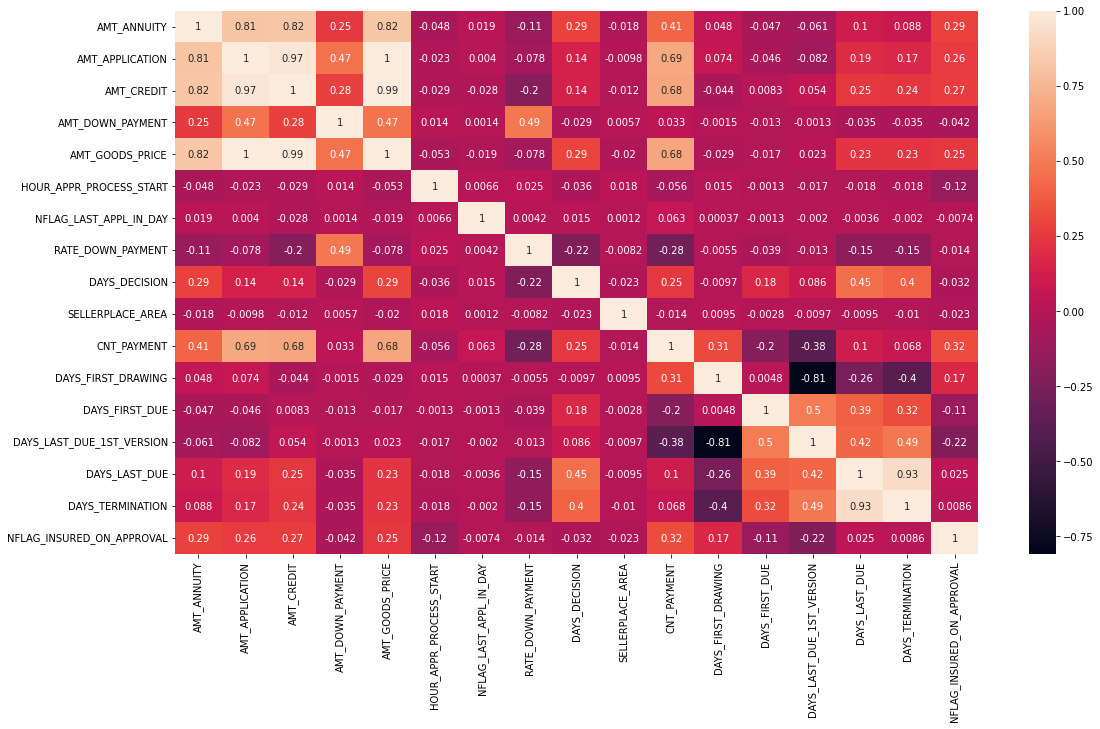

In [ ]:
# Checking correlation between numeric features of previous application data

plt.figure(figsize=(18,10))
sns.heatmap(prev_num_df.corr(), annot=True)
plt.show()

**Observation and Action:**

1) 'DAYS_LAST_DUE' and 'DAYS_TERMINATION' are highly correlated

2) 'DAYS_FIRST_DRAWING' and 'DAYS_LAST_DUE_1st_VERSION' have high negative correlation

3) 'AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE' are highly correlated

The features can be removed before modelling this data, as they would cause collinearity **'DAYS_TERMINATION','DAYS_LAST_DUE_1st_VERSION','AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE'**
For EDA purpose we are not removing them.

- 'SK_ID_PREV' column is not required for analysis.

In [ ]:
#'SK_ID_PREV' column is not required for analysis.
prev_ap_merged.drop(['SK_ID_PREV'], axis=1, inplace=True)

In [ ]:
prev_ap_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227811 entries, 0 to 1227810
Data columns (total 35 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_CURR                   1227811 non-null  int32  
 1   TARGET                       1227811 non-null  int8   
 2   NAME_CONTRACT_TYPE           1215021 non-null  object 
 3   AMT_ANNUITY                  955510 non-null   float32
 4   AMT_APPLICATION              1215021 non-null  float32
 5   AMT_CREDIT                   1215020 non-null  float32
 6   AMT_DOWN_PAYMENT             582954 non-null   float32
 7   AMT_GOODS_PRICE              945596 non-null   float32
 8   WEEKDAY_APPR_PROCESS_START   1215021 non-null  object 
 9   HOUR_APPR_PROCESS_START      1215021 non-null  float64
 10  FLAG_LAST_APPL_PER_CONTRACT  1215021 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1215021 non-null  float64
 12  RATE_DOWN_PAYMENT            582954 non-nu

# **Discreate Numerical Feature**

In [ ]:
Discreate_Num_feature=[feature for feature in Num_feature if (len(prev_ap_merged[feature].unique())<25) and feature not in ['SK_ID_CURR','SK_ID_PREV','TARGET']]
print(len(Discreate_Num_feature))
Discreate_Num_feature

2


['NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL']

## **NFLAG_LAST_APPL_IN_DAY**
## **NFLAG_INSURED_ON_APPROVAL**

In [ ]:
prev_ap_merged[Discreate_Num_feature].head()

,NFLAG_LAST_APPL_IN_DAY,NFLAG_INSURED_ON_APPROVAL
0,1.0,0.0
1,1.0,1.0
2,1.0,0.0
3,1.0,1.0
4,1.0,0.0


In [ ]:
prev_ap_merged[Discreate_Num_feature].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227811 entries, 0 to 1227810
Data columns (total 2 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   NFLAG_LAST_APPL_IN_DAY     1215021 non-null  float64
 1   NFLAG_INSURED_ON_APPROVAL  739700 non-null   float16
dtypes: float16(1), float64(1)
memory usage: 21.1 MB


In [ ]:
prev_ap_merged[Discreate_Num_feature].isna().sum()

NFLAG_LAST_APPL_IN_DAY        12790
NFLAG_INSURED_ON_APPROVAL    488111
dtype: int64

In [ ]:
for i in Discreate_Num_feature:
  A=prev_ap_merged[i].value_counts()
  print(A)

1.0    1210653
0.0       4368
Name: NFLAG_LAST_APPL_IN_DAY, dtype: int64
0.0    500827
1.0    238873
Name: NFLAG_INSURED_ON_APPROVAL, dtype: int64


In [ ]:
prev_ap_merged['NFLAG_LAST_APPL_IN_DAY'] = prev_ap_merged['NFLAG_LAST_APPL_IN_DAY'].fillna(prev_ap_merged['NFLAG_LAST_APPL_IN_DAY'].mode()[0])

In [ ]:
prev_ap_merged['NFLAG_INSURED_ON_APPROVAL'] = prev_ap_merged['NFLAG_INSURED_ON_APPROVAL'].fillna(prev_ap_merged['NFLAG_INSURED_ON_APPROVAL'].mode()[0])

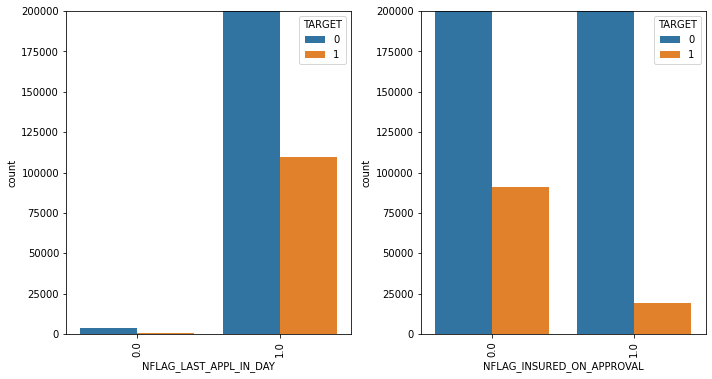

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(Discreate_Num_feature):
    plt.subplot(2, 2, i+1, ylim=(0, 200000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(prev_ap_merged[j], hue=prev_ap_merged["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NFLAG_LAST_APPL_IN_DAY')

,Value,Percentage of Defaulter
1,0.0,10.462454
0,1.0,8.959551


In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NFLAG_INSURED_ON_APPROVAL')

,Value,Percentage of Defaulter
0,0.0,9.214632
1,1.0,7.930993


**Observation and action:**

1) In NFLAG_LAST_APPL_IN_DAY,most of the applicants are comes under the caterory 1. But the defaulter percentage of the applicant of category 0 is very high.

2) In NFLAG_INSURED_ON_APPROVAL,most of the applicants are comes under the caterory 0 and defaulter percentage of the applicant of category 0 is also very high.


# **Continous Numerical Feature**

In [ ]:
## Numerical variables are usually of 2 type
## 1. Continous variable and Discrete Variables

Continous_Num_feature=[feature for feature in Num_feature if feature not in Discreate_Num_feature and feature not in ['SK_ID_CURR','SK_ID_PREV','TARGET']]
print("Continous Variables Count: {}".format(len(Continous_Num_feature)))
Continous_Num_feature

Continous Variables Count: 15


['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION']

## **AMT Realted Feature**

In [ ]:
AMT_feature = [feature for feature in Continous_Num_feature if 'AMT' in feature]
AMT_feature

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE']

In [ ]:
prev_ap_merged[AMT_feature].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227811 entries, 0 to 1227810
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   AMT_ANNUITY       955510 non-null   float32
 1   AMT_APPLICATION   1215021 non-null  float32
 2   AMT_CREDIT        1215020 non-null  float32
 3   AMT_DOWN_PAYMENT  582954 non-null   float32
 4   AMT_GOODS_PRICE   945596 non-null   float32
dtypes: float32(5)
memory usage: 32.8 MB


In [ ]:
prev_ap_merged[AMT_feature].isna().sum()

AMT_ANNUITY         272301
AMT_APPLICATION      12790
AMT_CREDIT           12791
AMT_DOWN_PAYMENT    644857
AMT_GOODS_PRICE     282215
dtype: int64

In [ ]:
#Missing value features percentage
AMT_Cont_Fea_Miss_prev = missingdata_percentage(prev_ap_merged[AMT_feature],0)
AMT_Cont_Fea_Miss_prev

,category,percentage
0,AMT_ANNUITY,22.177762
1,AMT_APPLICATION,1.041691
2,AMT_CREDIT,1.041773
3,AMT_DOWN_PAYMENT,52.520868
4,AMT_GOODS_PRICE,22.985215


In [ ]:
for i in AMT_feature:
  prev_ap_merged[i].fillna(prev_ap_merged[i].median(),inplace = True)

In [ ]:
#Post imputation the number of nan feature
prev_ap_merged[AMT_feature].isna().sum()

AMT_ANNUITY         0
AMT_APPLICATION     0
AMT_CREDIT          0
AMT_DOWN_PAYMENT    0
AMT_GOODS_PRICE     0
dtype: int64

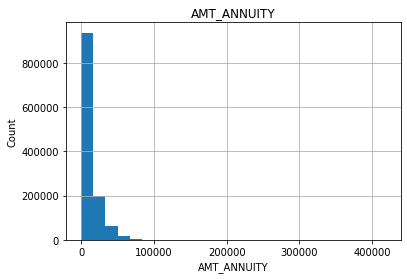

The Skewness of the continous features AMT_ANNUITY is: 3.0099658966064453 


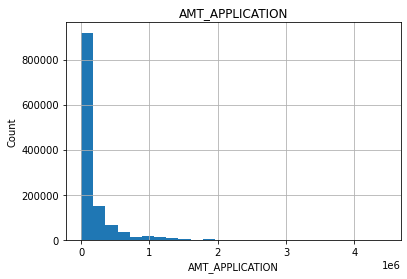

The Skewness of the continous features AMT_APPLICATION is: 3.4311115741729736 


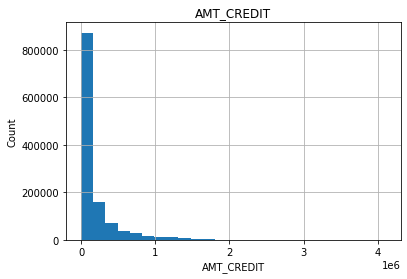

The Skewness of the continous features AMT_CREDIT is: 3.2902681827545166 


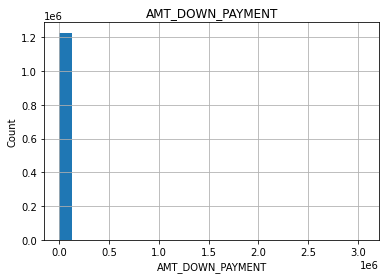

The Skewness of the continous features AMT_DOWN_PAYMENT is: 50.51060104370117 


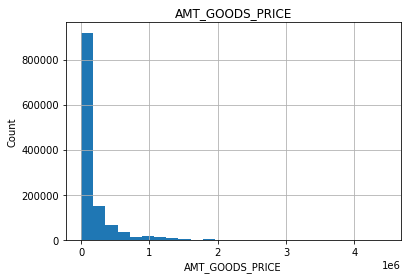

The Skewness of the continous features AMT_GOODS_PRICE is: 3.6480047702789307 


In [ ]:
from scipy.stats import skew
for feature in AMT_feature:
    data=prev_ap_merged.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()
    print("The Skewness of the continous features {} is: {} " .format(feature,skew(data[feature])))

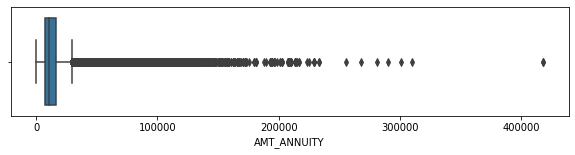

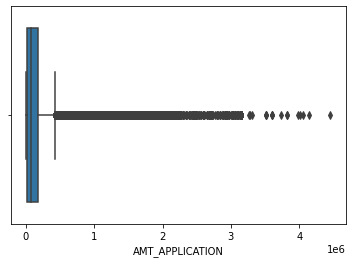

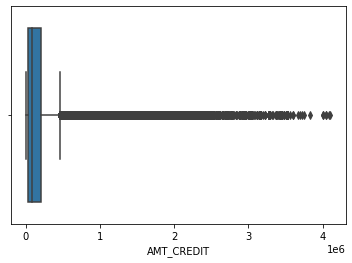

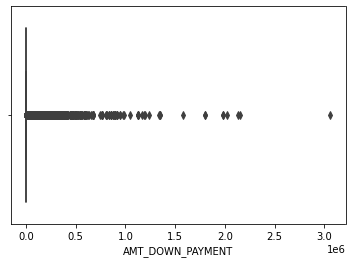

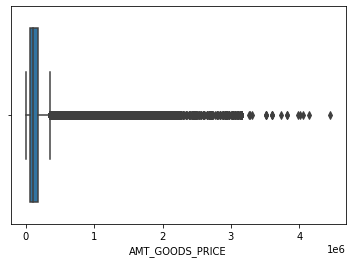

In [ ]:
fig=plt.subplots(figsize=(10, 2))

for i, j in enumerate(AMT_feature):
    sns.boxplot(prev_ap_merged[j])
    plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile

for i in AMT_feature:
  prev_ap_merged = prev_ap_merged[prev_ap_merged[i] < np.nanpercentile(prev_ap_merged[i], 99)]

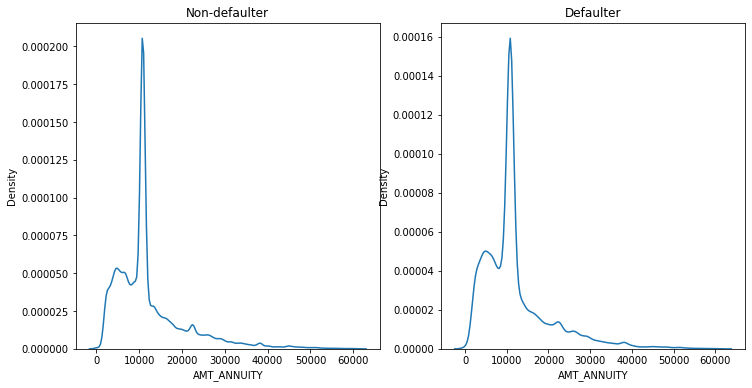

In [ ]:

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_ANNUITY'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_ANNUITY'], ax=ax2)

plt.show()

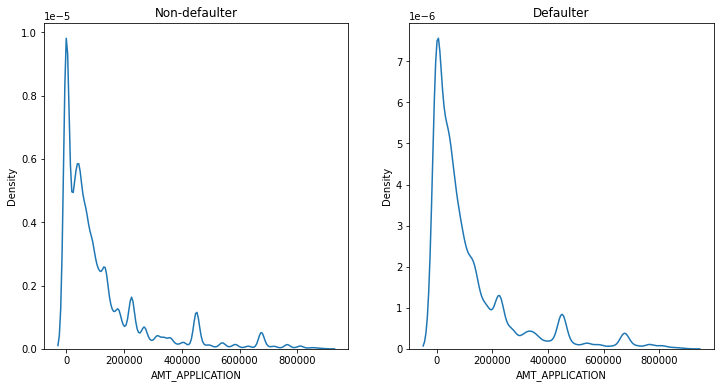

In [ ]:

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_APPLICATION'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_APPLICATION'], ax=ax2)

plt.show()

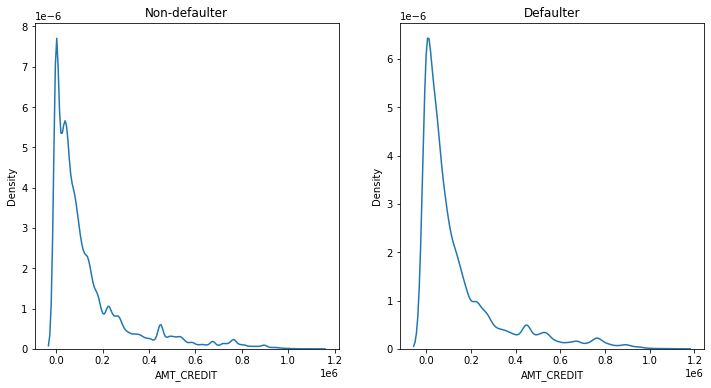

In [ ]:

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_CREDIT'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_CREDIT'], ax=ax2)

plt.show()

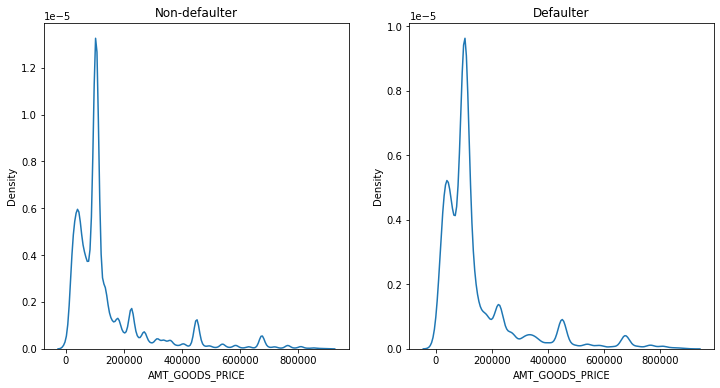

In [ ]:

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_GOODS_PRICE'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_GOODS_PRICE'], ax=ax2)

plt.show()

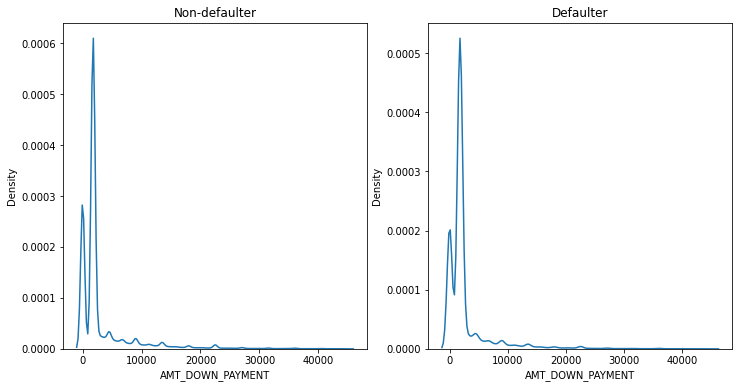

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_DOWN_PAYMENT'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_DOWN_PAYMENT'], ax=ax2)

plt.show()

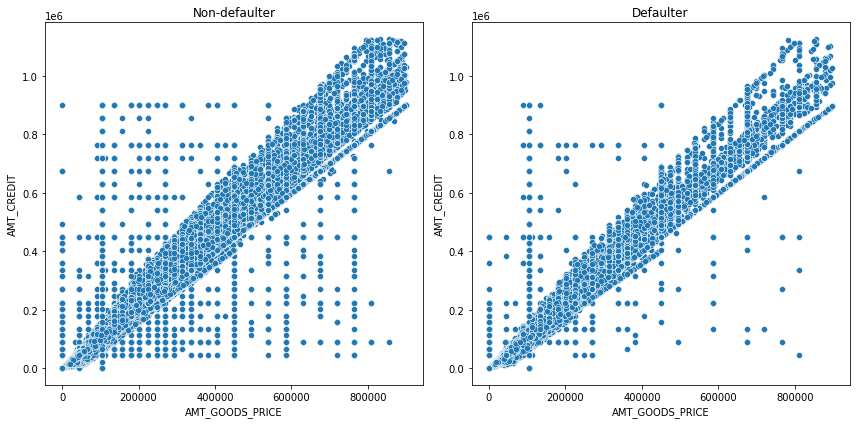

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.scatterplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_GOODS_PRICE'], prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_CREDIT'], ax=ax1)
sns.scatterplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_GOODS_PRICE'], prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_CREDIT'], ax=ax2)

plt.tight_layout()
plt.show()

**Observation and action:**

1) In 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_DOWN_PAYMENT' and 'AMT_GOODS_PRICE' to avoide the impact of outlier we have to consider the value only upto the 99 percentile.

2) 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_DOWN_PAYMENT' and 'AMT_GOODS_PRICE' is following the same distribution for both Defaulter and Non-defaulter.

3) AMT_CREDIT and AMT_GOODS_PRICE has the linear relationship for both in Defaulter and Non-defaulter case. Also, plot shows the number of Defaulter is less at the lower range.


## **HOUR_APPR_PROCESS_START**

In [ ]:
prev_ap_merged['HOUR_APPR_PROCESS_START'].head()

0     9.0
3    15.0
4     5.0
5    15.0
6    15.0
Name: HOUR_APPR_PROCESS_START, dtype: float64

In [ ]:
prev_ap_merged['HOUR_APPR_PROCESS_START'].describe()

count    1.150371e+06
mean     1.241395e+01
std      3.321795e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.200000e+01
75%      1.500000e+01
max      2.300000e+01
Name: HOUR_APPR_PROCESS_START, dtype: float64

In [ ]:
prev_ap_merged['HOUR_APPR_PROCESS_START'].value_counts()

11.0    133554
12.0    128425
10.0    126264
13.0    118846
14.0    108088
15.0     97820
9.0      89667
16.0     81997
17.0     63947
8.0      52395
18.0     42258
7.0      32556
19.0     21793
6.0      18387
5.0      11021
20.0      9299
4.0       6597
3.0       3415
21.0      2483
2.0        773
22.0       451
1.0        153
23.0       116
0.0         66
Name: HOUR_APPR_PROCESS_START, dtype: int64

**Observation and action:**

1) Most of the applicant has application process start hour is 10:00.This feature does not shows any visible impact on TARGET variable

In [ ]:
# Dropping the column as new column will be used for analysis

prev_ap_merged.drop(labels='HOUR_APPR_PROCESS_START', inplace=True, axis=1)

## **DAYS_DECISION**

In [ ]:
Day_feature=[feature for feature in Continous_Num_feature if 'DAYS' in feature]
Day_feature

['DAYS_DECISION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION']

In [ ]:
prev_ap_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Consumer loans,9251.775391,179055.0,179055.0,0.0,179055.0,SATURDAY,Y,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
3,100003,0,Consumer loans,6737.310059,68809.5,68053.5,6885.0,68809.5,SATURDAY,Y,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,Consumer loans,5357.250000,24282.0,20106.0,4860.0,24282.0,FRIDAY,Y,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
5,100006,0,Cash loans,24246.000000,675000.0,675000.0,1773.0,675000.0,THURSDAY,Y,...,XNA,48.0,low_normal,Cash X-Sell: low,365243.0,-151.0,1259.0,-151.0,-143.0,0.0
6,100006,0,Revolving loans,10821.240234,0.0,0.0,1773.0,104175.0,THURSDAY,Y,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
prev_ap_merged[Day_feature].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1163161 entries, 0 to 1227810
Data columns (total 6 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   DAYS_DECISION              1150371 non-null  float64
 1   DAYS_FIRST_DRAWING         705943 non-null   float32
 2   DAYS_FIRST_DUE             705943 non-null   float32
 3   DAYS_LAST_DUE_1ST_VERSION  705943 non-null   float32
 4   DAYS_LAST_DUE              705943 non-null   float32
 5   DAYS_TERMINATION           705943 non-null   float32
dtypes: float32(5), float64(1)
memory usage: 39.9 MB


In [ ]:
prev_ap_merged[Day_feature].isna().sum()

DAYS_DECISION                 12790
DAYS_FIRST_DRAWING           457218
DAYS_FIRST_DUE               457218
DAYS_LAST_DUE_1ST_VERSION    457218
DAYS_LAST_DUE                457218
DAYS_TERMINATION             457218
dtype: int64

In [ ]:
missingdata_percentage(previous_application[Day_feature],0)

,category,percentage
0,DAYS_FIRST_DRAWING,40.298129
1,DAYS_FIRST_DUE,40.298129
2,DAYS_LAST_DUE_1ST_VERSION,40.298129
3,DAYS_LAST_DUE,40.298129
4,DAYS_TERMINATION,40.298129


In [ ]:
#Calculating the percenatge of the max categorie in the dataset
print("Shape of the dataframe: ",prev_ap_merged.shape)
for i in Day_feature:
  B=prev_ap_merged[i].value_counts().idxmax()
  C=100*(prev_ap_merged[i].value_counts().max())/prev_ap_merged.shape[0]
  print("The Percentage of the {} occure in the {}: {}%".format(B,i,C))

Shape of the dataframe:  (1163161, 34)
The Percentage of the -238.0 occure in the DAYS_DECISION: 0.1477869357724339%
The Percentage of the 365243.0 occure in the DAYS_FIRST_DRAWING: 56.71149565709304%
The Percentage of the 365243.0 occure in the DAYS_FIRST_DUE: 2.5189977999606246%
The Percentage of the 365243.0 occure in the DAYS_LAST_DUE_1ST_VERSION: 5.870210572741005%
The Percentage of the 365243.0 occure in the DAYS_LAST_DUE: 12.715092751562338%
The Percentage of the 365243.0 occure in the DAYS_TERMINATION: 13.697158003062345%


1) As per the obervation feature like **DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION** has the >40% of the missing value.

2) Also the maximing occuring categories for the features is itself outlier.

3) **DAYS_FIRST_DRAWING** feature is seems useless as the percentage of missing value for it is >40% and the >56% of the values are outlier so we will drop this feature.

In [ ]:
prev_ap_merged.drop(['DAYS_FIRST_DRAWING'], axis=1, inplace=True)

In [ ]:
# Converting DAYS_DECISION to YEAR_DECISION

prev_ap_merged["YEAR_DECISION"] = prev_ap_merged.DAYS_DECISION//(-365) 
prev_ap_merged[["YEAR_DECISION"]].head()

,YEAR_DECISION
0,1.0
3,6.0
4,2.0
5,0.0
6,0.0


In [ ]:
# Converting DAYS_FIRST_DUE to YEAR_FIRST_DUE

prev_ap_merged["YEAR_FIRST_DUE"] = prev_ap_merged.DAYS_FIRST_DUE//(-365) 
prev_ap_merged[["YEAR_FIRST_DUE"]].head()

,YEAR_FIRST_DUE
0,1.0
3,6.0
4,2.0
5,0.0
6,NaN


In [ ]:
# Converting DAYS_LAST_DUE_1ST_VERSION to YEAR_LAST_DUE_1ST_VERSION

prev_ap_merged["YEAR_LAST_DUE_1ST_VERSION"] = prev_ap_merged.DAYS_LAST_DUE_1ST_VERSION//(-365) 
prev_ap_merged[["YEAR_LAST_DUE_1ST_VERSION"]].head()

,YEAR_LAST_DUE_1ST_VERSION
0,-1.0
3,5.0
4,1.0
5,-4.0
6,NaN


In [ ]:
# Converting DAYS_LAST_DUE to YEAR_LAST_DUE

prev_ap_merged["YEAR_LAST_DUE"] = prev_ap_merged.DAYS_LAST_DUE//(-365) 
prev_ap_merged[["YEAR_LAST_DUE"]].head()

,YEAR_LAST_DUE
0,0.0
3,5.0
4,1.0
5,0.0
6,NaN


In [ ]:
# Converting DAYS_TERMINATION to YEAR_TERMINATION

prev_ap_merged["YEAR_TERMINATION"] = prev_ap_merged.DAYS_TERMINATION//(-365) 
prev_ap_merged[["YEAR_TERMINATION"]].head()

,YEAR_TERMINATION
0,0.0
3,5.0
4,1.0
5,0.0
6,NaN


In [ ]:
# Post removing the DAYS_FIRST_DRAWING feature
Day_feature_1=[feature for feature in prev_ap_merged if 'DAYS' in feature]
Day_feature_1

['DAYS_DECISION',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION']

In [ ]:
YEAR_feature=[feature for feature in prev_ap_merged if 'YEAR' in feature]
YEAR_feature

['YEAR_DECISION',
 'YEAR_FIRST_DUE',
 'YEAR_LAST_DUE_1ST_VERSION',
 'YEAR_LAST_DUE',
 'YEAR_TERMINATION']

In [ ]:
# Dropping the column as new column will be used for analysis

prev_ap_merged.drop(labels=Day_feature_1, inplace=True, axis=1)

In [ ]:
for i in YEAR_feature:
  prev_ap_merged[i].fillna(prev_ap_merged[i].median(),inplace = True)

In [ ]:
#Calculating the percenatge of the max categorie in the dataset
print("Shape of the dataframe: ",prev_ap_merged.shape)
for i in YEAR_feature:
  B=prev_ap_merged[i].value_counts().idxmax()
  C=100*(prev_ap_merged[i].value_counts().max())/prev_ap_merged.shape[0]
  print("The Percentage of the {} occure in the {}: {}%".format(B,i,C))

Shape of the dataframe:  (1163161, 33)
The Percentage of the 0.0 occure in the YEAR_DECISION: 34.72030097295215%
The Percentage of the 2.0 occure in the YEAR_FIRST_DUE: 48.65912801409263%
The Percentage of the 1.0 occure in the YEAR_LAST_DUE_1ST_VERSION: 46.771427171303024%
The Percentage of the 1.0 occure in the YEAR_LAST_DUE: 49.07033506109644%
The Percentage of the 1.0 occure in the YEAR_TERMINATION: 48.79883352347611%


In [ ]:
#Replacing the unrealstic category -1001 with 2nd most occuring category with 1
print("Shape of the dataframe: ",prev_ap_merged.shape)
for i in YEAR_feature:
  B=prev_ap_merged[i].value_counts().idxmax()
  NB=prev_ap_merged[i].replace([-1001],[B],inplace=True)

Shape of the dataframe:  (1163161, 33)


In [ ]:
prev_ap_merged['YEAR_LAST_DUE_1ST_VERSION']=prev_ap_merged['YEAR_LAST_DUE_1ST_VERSION'].abs()

In [ ]:
for i in YEAR_feature:  
  A= prev_ap_merged[i].value_counts()
  print(A)

0.0    403853
1.0    260179
2.0    142459
3.0     92819
4.0     72960
6.0     72096
7.0     59636
5.0     58792
8.0       367
Name: YEAR_DECISION, dtype: int64
2.0    595284
1.0    155921
0.0    130529
3.0     70353
6.0     59975
4.0     58460
5.0     48837
7.0     43802
Name: YEAR_FIRST_DUE, dtype: int64
1.0    714915
0.0    129915
2.0     95021
3.0     64958
4.0     54158
5.0     49975
6.0     43345
7.0     10874
Name: YEAR_LAST_DUE_1ST_VERSION, dtype: int64
1.0    718664
0.0    142914
2.0     82416
3.0     60344
4.0     51670
5.0     49383
6.0     45192
7.0     12578
Name: YEAR_LAST_DUE, dtype: int64
1.0    726929
0.0    145974
2.0     79472
3.0     58786
4.0     50249
5.0     47373
6.0     43183
7.0     11195
Name: YEAR_TERMINATION, dtype: int64


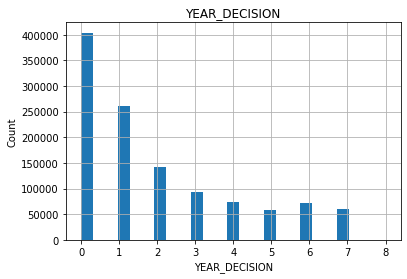

The Skewness of the continous features YEAR_DECISION is: 1.003701418987365 


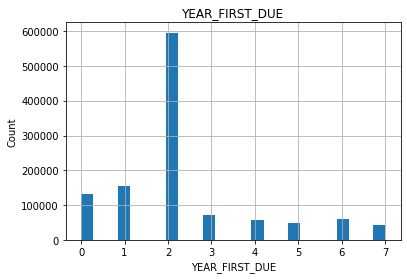

The Skewness of the continous features YEAR_FIRST_DUE is: 1.1722813564067016 


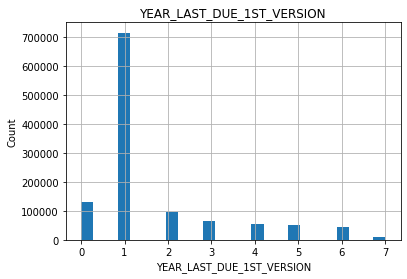

The Skewness of the continous features YEAR_LAST_DUE_1ST_VERSION is: 1.7056208598812743 


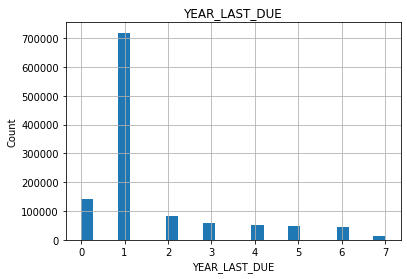

The Skewness of the continous features YEAR_LAST_DUE is: 1.732809637307081 


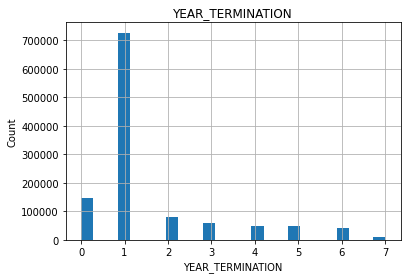

The Skewness of the continous features YEAR_TERMINATION is: 1.7798409259943448 


In [ ]:
from scipy.stats import skew
for feature in YEAR_feature:
    data=prev_ap_merged.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()
    print("The Skewness of the continous features {} is: {} " .format(feature,skew(data[feature])))

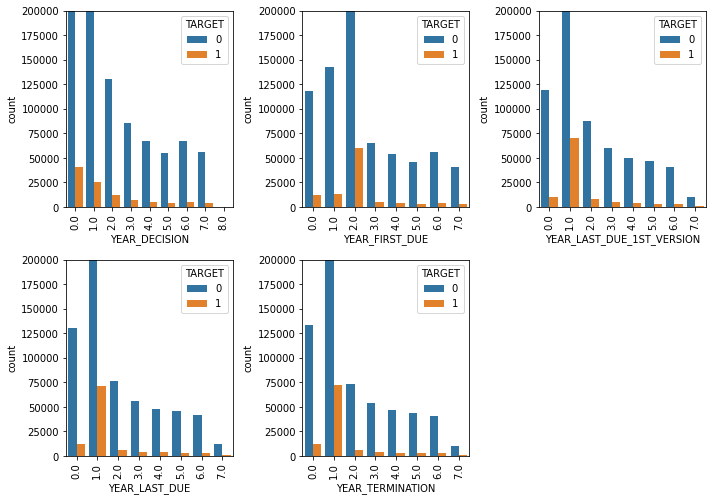

In [ ]:
fig=plt.subplots(figsize=(10, 10))

for i, j in enumerate(YEAR_feature):
    plt.subplot(3, 3, i+1, ylim=(0, 200000))
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(prev_ap_merged[j], hue=prev_ap_merged["TARGET"])
    plt.xticks(rotation=90)
    plt.tight_layout()

In [ ]:
for i in YEAR_feature:
  print(i+': ')
  A=value_wise_defaulter_percentage(prev_ap_merged,i)
  print(A)

YEAR_DECISION: 
   Value  Percentage of Defaulter
3    0.0                10.209160
0    1.0                 9.680643
2    2.0                 8.801831
5    3.0                 7.715015
4    4.0                 7.556195
1    6.0                 7.319407
7    5.0                 7.165941
6    7.0                 6.633577
8    8.0                 6.267030
YEAR_FIRST_DUE: 
   Value  Percentage of Defaulter
2    2.0                10.030002
3    0.0                 9.113684
0    1.0                 8.760205
5    3.0                 7.333021
4    4.0                 7.276770
1    6.0                 7.036265
7    5.0                 6.923030
6    7.0                 6.444911
YEAR_LAST_DUE_1ST_VERSION: 
   Value  Percentage of Defaulter
0    1.0                 9.849003
5    2.0                 8.152935
3    0.0                 8.116076
4    3.0                 8.086764
2    4.0                 7.433805
1    5.0                 7.031516
6    6.0                 6.803553
7    7.0             

### **Observation and action:**

In **'DAYS_DECISION','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE' and 'DAYS_TERMINATION'**
features all the days have the negative value.But days are always positive so we do feature Engg on it.
1) First remove the negative value
2) Convert the days into years by dividing it by -365.

So new features are **'YEAR_DECISION','YEAR_FIRST_DUE','YEAR_LAST_DUE_1ST_VERSION','YEAR_LAST_DUE','YEAR_TERMINATION'**

2) But in all the features we got the outlier as the -1001 Yr and which is one of the highest occuring category.
so to deal with this issue we will replace the outlier category with most occuring category.

3) Also,we will make all the negative Yr value in the feature **'YEAR_LAST_DUE_1ST_VERSION'** by using the abs()

4) Most of the occuring features are '**YEAR_LAST_DUE_1ST_VERSION**','YEAR_LAST_DUE','YEAR_TERMINATION' is 1 Yr and
Also the deault percentage of applicant which has the **'YEAR_LAST_DUE_1ST_VERSION','YEAR_LAST_DUE','YEAR_TERMINATION'**
as 1 yr is high

5) '**YEAR_DECISION**' and '**YEAR_FIRST_DUE**' has the 0 Yr and 2 Yr is highest occuring as well as default percentage 
category.

## **SELLERPLACE_AREA**

In [ ]:
prev_ap_merged['SELLERPLACE_AREA'].head()

0    500.0
3    200.0
4     30.0
5     -1.0
6     -1.0
Name: SELLERPLACE_AREA, dtype: float64

In [ ]:
prev_ap_merged['SELLERPLACE_AREA'].describe()

count    1.150371e+06
mean     3.144466e+02
std      5.512906e+03
min     -1.000000e+00
25%     -1.000000e+00
50%      1.000000e+01
75%      1.000000e+02
max      4.000000e+06
Name: SELLERPLACE_AREA, dtype: float64

In [ ]:
prev_ap_merged['SELLERPLACE_AREA'].value_counts()

-1.0       487639
 0.0        37029
 50.0       27870
 30.0       26575
 20.0       25051
            ...  
 1357.0         1
 1446.0         1
 676.0          1
 1723.0         1
 1622.0         1
Name: SELLERPLACE_AREA, Length: 1997, dtype: int64

In [ ]:
prev_ap_merged['SELLERPLACE_AREA'].isna().sum()

12790

In [ ]:
prev_ap_merged['SELLERPLACE_AREA'].fillna(prev_ap_merged['SELLERPLACE_AREA'].median(),inplace = True)

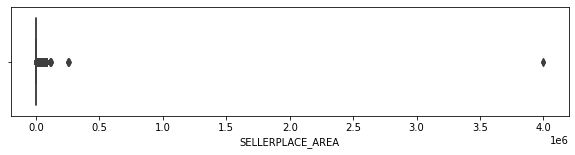

In [ ]:
fig=plt.subplots(figsize=(10, 2))
sns.boxplot(prev_ap_merged['SELLERPLACE_AREA'])
plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile
prev_ap_merged = prev_ap_merged[prev_ap_merged['SELLERPLACE_AREA'] < np.nanpercentile(prev_ap_merged['SELLERPLACE_AREA'], 99)]

In [ ]:
#Calculating the percenatge of the max categorie in the dataset

B=prev_ap_merged['SELLERPLACE_AREA'].value_counts().idxmax()
C=100*(prev_ap_merged['SELLERPLACE_AREA'].value_counts().max())/prev_ap_merged.shape[0]
print("The Percentage of the {} occure in the {}: {}%".format(B,'SELLERPLACE_AREA',C))

The Percentage of the -1.0 occure in the SELLERPLACE_AREA: 42.35238430238365%


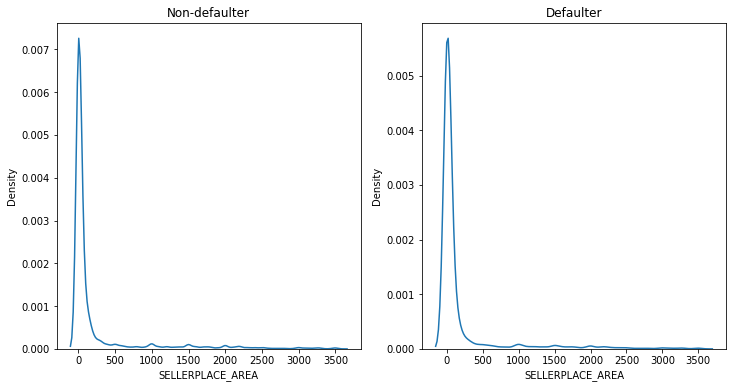

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['SELLERPLACE_AREA'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['SELLERPLACE_AREA'], ax=ax2)

plt.show()

### **Observation and Action:**

SELLERPLACE_AREA has the -1 as the most occuring category and It has the same distribution for the both defaulter and Non-defaulter.

## **CNT_PAYMENT**

In [ ]:
prev_ap_merged['CNT_PAYMENT'].head()

0    24.0
3    12.0
4     4.0
5    48.0
6     NaN
Name: CNT_PAYMENT, dtype: float16

In [ ]:
prev_ap_merged['CNT_PAYMENT'].describe()

count    879332.0
mean          NaN
std           0.0
min           0.0
25%           6.0
50%          12.0
75%          18.0
max          84.0
Name: CNT_PAYMENT, dtype: float64

In [ ]:
prev_ap_merged['CNT_PAYMENT'].value_counts()

12.0    228560
6.0     135659
10.0    104086
0.0     104065
24.0     91997
18.0     52855
36.0     42962
48.0     26707
8.0      22240
4.0      20105
60.0     17214
30.0     10240
14.0      6235
16.0      3906
42.0      3420
5.0       2911
20.0      1367
7.0       1073
9.0        939
3.0        772
15.0       702
54.0       624
11.0       508
13.0        43
17.0        30
22.0        21
72.0        21
23.0        19
26.0         9
35.0         7
84.0         6
29.0         5
28.0         5
32.0         4
19.0         3
21.0         3
41.0         3
40.0         1
59.0         1
33.0         1
44.0         1
66.0         1
39.0         1
Name: CNT_PAYMENT, dtype: int64

In [ ]:
prev_ap_merged['CNT_PAYMENT'].isna().sum()

272053

In [ ]:
prev_ap_merged['CNT_PAYMENT'].fillna(prev_ap_merged['CNT_PAYMENT'].median(),inplace = True)

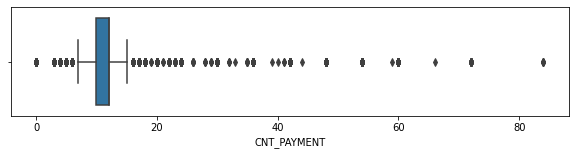

In [ ]:
fig=plt.subplots(figsize=(10, 2))
sns.boxplot(prev_ap_merged['CNT_PAYMENT'])
plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile
prev_ap_merged = prev_ap_merged[prev_ap_merged['CNT_PAYMENT'] < np.nanpercentile(prev_ap_merged['CNT_PAYMENT'], 99)]

In [ ]:
#Calculating the percenatge of the max categorie in the dataset

B=prev_ap_merged['CNT_PAYMENT'].value_counts().idxmax()
C=100*(prev_ap_merged['CNT_PAYMENT'].value_counts().max())/prev_ap_merged.shape[0]
print("The Percentage of the {} occure in the {}: {}%".format(B,'CNT_PAYMENT',C))

The Percentage of the 12.0 occure in the CNT_PAYMENT: 44.140201015215894%


In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'CNT_PAYMENT')

,Value,Percentage of Defaulter
37,41.0,33.333333
27,28.0,20.000000
23,17.0,16.666667
24,13.0,16.279070
32,35.0,14.285714
3,48.0,13.749204
11,36.0,11.749919
15,42.0,11.286550
4,0.0,10.566473
13,14.0,10.425020


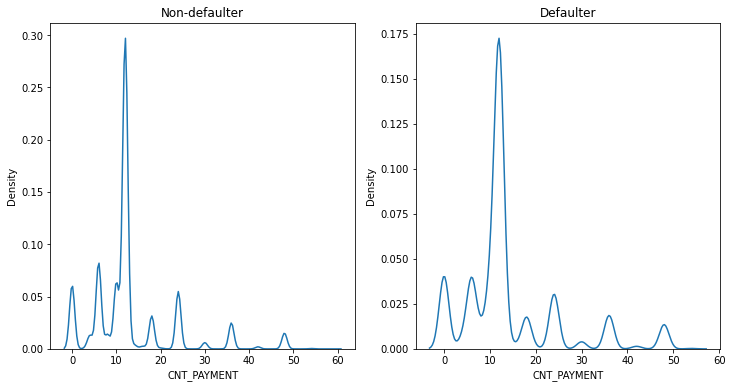

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['CNT_PAYMENT'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['CNT_PAYMENT'], ax=ax2)

plt.show()

### **Observation and Action:**

1) CNT_PAYMENT has the 12 as the most occuring category and It has the same distribution for the both defaulter and Non-defaulter.

2) In CNT_PAYMENT fature the category 41 has the highest defaulter percentage.


## **RATE_DOWN_PAYMENT**

In [ ]:
prev_ap_merged['RATE_DOWN_PAYMENT'].head()

0    0.000000
3    0.100037
4    0.212036
5         NaN
6         NaN
Name: RATE_DOWN_PAYMENT, dtype: float16

In [ ]:
prev_ap_merged['RATE_DOWN_PAYMENT'].describe()

count    558386.000000
mean          0.074524
std           0.096802
min          -0.000015
25%           0.000000
50%           0.049774
75%           0.108887
max           0.821777
Name: RATE_DOWN_PAYMENT, dtype: float64

In [ ]:
prev_ap_merged['RATE_DOWN_PAYMENT'].value_counts()

0.000000    268116
0.108887     30775
0.108948     16759
0.101379     12696
0.099976      6644
             ...  
0.026260         1
0.000246         1
0.012085         1
0.716309         1
0.588867         1
Name: RATE_DOWN_PAYMENT, Length: 7102, dtype: int64

In [ ]:
prev_ap_merged['RATE_DOWN_PAYMENT'].isna().sum()

575757

In [ ]:
prev_ap_merged['RATE_DOWN_PAYMENT'].fillna(prev_ap_merged['RATE_DOWN_PAYMENT'].median(),inplace = True)

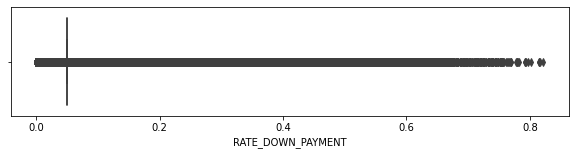

In [ ]:
fig=plt.subplots(figsize=(10, 2))
sns.boxplot(prev_ap_merged['RATE_DOWN_PAYMENT'])
plt.show()

In [ ]:
# Boxplot is showing the outliers for income and annuity, there are few entries having very large annuity and income than others.
# Considering this entries will mislead the average income of the entire population and further analysis.

# Excluding values outside 99 percentile
prev_ap_merged = prev_ap_merged[prev_ap_merged['RATE_DOWN_PAYMENT'] < np.nanpercentile(prev_ap_merged['RATE_DOWN_PAYMENT'], 99)]

In [ ]:
#Calculating the percenatge of the max categorie in the dataset

B=prev_ap_merged['RATE_DOWN_PAYMENT'].value_counts().idxmax()
C=100*(prev_ap_merged['RATE_DOWN_PAYMENT'].value_counts().max())/prev_ap_merged.shape[0]
print("The Percentage of the {} occure in the {}: {}%".format(B,'RATE_DOWN_PAYMENT',C))

The Percentage of the 0.049774169921875 occure in the RATE_DOWN_PAYMENT: 51.28990254702983%


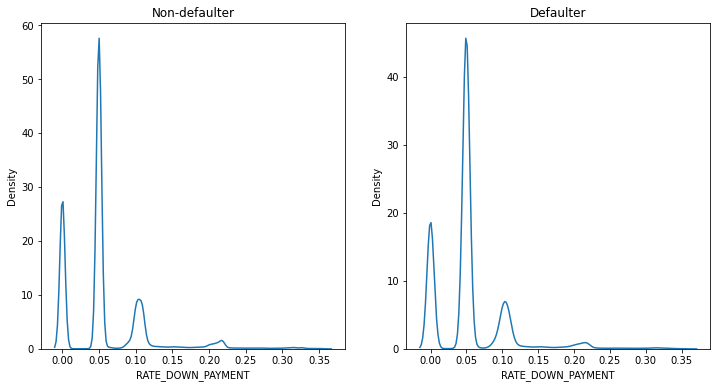

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['RATE_DOWN_PAYMENT'], ax=ax1)
sns.kdeplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['RATE_DOWN_PAYMENT'], ax=ax2)

plt.show()

### **Observation and Action:**

1) RATE_DOWN_PAYMENT has the 0.05029296875 as the most occuring category and It has the same distribution for the both defaulter and Non-defaulter.


# **Caterorical Feature**

In [ ]:
Categorical_Feature=[feature for feature in prev_ap_merged.columns if prev_ap_merged[feature].dtypes=='O' and feature not in ['SK_ID_CURR','SK_ID_PREV','TARGET']]
print(len(Categorical_Feature))
Categorical_Feature

16


['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

## **NAME_CONTRACT_TYPE**

In [ ]:
prev_ap_merged['NAME_CONTRACT_TYPE'].value_counts()

Consumer loans     516940
Cash loans         454738
Revolving loans    138050
XNA                   280
Name: NAME_CONTRACT_TYPE, dtype: int64

In [ ]:
# Filling missing value as 'Unaccompanied' as most common value

prev_ap_merged['NAME_CONTRACT_TYPE'].fillna(prev_ap_merged.NAME_CONTRACT_TYPE.mode()[0], inplace=True)

In [ ]:
prev_ap_merged['NAME_CONTRACT_TYPE'].isna().sum()

0

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_CONTRACT_TYPE')

,Value,Percentage of Defaulter
3,XNA,21.071429
2,Revolving loans,10.848968
1,Cash loans,9.607510
0,Consumer loans,8.080909


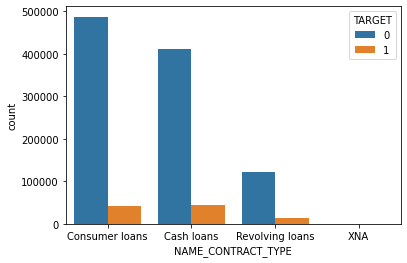

In [ ]:
sns.countplot(prev_ap_merged.NAME_CONTRACT_TYPE, hue=prev_ap_merged.TARGET)
plt.show()

### **Observation and Action:**

1) Consumer loans is the most occuring category of **NAME_CONTRACT_TYPE** features 

2) XNA category has highest default percentage but it has the very less number of count so this is not proper conclusion to made.

3) We can consider the Revolving loans category has the highest default percentage w.r.t Number of applicant.

##**WEEKDAY_APPR_PROCESS_START**

In [ ]:
prev_ap_merged['WEEKDAY_APPR_PROCESS_START'].head()

0    SATURDAY
3    SATURDAY
4      FRIDAY
5    THURSDAY
6    THURSDAY
Name: WEEKDAY_APPR_PROCESS_START, dtype: object

In [ ]:
prev_ap_merged['WEEKDAY_APPR_PROCESS_START'].value_counts()

WEDNESDAY    168637
TUESDAY      168041
MONDAY       167925
FRIDAY       166897
THURSDAY     165058
SATURDAY     161529
SUNDAY       111921
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

In [ ]:
prev_ap_merged['WEEKDAY_APPR_PROCESS_START'].isna().sum()

12790

In [ ]:
prev_ap_merged['WEEKDAY_APPR_PROCESS_START'].fillna(prev_ap_merged.WEEKDAY_APPR_PROCESS_START.mode()[0], inplace=True)

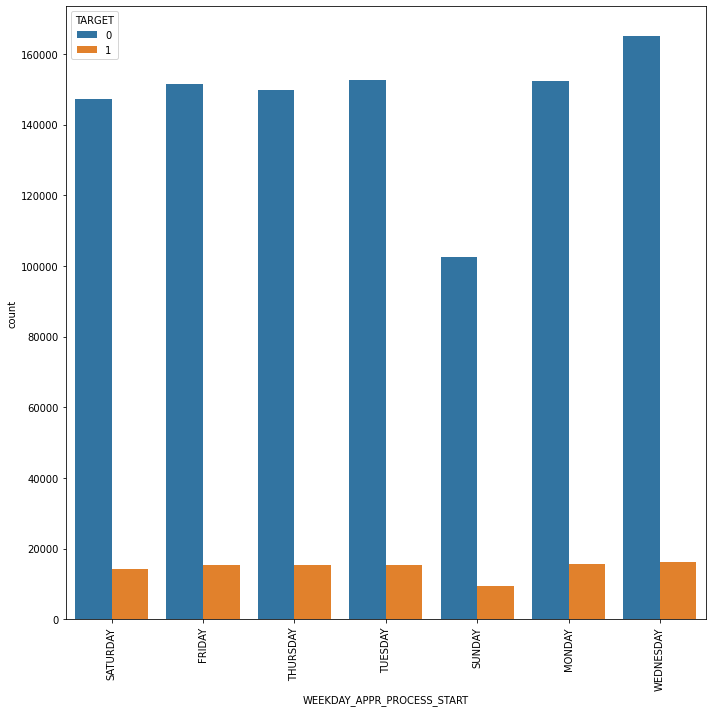

In [ ]:
fig=plt.subplots(figsize=(10, 10))
sns.countplot(prev_ap_merged['WEEKDAY_APPR_PROCESS_START'], hue=prev_ap_merged["TARGET"])
plt.xticks(rotation=90)
plt.tight_layout()


### **Observation and Action:**

1) All weekdays have similar number of applicants than weekend(Saturday and Sunday)


##**FLAG_LAST_APPL_PER_CONTRACT**

In [ ]:
prev_ap_merged['FLAG_LAST_APPL_PER_CONTRACT'].value_counts()

Y    1103869
N       6139
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64

### **Observation and Action:**

1) FLAG_LAST_APPL_PER_CONTRACT is highly imbalanced featuer so we will drop this feature


In [ ]:
prev_ap_merged.drop(labels=['FLAG_LAST_APPL_PER_CONTRACT'],axis=1,inplace=True)

## **NAME_CASH_LOAN_PURPOSE**

In [ ]:
prev_ap_merged['NAME_CASH_LOAN_PURPOSE'].value_counts()

XAP                                 655270
XNA                                 415730
Repairs                              12709
Other                                 9355
Urgent needs                          5685
Everyday expenses                     1619
Medicine                              1410
Buying a used car                     1275
Education                             1073
Building a house or an annex          1016
Purchase of electronic equipment       757
Payments on other loans                756
Journey                                727
Wedding / gift / holiday               588
Car repairs                            573
Furniture                              489
Buying a new car                       188
Business development                   187
Gasification / water supply            177
Buying a home                          166
Buying a holiday home / land           146
Buying a garage                         57
Hobby                                   30
Money for a

In [ ]:
prev_ap_merged['NAME_CASH_LOAN_PURPOSE'].isna().sum()

12790

In [ ]:
# Filling missing value as 'Unaccompanied' as most common value

prev_ap_merged['NAME_CASH_LOAN_PURPOSE'].fillna(prev_ap_merged.NAME_CASH_LOAN_PURPOSE.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_CASH_LOAN_PURPOSE')

,Value,Percentage of Defaulter
23,Money for a third person,23.529412
20,Gasification / water supply,20.903955
22,Hobby,20.000000
9,Car repairs,19.546248
11,Payments on other loans,17.724868
6,Urgent needs,15.813544
17,Business development,15.508021
18,Buying a home,15.060241
8,Medicine,14.680851
3,Repairs,14.108112


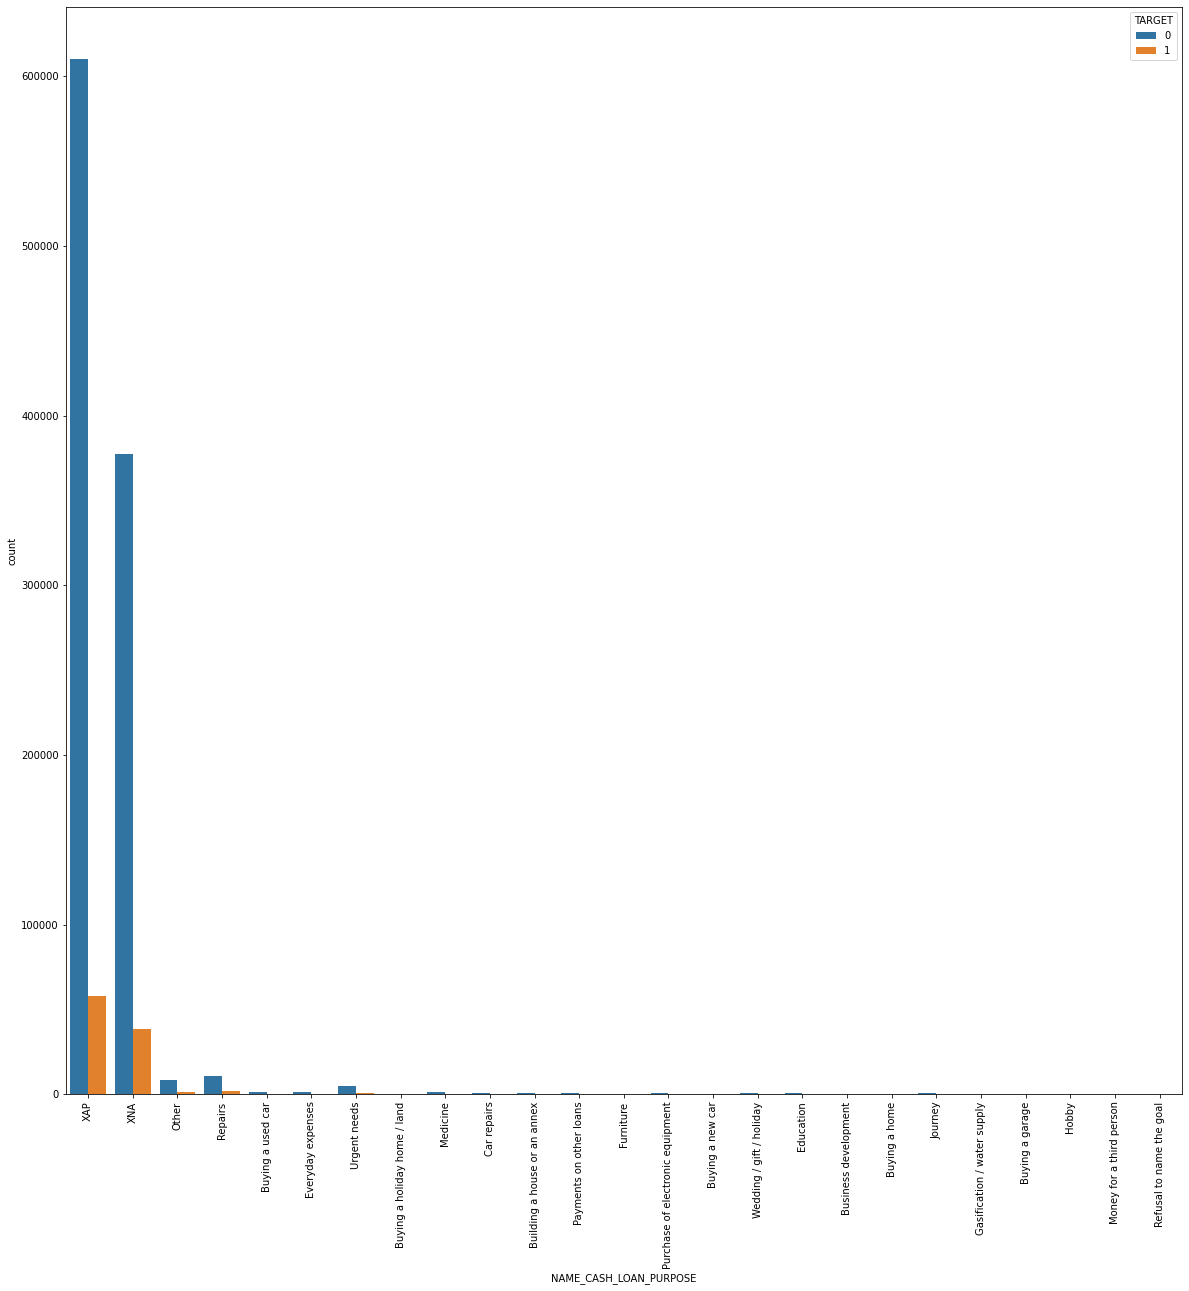

In [ ]:
fig=plt.subplots(figsize=(20, 20))
sns.countplot(prev_ap_merged.NAME_CASH_LOAN_PURPOSE, hue=prev_ap_merged.TARGET)
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XAP** for the **CASH_LOAN_PURPOSE**

2) Previous applicant which has the category as **Money for a third person**	shows the largest default percentage as 24%. But it's sample size is very small so it is not peroper decision.

## **NAME_CONTRACT_STATUS**

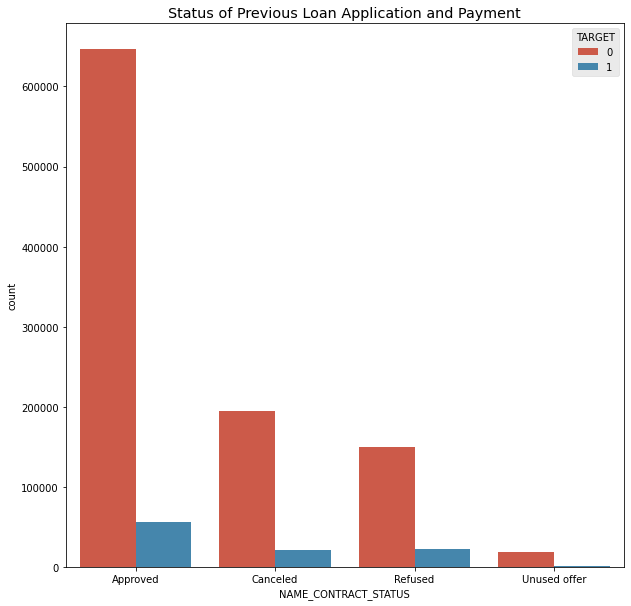

In [ ]:
fig=plt.subplots(figsize=(10, 10))
plt.style.use("ggplot")
plt.title("Status of Previous Loan Application and Payment")
sns.countplot(prev_ap_merged['NAME_CONTRACT_STATUS'], hue=prev_ap_merged['TARGET'])
plt.show()

In [ ]:
# Percentage of previously approved loan applicants that defaulted in current loan

total_approved = prev_ap_merged[prev_ap_merged['NAME_CONTRACT_STATUS'] == "Approved"].shape[0]
default_approved = prev_ap_merged[(prev_ap_merged['TARGET'] == 1) & (prev_ap_merged['NAME_CONTRACT_STATUS'] == "Approved")].shape[0]

print("Percentage of previously approved loan applicants that defaulted in current loan : ", (default_approved*100/total_approved))

Percentage of previously approved loan applicants that defaulted in current loan :  8.016245590076249


In [ ]:
# Percentage of previously refused loan applicants that were able to pay current loan

total_refused = prev_ap_merged[prev_ap_merged['NAME_CONTRACT_STATUS'] == "Refused"].shape[0]
nondefault_refused = prev_ap_merged[(prev_ap_merged['TARGET'] == 0) & (prev_ap_merged['NAME_CONTRACT_STATUS'] == "Refused")].shape[0]

print("Percentage of previously refused loan applicants that were able to pay current loan : ", (nondefault_refused*100/total_refused))

Percentage of previously refused loan applicants that were able to pay current loan :  87.20716742586222


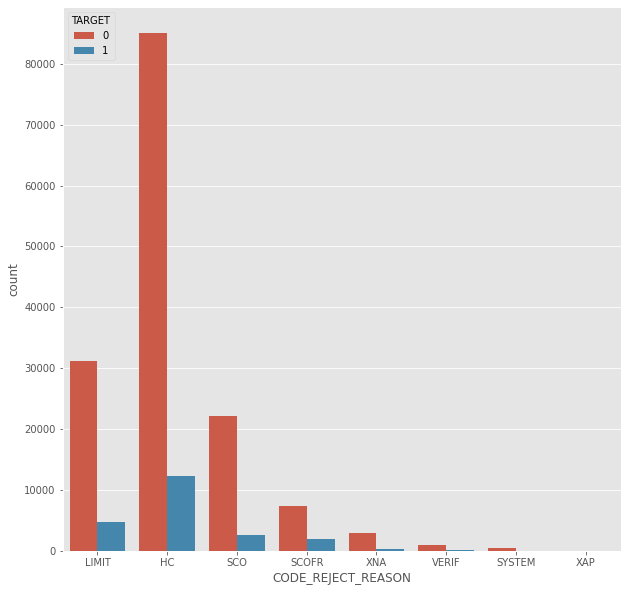

In [ ]:
fig=plt.subplots(figsize=(10, 10))
sns.countplot(prev_ap_merged[prev_ap_merged['NAME_CONTRACT_STATUS'] == "Refused"]["CODE_REJECT_REASON"], hue=prev_ap_merged.TARGET)
plt.show()

In [ ]:
prev_ap_merged['NAME_CONTRACT_STATUS'].value_counts()

Approved        702960
Canceled        214844
Refused         172112
Unused offer     20092
Name: NAME_CONTRACT_STATUS, dtype: int64

In [ ]:
prev_ap_merged['NAME_CONTRACT_STATUS'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_CONTRACT_STATUS'].fillna(prev_ap_merged.NAME_CONTRACT_STATUS.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_CONTRACT_STATUS')

,Value,Percentage of Defaulter
2,Refused,12.792833
1,Canceled,9.592076
3,Unused offer,8.490942
0,Approved,7.991617


### **Observation and Action:**

1) Most of the Previous applicant have the reason as **Approved** for the **NAME_CONTRACT_STATUS**

2) Previous applicant which has the category as **Refused**	shows the largest default percentage as 13%.

3) The applicants whose previous loans were approved are more likely to pay current loan in time, than the applicants whose previous loans were rejected.

4) 7% of the previously approved loan applicants that defaulted in current loan

5) 90 % of the previously refused loan applicants that were able to pay current loan

## **NAME_PAYMENT_TYPE**

In [ ]:
prev_ap_merged['NAME_PAYMENT_TYPE'].value_counts()

Cash through the bank                        671295
XNA                                          432154
Non-cash from your account                     5839
Cashless from the account of the employer       720
Name: NAME_PAYMENT_TYPE, dtype: int64

In [ ]:
prev_ap_merged['NAME_PAYMENT_TYPE'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_PAYMENT_TYPE'].fillna(prev_ap_merged.NAME_PAYMENT_TYPE.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_PAYMENT_TYPE')

,Value,Percentage of Defaulter
0,XNA,10.046187
2,Non-cash from your account,8.682994
3,Cashless from the account of the employer,8.472222
1,Cash through the bank,8.412551


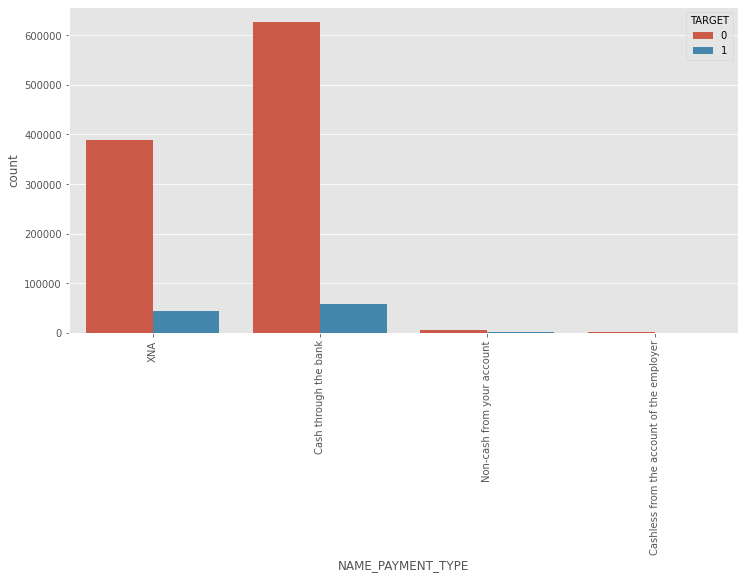

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_PAYMENT_TYPE'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **Cash through the bank** for the **PAYMENT_TYPE**

2) Previous applicant which has the category as **XNA**	shows the largest default percentage as 10%.

## **CODE_REJECT_REASON**

In [ ]:
prev_ap_merged['CODE_REJECT_REASON'].value_counts()

XAP       917797
HC         97318
LIMIT      35841
SCO        24779
CLIENT     20092
SCOFR       9355
XNA         3164
VERIF       1095
SYSTEM       567
Name: CODE_REJECT_REASON, dtype: int64

In [ ]:
prev_ap_merged['CODE_REJECT_REASON'].isna().sum()

12790

In [ ]:
prev_ap_merged['CODE_REJECT_REASON'].fillna(prev_ap_merged.CODE_REJECT_REASON.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'CODE_REJECT_REASON')

,Value,Percentage of Defaulter
4,SCOFR,21.336184
1,LIMIT,13.211127
2,HC,12.591710
3,SCO,10.375721
7,VERIF,10.136986
6,XNA,9.829330
5,CLIENT,8.490942
0,XAP,8.361174
8,SYSTEM,7.054674


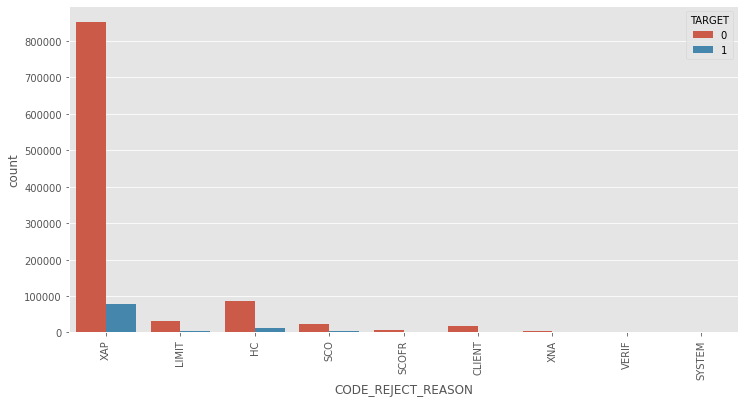

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['CODE_REJECT_REASON'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XAP** for the **CODE_REJECT_REASON**

2) Previous applicant which has the category as **SCOFR**	shows the largest default percentage as 22%.

## **NAME_TYPE_SUITE**

In [ ]:
prev_ap_merged['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      312582
Family             141151
Spouse, partner     44816
Children            21772
Other_B             12102
Other_A              6262
Group of people      1521
Name: NAME_TYPE_SUITE, dtype: int64

In [ ]:
prev_ap_merged['NAME_TYPE_SUITE'].isna().sum()

582592

In [ ]:
prev_ap_merged['NAME_TYPE_SUITE'].fillna(prev_ap_merged.NAME_TYPE_SUITE.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_TYPE_SUITE')

,Value,Percentage of Defaulter
6,Group of people,10.059172
0,Unaccompanied,9.313161
3,Other_A,9.086554
5,Other_B,8.816725
4,"Spouse, partner",8.559443
1,Family,7.863210
2,Children,6.609407


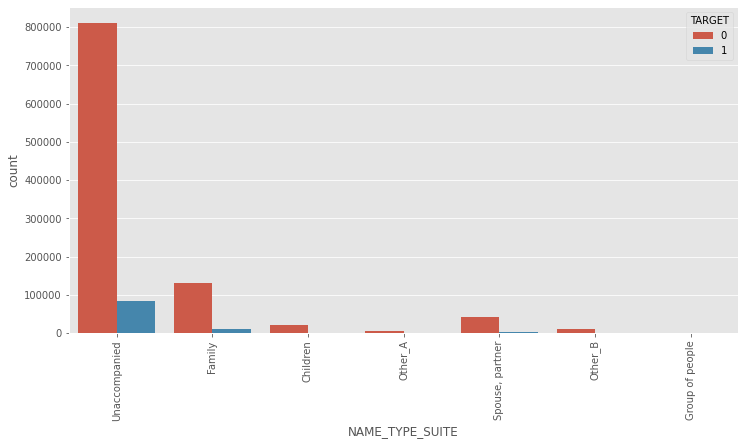

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_TYPE_SUITE'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **Unaccompanied** for the **NAME_TYPE_SUITE**

2) Previous applicant which has the category as **Group of people**	shows the largest default percentage as 10%.

## **NAME_CLIENT_TYPE**

In [ ]:
prev_ap_merged['NAME_CLIENT_TYPE'].value_counts()

Repeater     801704
New          214496
Refreshed     92618
XNA            1190
Name: NAME_CLIENT_TYPE, dtype: int64

In [ ]:
prev_ap_merged['NAME_CLIENT_TYPE'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_CLIENT_TYPE'].fillna(prev_ap_merged.NAME_CLIENT_TYPE.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_CLIENT_TYPE')

,Value,Percentage of Defaulter
3,XNA,11.512605
0,New,9.550761
2,Repeater,9.052246
1,Refreshed,7.751193


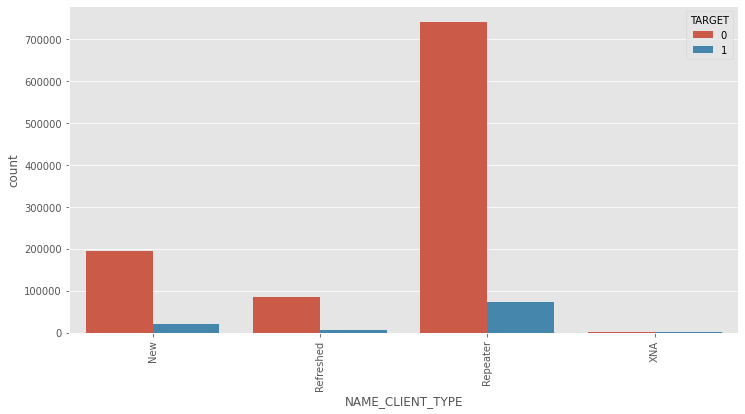

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_CLIENT_TYPE'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **Repeater** for the **NAME_CLIENT_TYPE**

2) Previous applicant which has the category as **XNA**	shows the largest default percentage as 12%. But it's sample size is very small so it is not peroper decision.

## **NAME_GOODS_CATEGORY**

In [ ]:
prev_ap_merged['NAME_GOODS_CATEGORY'].value_counts()

XNA                         599910
Mobile                      167391
Consumer Electronics         84748
Computers                    73049
Audio/Video                  68771
Furniture                    36499
Photo / Cinema Equipment     18079
Construction Materials       17522
Clothing and Accessories     15509
Auto Accessories              5335
Jewelry                       4531
Homewares                     3451
Medical Supplies              2762
Vehicles                      2228
Sport and Leisure             2167
Other                         1933
Gardening                     1890
Office Appliances             1669
Medicine                      1021
Tourism                        897
Direct Sales                   266
Fitness                        133
Additional Service              84
Education                       63
Weapon                          51
Insurance                       48
Animals                          1
Name: NAME_GOODS_CATEGORY, dtype: int64

In [ ]:
prev_ap_merged['NAME_GOODS_CATEGORY'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_GOODS_CATEGORY'].fillna(prev_ap_merged.NAME_GOODS_CATEGORY.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_GOODS_CATEGORY')

,Value,Percentage of Defaulter
22,Insurance,12.500000
0,Vehicles,10.906643
3,XNA,9.813938
17,Auto Accessories,9.484536
14,Jewelry,9.291547
20,Direct Sales,9.022556
2,Mobile,9.007653
15,Office Appliances,8.687837
7,Computers,8.517570
5,Audio/Video,8.134243


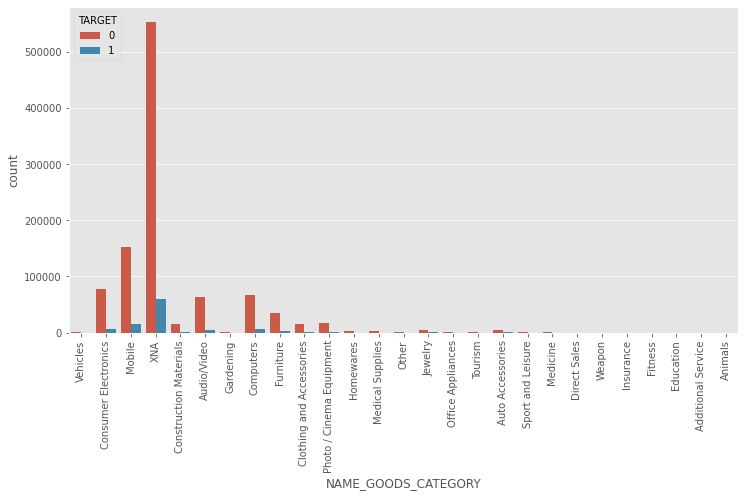

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_GOODS_CATEGORY'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XNA** for the **GOODS_CATEGORY**

2) Previous applicant which has the category as **Insurance**	shows the largest default percentage as 13%.But it's sample size is very small so it is not peroper decision.

## **NAME_PORTFOLIO**

In [ ]:
prev_ap_merged['NAME_PORTFOLIO'].value_counts()

POS      488422
XNA      259263
Cash     258299
Cards    104024
Name: NAME_PORTFOLIO, dtype: int64

In [ ]:
prev_ap_merged['NAME_PORTFOLIO'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_PORTFOLIO'].fillna(prev_ap_merged.NAME_PORTFOLIO.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_PORTFOLIO')

,Value,Percentage of Defaulter
3,Cards,10.567754
2,XNA,10.155325
1,Cash,9.320594
0,POS,8.007590


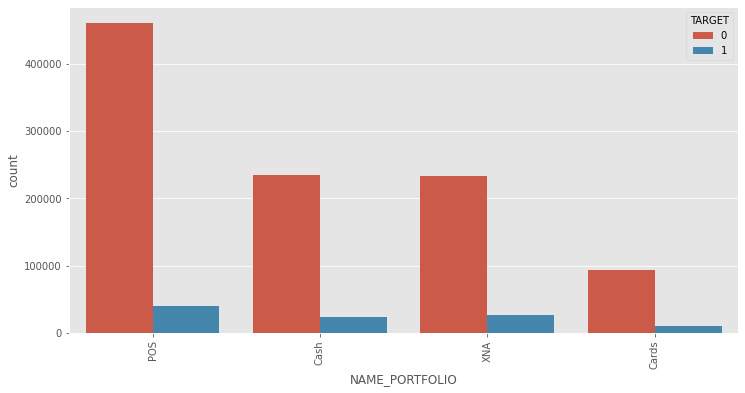

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_PORTFOLIO'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **POS** for the **PORTFOLIO**

2) Previous applicant which has the category as **Cards**	shows the largest default percentage as 11%.

## **NAME_PRODUCT_TYPE**

In [ ]:
prev_ap_merged['NAME_PRODUCT_TYPE'].value_counts()

XNA        747685
x-sell     268688
walk-in     93635
Name: NAME_PRODUCT_TYPE, dtype: int64

In [ ]:
prev_ap_merged['NAME_PRODUCT_TYPE'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_PRODUCT_TYPE'].fillna(prev_ap_merged.NAME_PRODUCT_TYPE.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_PRODUCT_TYPE')

,Value,Percentage of Defaulter
2,walk-in,13.101938
0,XNA,8.739801
1,x-sell,8.485679


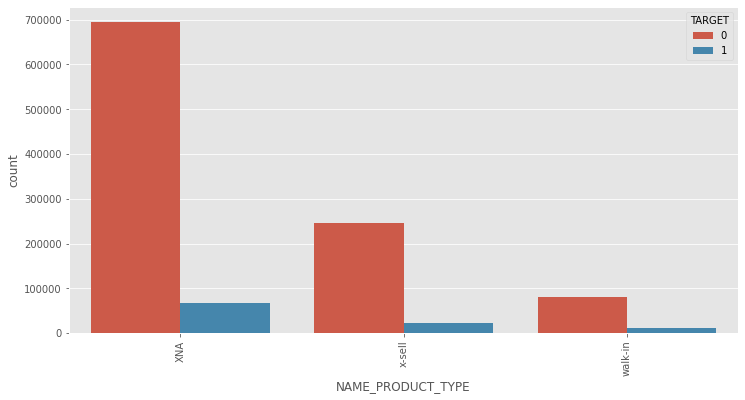

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_PRODUCT_TYPE'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XNA** for the **PRODUCT_TYPE**

2) Previous applicant which has the category as **walk-in**	shows the largest default percentage as 13%.

## **CHANNEL_TYPE**

In [ ]:
prev_ap_merged['CHANNEL_TYPE'].value_counts()

Credit and cash offices       447065
Country-wide                  346688
Stone                         154337
Regional / Local               78209
Contact center                 41603
AP+ (Cash loan)                39555
Channel of corporate sales      2530
Car dealer                        21
Name: CHANNEL_TYPE, dtype: int64

In [ ]:
prev_ap_merged['CHANNEL_TYPE'].isna().sum()

12790

In [ ]:
prev_ap_merged['CHANNEL_TYPE'].fillna(prev_ap_merged.CHANNEL_TYPE.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'CHANNEL_TYPE')

,Value,Percentage of Defaulter
4,AP+ (Cash loan),13.131083
5,Contact center,10.967959
3,Credit and cash offices,9.421448
1,Country-wide,8.695715
2,Regional / Local,8.078354
0,Stone,7.696145
6,Channel of corporate sales,4.229249
7,Car dealer,0.000000


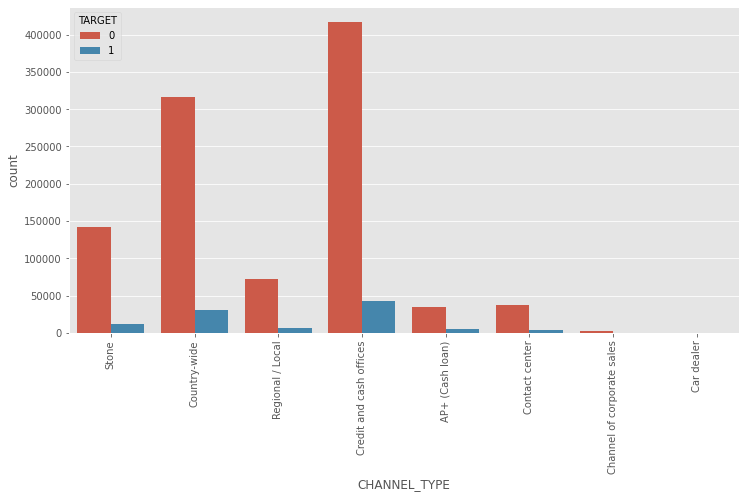

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['CHANNEL_TYPE'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XNA** for the **Credit and cash offices**

2) Previous applicant which has the category as **AP+ (Cash loan)	**	shows the largest default percentage as 13%.

## **NAME_SELLER_INDUSTRY**

In [ ]:
prev_ap_merged['NAME_SELLER_INDUSTRY'].value_counts()

XNA                     531796
Consumer electronics    275150
Connectivity            207910
Furniture                39335
Construction             20460
Clothing                 15752
Industry                 13326
Auto technology           3421
Jewelry                   1886
MLM partners               734
Tourism                    238
Name: NAME_SELLER_INDUSTRY, dtype: int64

In [ ]:
prev_ap_merged['NAME_SELLER_INDUSTRY'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_SELLER_INDUSTRY'].fillna(prev_ap_merged.NAME_SELLER_INDUSTRY.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_SELLER_INDUSTRY')

,Value,Percentage of Defaulter
0,Auto technology,10.640164
3,XNA,9.780273
2,Connectivity,9.561349
9,Jewelry,9.013786
1,Consumer electronics,7.940396
7,Industry,7.661714
4,Construction,6.935484
5,Furniture,6.426846
10,MLM partners,6.267030
6,Clothing,6.240477


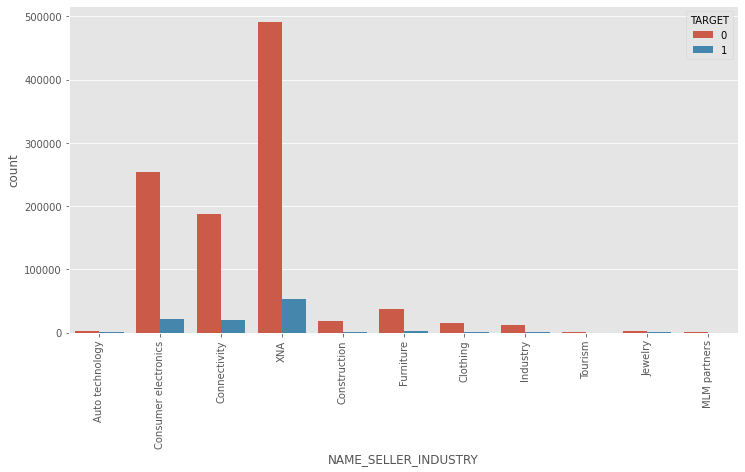

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_SELLER_INDUSTRY'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XNA** for the **SELLER_INDUSTRY**

2) Previous applicant which has the category as **Auto technology**	shows the largest default percentage as 11%.

## **NAME_YIELD_GROUP**

In [ ]:
prev_ap_merged['NAME_YIELD_GROUP'].value_counts()

XNA           363287
high          255827
middle        252787
low_normal    186267
low_action     51840
Name: NAME_YIELD_GROUP, dtype: int64

In [ ]:
prev_ap_merged['NAME_YIELD_GROUP'].isna().sum()

12790

In [ ]:
prev_ap_merged['NAME_YIELD_GROUP'].fillna(prev_ap_merged.NAME_YIELD_GROUP.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'NAME_YIELD_GROUP')

,Value,Percentage of Defaulter
2,XNA,10.149783
3,high,9.980573
1,middle,8.352882
0,low_normal,7.099486
4,low_action,6.730324


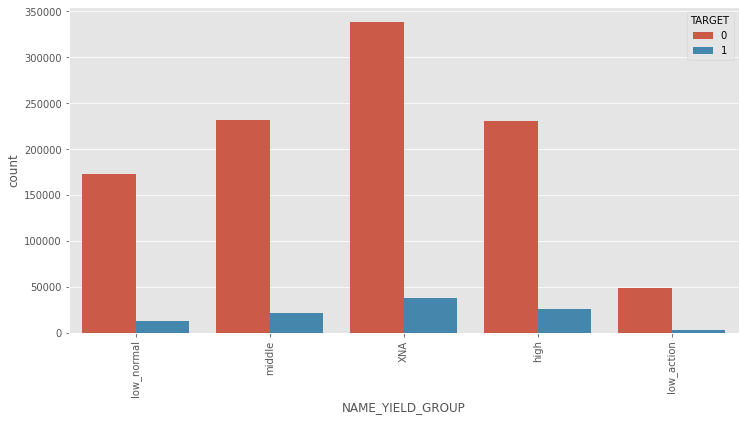

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['NAME_YIELD_GROUP'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **XNA** for the **YIELD_GROUP**

2) Previous applicant which has the category as **XNA**	shows the largest default percentage as 10%.

## **PRODUCT_COMBINATION**

In [ ]:
prev_ap_merged['PRODUCT_COMBINATION'].value_counts()

Cash                              196439
POS household with interest       181783
POS mobile with interest          165310
Cash X-Sell: middle                89567
Card Street                        81712
POS industry with interest         67143
POS household without interest     58295
Card X-Sell                        56338
Cash X-Sell: low                   51813
Cash Street: high                  42997
Cash X-Sell: high                  42135
Cash Street: middle                21743
POS mobile without interest        17619
POS other with interest            16645
Cash Street: low                   10044
POS industry without interest       8283
POS others without interest         1862
Name: PRODUCT_COMBINATION, dtype: int64

In [ ]:
prev_ap_merged['PRODUCT_COMBINATION'].isna().sum()

13070

In [ ]:
prev_ap_merged['PRODUCT_COMBINATION'].fillna(prev_ap_merged.PRODUCT_COMBINATION.mode()[0], inplace=True)

In [ ]:
value_wise_defaulter_percentage(prev_ap_merged,'PRODUCT_COMBINATION')

,Value,Percentage of Defaulter
15,Cash Street: middle,12.128041
6,Cash X-Sell: high,11.980539
9,Cash Street: high,11.872921
4,Card Street,11.617633
7,Cash,9.795283
5,Card X-Sell,9.734105
11,POS mobile with interest,9.148267
12,Cash Street: low,8.910793
0,POS other with interest,8.657254
2,POS mobile without interest,8.195698


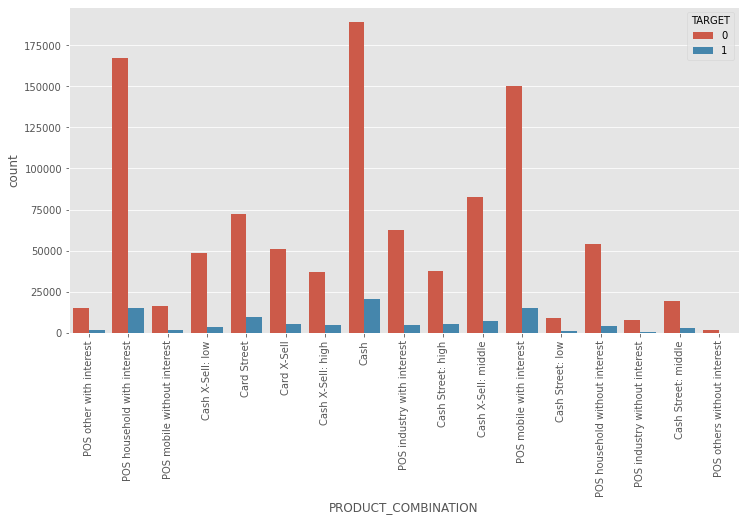

In [ ]:
fig = plt.figure(figsize=(12,6))

sns.countplot(prev_ap_merged['PRODUCT_COMBINATION'], hue=prev_ap_merged['TARGET'])
plt.xticks(rotation=90)
plt.show()

### **Observation and Action:**

1) Most of the previous applicant have the reason as **Cash** for the **PRODUCT_COMBINATION**

2) Previous applicant which has the category as **Cash Street: middle**	shows the largest default percentage as 12%.

In [ ]:
prev_ap_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122798 entries, 0 to 1227810
Data columns (total 32 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   SK_ID_CURR                  1122798 non-null  int32  
 1   TARGET                      1122798 non-null  int8   
 2   NAME_CONTRACT_TYPE          1122798 non-null  object 
 3   AMT_ANNUITY                 1122798 non-null  float32
 4   AMT_APPLICATION             1122798 non-null  float32
 5   AMT_CREDIT                  1122798 non-null  float32
 6   AMT_DOWN_PAYMENT            1122798 non-null  float32
 7   AMT_GOODS_PRICE             1122798 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START  1122798 non-null  object 
 9   NFLAG_LAST_APPL_IN_DAY      1122798 non-null  float64
 10  RATE_DOWN_PAYMENT           1122798 non-null  float16
 11  NAME_CASH_LOAN_PURPOSE      1122798 non-null  object 
 12  NAME_CONTRACT_STATUS        1122798 non-null  object 
 1

In [ ]:
# dropping the TARGET Variable before concatenating with the application_data
prev_ap_merged.drop(labels='TARGET', axis=1, inplace=True)

#<font color='red'>  **Concatinating the application_data and Previous_application_data**

In [ ]:
print("application_data.shape: ",application_data.shape)
print("prev_ap_merged.shape: ",prev_ap_merged.shape)

application_data.shape:  (268804, 41)
prev_ap_merged.shape:  (1122798, 31)


In [ ]:
#merge both the dataframe on SK_ID_CURR with Inner Joins
loan_process_df = pd.merge(application_data, prev_ap_merged, how='inner', on='SK_ID_CURR')
loan_process_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,YEAR_DECISION,YEAR_FIRST_DUE,YEAR_LAST_DUE_1ST_VERSION,YEAR_LAST_DUE,YEAR_TERMINATION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,0.0,1.0,1.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Consumer electronics,12.0,middle,POS household with interest,1.0,6.0,6.0,5.0,5.0,5.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,0.0,2.0,2.0,1.0,1.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,XNA,48.0,low_normal,Cash X-Sell: low,0.0,0.0,0.0,4.0,0.0,0.0
4,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,XNA,12.0,XNA,Card Street,0.0,0.0,2.0,1.0,1.0,1.0


In [ ]:
loan_process_df.shape

(1122798, 71)

In [ ]:
loan_process_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122798 entries, 0 to 1122797
Data columns (total 71 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1122798 non-null  int32  
 1   TARGET                        1122798 non-null  int8   
 2   NAME_CONTRACT_TYPE_x          1122798 non-null  object 
 3   CODE_GENDER                   1122798 non-null  object 
 4   FLAG_OWN_CAR                  1122798 non-null  object 
 5   FLAG_OWN_REALTY               1122798 non-null  object 
 6   CNT_CHILDREN                  1122798 non-null  int8   
 7   AMT_INCOME_TOTAL              1122798 non-null  float32
 8   AMT_CREDIT_x                  1122798 non-null  float32
 9   AMT_ANNUITY_x                 1122798 non-null  float32
 10  AMT_GOODS_PRICE_x             1122798 non-null  float32
 11  NAME_TYPE_SUITE_x             1122798 non-null  object 
 12  NAME_INCOME_TYPE            

# <font color='red'>**Handling the rare categorical feature**

In [ ]:
Categorical_features=[feature for feature in loan_process_df.columns if loan_process_df[feature].dtype=='O']

In [ ]:
Categorical_features

['NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START_x',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_TYPE_y',
 'WEEKDAY_APPR_PROCESS_START_y',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE_y',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [ ]:
# Removing the category which has the value less than 1% 
for feature in Categorical_features:
    temp=loan_process_df.groupby(feature)['TARGET'].count()/len(loan_process_df)# normalize the feature count of each category
    temp_df=temp[temp>0.01].index# Finding the category which has the value less that 0.01 i.e., 1%
    loan_process_df[feature]=np.where(loan_process_df[feature].isin(temp_df),loan_process_df[feature],'Rare_var')#replacing the category with the tag Rare_var

In [ ]:
loan_process_df.head(50)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,YEAR_DECISION,YEAR_FIRST_DUE,YEAR_LAST_DUE_1ST_VERSION,YEAR_LAST_DUE,YEAR_TERMINATION
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.5,24700.5,...,Rare_var,24.0,low_normal,POS other with interest,0.0,1.0,1.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.5,35698.5,...,Consumer electronics,12.0,middle,POS household with interest,1.0,6.0,6.0,5.0,5.0,5.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,0.0,2.0,2.0,1.0,1.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,XNA,48.0,low_normal,Cash X-Sell: low,0.0,0.0,0.0,4.0,0.0,0.0
4,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,XNA,12.0,XNA,Card Street,0.0,0.0,2.0,1.0,1.0,1.0
5,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,XNA,0.0,XNA,Card X-Sell,0.0,0.0,2.0,1.0,1.0,1.0
6,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,XNA,18.0,high,Cash X-Sell: high,0.0,1.0,2.0,1.0,1.0,1.0
7,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,XNA,12.0,XNA,Cash,0.0,0.0,2.0,1.0,1.0,1.0
8,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,Construction,12.0,middle,POS industry with interest,0.0,1.0,1.0,0.0,1.0,1.0
9,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.5,29686.5,...,XNA,12.0,XNA,Cash,0.0,0.0,2.0,1.0,1.0,1.0


# **Analysis on the dataset post concatenation**

In [ ]:
loan_process_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122798 entries, 0 to 1122797
Data columns (total 71 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1122798 non-null  int32  
 1   TARGET                        1122798 non-null  int8   
 2   NAME_CONTRACT_TYPE_x          1122798 non-null  object 
 3   CODE_GENDER                   1122798 non-null  object 
 4   FLAG_OWN_CAR                  1122798 non-null  object 
 5   FLAG_OWN_REALTY               1122798 non-null  object 
 6   CNT_CHILDREN                  1122798 non-null  int8   
 7   AMT_INCOME_TOTAL              1122798 non-null  float32
 8   AMT_CREDIT_x                  1122798 non-null  float32
 9   AMT_ANNUITY_x                 1122798 non-null  float32
 10  AMT_GOODS_PRICE_x             1122798 non-null  float32
 11  NAME_TYPE_SUITE_x             1122798 non-null  object 
 12  NAME_INCOME_TYPE            

In [ ]:
loan_process_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x',
       'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'Age',
       'YEAR_EMPLOYED', 'YEAR_REGISTRATION', 'YEAR_ID_PUBLISH',
       'YEAR_LAST_PH

In [ ]:
# Checking correlation between features of loan_process_df

"""plt.figure(figsize=(50,30))
sns.heatmap(loan_process_df.corr(), annot=True)
plt.show()"""

'plt.figure(figsize=(50,30))\nsns.heatmap(loan_process_df.corr(), annot=True)\nplt.show()'

In [ ]:
# Getting the top correlation for the Defaulter data

corr_Defaulter = loan_process_df.corr()['TARGET'].sort_values()

print(corr_Defaulter.head(10))
print("="*100)
print(corr_Defaulter.tail(10))

EXT_SOURCE_3             -0.168518
EXT_SOURCE_2             -0.155226
Age                      -0.075627
YEAR_LAST_PHONE_CHANGE   -0.061276
YEAR_ID_PUBLISH          -0.052249
YEAR_EMPLOYED            -0.045921
YEAR_DECISION            -0.041204
YEAR_REGISTRATION        -0.040075
YEAR_LAST_DUE            -0.032555
YEAR_TERMINATION         -0.031616
Name: TARGET, dtype: float64
OBS_60_CNT_SOCIAL_CIRCLE       0.012271
CNT_FAM_MEMBERS                0.015302
CNT_CHILDREN                   0.021176
CNT_PAYMENT                    0.025574
DEF_60_CNT_SOCIAL_CIRCLE       0.027612
REG_CITY_NOT_LIVE_CITY         0.040347
REG_CITY_NOT_WORK_CITY         0.048614
REGION_RATING_CLIENT           0.049947
REGION_RATING_CLIENT_W_CITY    0.052808
TARGET                         1.000000
Name: TARGET, dtype: float64


In [ ]:
Categorical_features=[feature for feature in loan_process_df.columns if loan_process_df[feature].dtype=='O']

In [ ]:
Categorical_features

['NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START_x',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_TYPE_y',
 'WEEKDAY_APPR_PROCESS_START_y',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE_y',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [ ]:
continous_feature=[feature for feature in loan_process_df.columns if feature not in Categorical_features and feature not in ['SK_ID_CURR','TARGET']]

In [ ]:
continous_feature

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'REGION_POPULATION_RELATIVE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'Age',
 'YEAR_EMPLOYED',
 'YEAR_REGISTRATION',
 'YEAR_ID_PUBLISH',
 'YEAR_LAST_PHONE_CHANGE',
 'AMT_ANNUITY_y',
 'AMT_APPLICATION',
 'AMT_CREDIT_y',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE_y',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'NFLAG_INSURED_ON_APPROVAL',
 'YEAR_DECISION',
 'YEAR_FIRST_DUE',
 'YEAR_LAST_DUE_1ST_VERSION',
 'YEAR_LAST_DUE',
 'YEAR_TERMINATION']

#<font color='red'> **One-Hot Encoding**

In [ ]:
"""# Label encoding to the categorical features
for feature in Categorical_features:
    labels_ordered=loan_process_df.groupby([feature])['TARGET'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}# Assigned the numerical value to each label(like label encoding)
    loan_process_df[feature]=loan_process_df[feature].map(labels_ordered)#Mapping the numerical value to the each label"""

"# Label encoding to the categorical features\nfor feature in Categorical_features:\n    labels_ordered=loan_process_df.groupby([feature])['TARGET'].mean().sort_values().index\n    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}# Assigned the numerical value to each label(like label encoding)\n    loan_process_df[feature]=loan_process_df[feature].map(labels_ordered)#Mapping the numerical value to the each label"

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(loan_process_df[Categorical_features])


OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
data_cat=ohe.transform(loan_process_df[Categorical_features])

In [ ]:
cat_cols_ohe = list(ohe.get_feature_names(input_features=Categorical_features))

In [ ]:
data_cat_final = pd.DataFrame(data_cat, columns = cat_cols_ohe)

In [ ]:
data_cat_final.head()

,NAME_CONTRACT_TYPE_x_Cash loans,NAME_CONTRACT_TYPE_x_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_Rare_var,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_x_Children,...,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Rare_var
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <font color='red'>**Feature Scaling for Continous Feature**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(loan_process_df[continous_feature])

StandardScaler()

In [ ]:
data_Num=scaler.transform(loan_process_df[continous_feature])

In [ ]:
data_Num_final=pd.DataFrame(data_Num, columns=continous_feature)

In [ ]:
# transform the train and test set, and add on the SK_ID_CURR and TARGET variables
data = pd.concat([loan_process_df[['SK_ID_CURR','TARGET']].reset_index(drop=True),data_Num_final],axis=1)

In [ ]:
data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,...,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,NFLAG_INSURED_ON_APPROVAL,YEAR_DECISION,YEAR_FIRST_DUE,YEAR_LAST_DUE_1ST_VERSION,YEAR_LAST_DUE,YEAR_TERMINATION
0,100002,1,-0.575861,0.568040,-0.411861,-0.059641,-0.447252,-0.043399,-1.268576,-0.206689,...,0.061232,-1.038809,0.484023,1.137166,-0.486296,-0.433338,-0.777881,-0.400731,-1.028026,-1.024943
1,100003,0,-0.575861,1.499320,2.225062,0.864461,2.115155,-1.478026,-0.173921,-2.338569,...,0.061232,0.759422,-0.039606,-0.118361,2.056360,1.885479,2.178235,2.220916,2.177566,2.241289
2,100004,0,-0.575861,-1.294521,-1.219368,-1.567924,-1.158208,-0.867695,-1.268576,-0.206689,...,0.061232,2.772696,-0.336329,-0.955379,-0.486296,0.030425,-0.186657,-0.400731,-0.386908,-0.371697
3,100006,0,-0.575861,-0.363240,-0.691086,0.359305,-0.624991,-1.057090,-0.173921,-0.206689,...,0.061232,-0.144082,-0.390438,3.648220,-0.486296,-0.897102,-1.369104,1.565505,-1.028026,-1.024943
4,100006,0,-0.575861,-0.363240,-0.691086,0.359305,-0.624991,-1.057090,-0.173921,-0.206689,...,0.061232,-0.144082,-0.390438,-0.118361,-0.486296,-0.897102,-0.186657,-0.400731,-0.386908,-0.371697


In [ ]:
# Final complete data
data_final = pd.concat([data_cat_final,data], axis = 1)

In [ ]:
data_final.shape

(1122798, 207)

In [ ]:
# Getting the top correlation for the Defaulter data

corr_Defaulter = data_final.corr()['TARGET'].sort_values()

print(corr_Defaulter.head(10))
print("="*100)
print(corr_Defaulter.tail(10))

EXT_SOURCE_3                    -0.168518
EXT_SOURCE_2                    -0.155226
Age                             -0.075627
YEAR_LAST_PHONE_CHANGE          -0.061276
CODE_GENDER_F                   -0.055232
CODE_REJECT_REASON_XAP          -0.052293
YEAR_ID_PUBLISH                 -0.052249
NAME_INCOME_TYPE_Pensioner      -0.050560
ORGANIZATION_TYPE_XNA           -0.050110
NAME_CONTRACT_STATUS_Approved   -0.048602
Name: TARGET, dtype: float64
NAME_EDUCATION_TYPE_Secondary / secondary special    0.041626
OCCUPATION_TYPE_Laborers                             0.041955
NAME_PRODUCT_TYPE_walk-in                            0.042692
REG_CITY_NOT_WORK_CITY                               0.048614
REGION_RATING_CLIENT                                 0.049947
REGION_RATING_CLIENT_W_CITY                          0.052808
CODE_GENDER_M                                        0.055238
NAME_CONTRACT_STATUS_Refused                         0.055636
NAME_INCOME_TYPE_Working                             0.

In [ ]:
cd /content/drive/MyDrive/Loan Defaulter

/content/drive/MyDrive/Loan Defaulter


In [ ]:
data_final.to_csv('loan_process_df_StandardScaler_onehot.csv',index=False)